In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). 

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(
    dirname + "astro.txt", format="csv", fill_values=[(".", "0")]
)

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping
# the primary and secondary star
ind = (
    (astro_dates.value > 1975.0)
    & (astro_dates.value < 1999.73)
    & (~astro_data_full["rho"].mask)
    & (~astro_data_full["PA"].mask)
)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = "jd"
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float)  # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float)
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg)  # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit. 

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

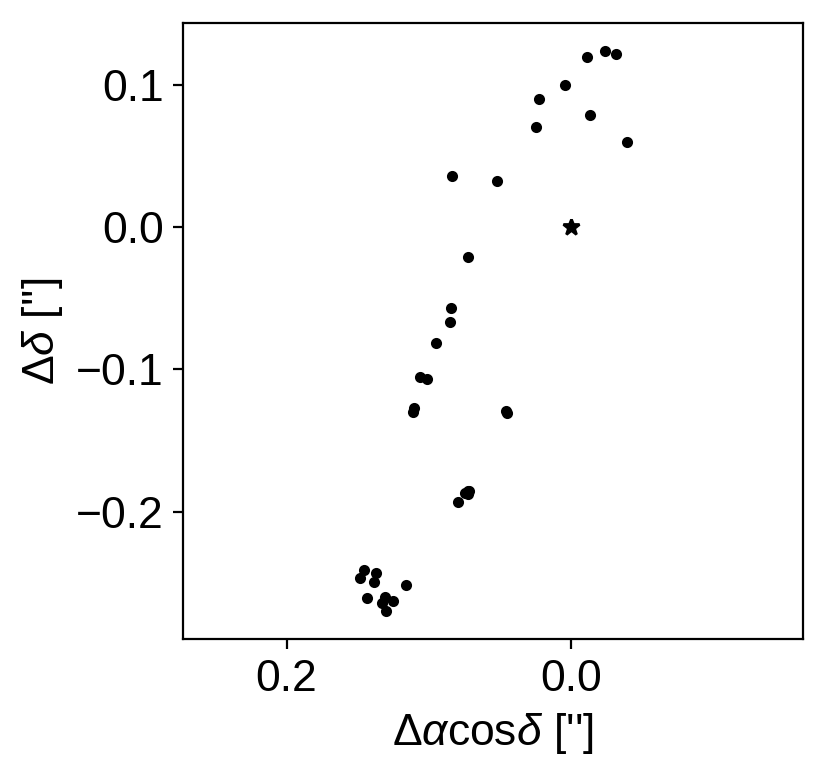

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

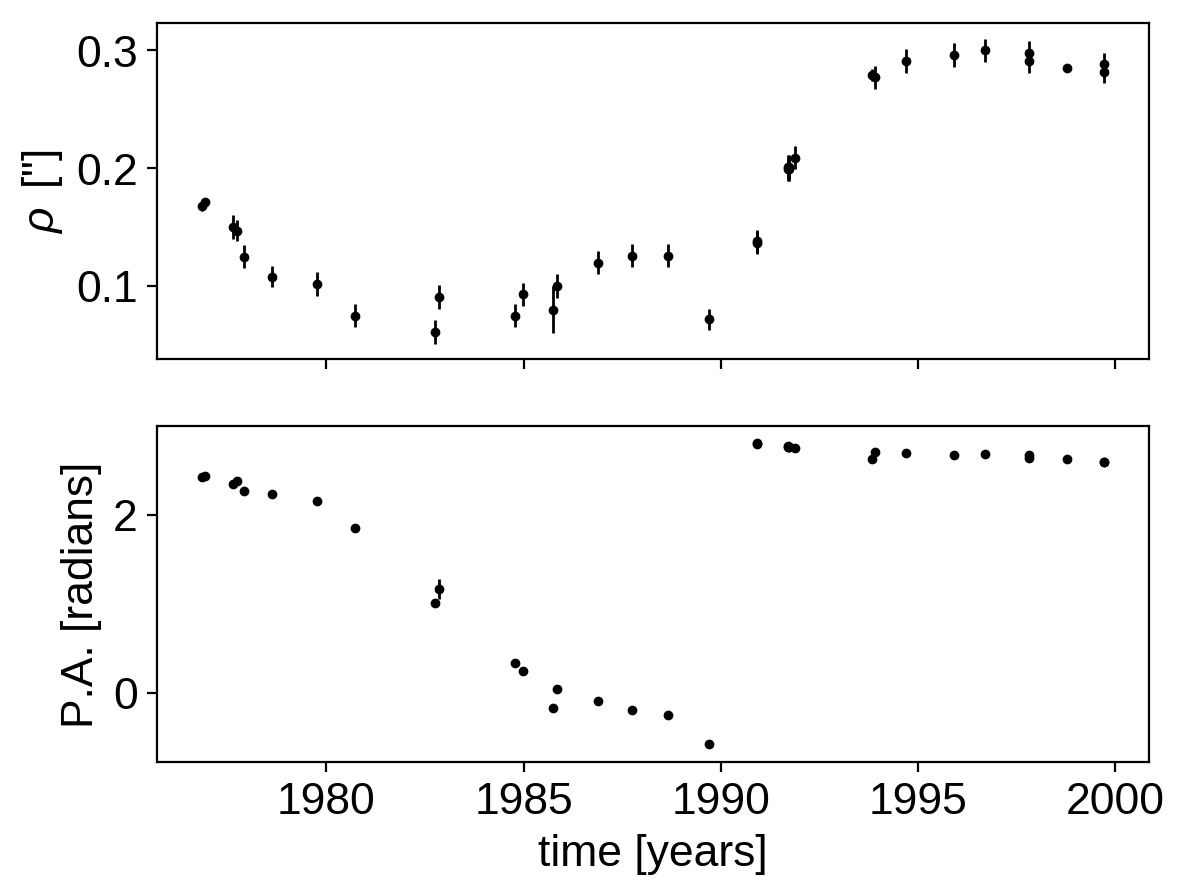

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
ax[1].set_xlabel("time [years]");

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

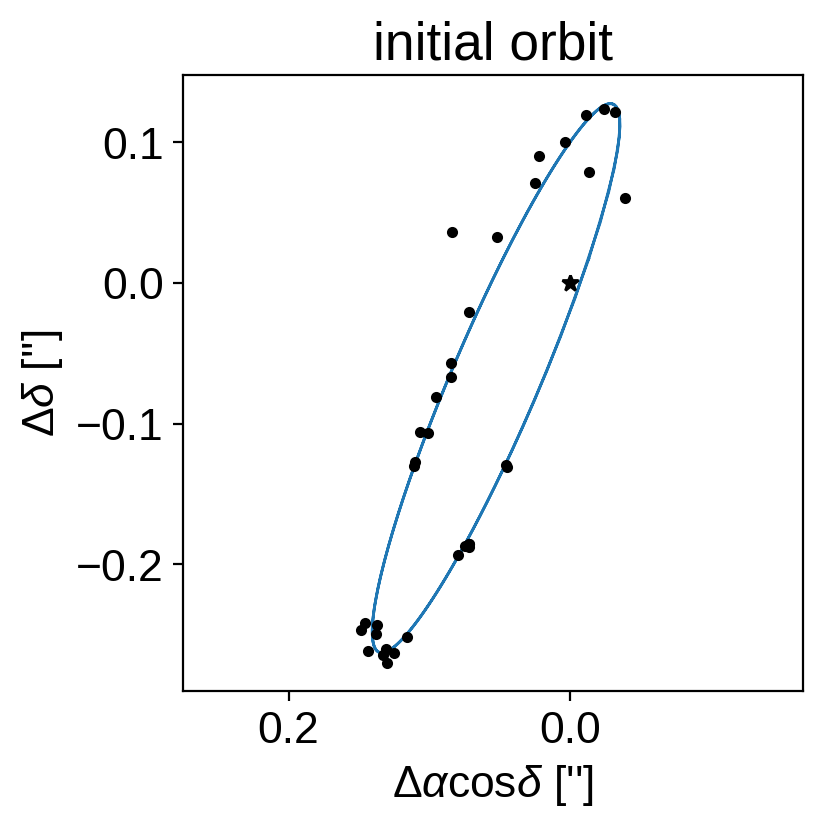

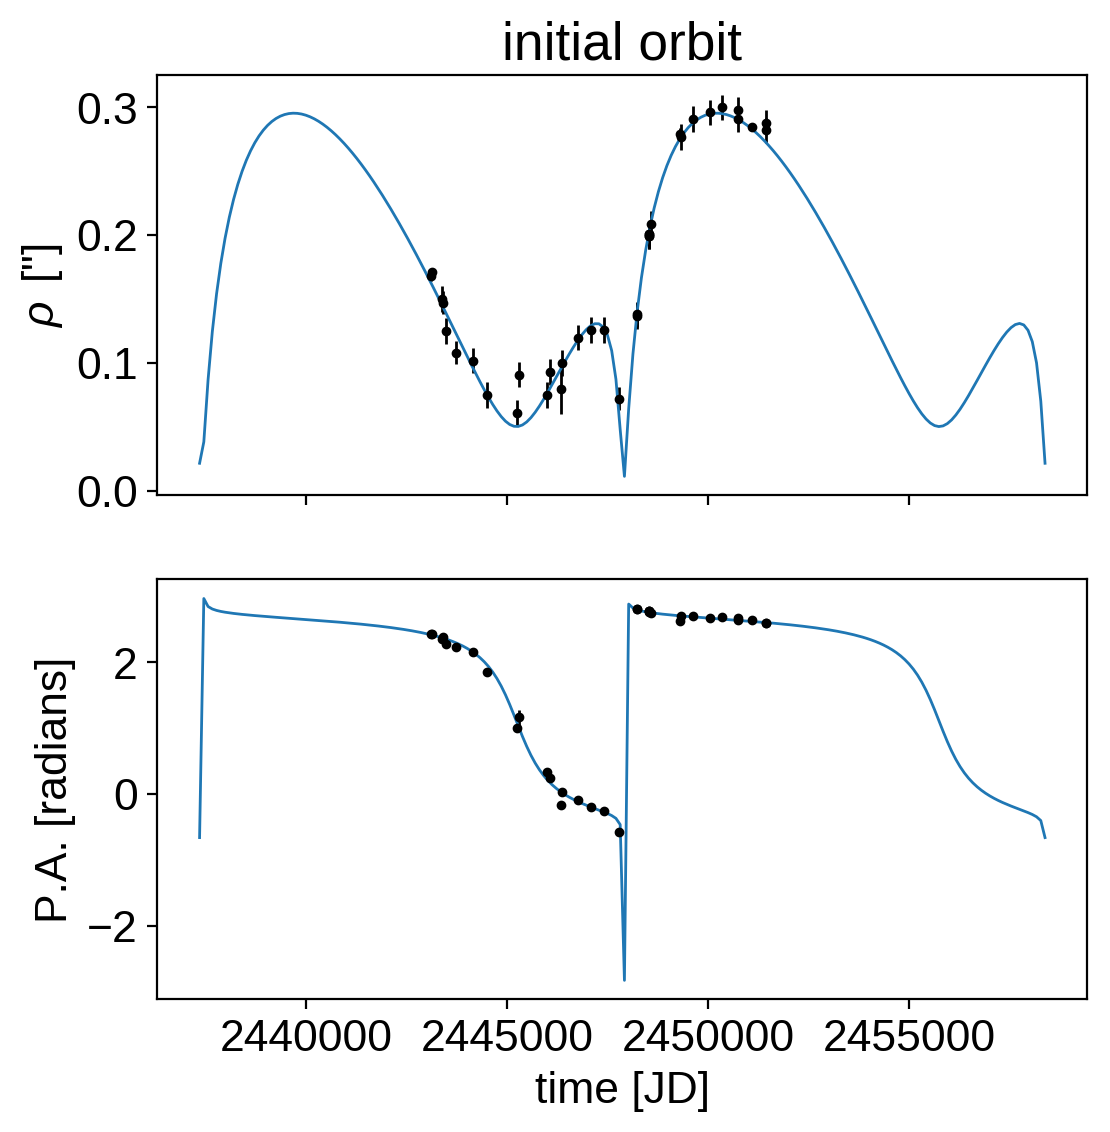

In [7]:
import pymc3 as pm
import theano
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg
P = 28.8 * 365.25  # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200)  # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
ax[1].set_xlabel("time [JD]");

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal("logP", mu=np.log(25 * yr), sd=10.0, testval=np.log(28.8 * yr))
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5 * (Omega0 + omega0))
        m = Angle("m", testval=0.5 * (Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2 * np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform("cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg))
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal("log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0)
        log_theta_s = pm.Normal("log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0)
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)

    return model, map_soln


model, map_soln = get_model()

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.048555e+02]

1it [00:00, 406.54it/s, logp=1.048555e+02]

2it [00:00, 581.90it/s, logp=1.048555e+02]

3it [00:00, 613.98it/s, logp=1.448865e+02]

4it [00:00, 615.56it/s, logp=1.056457e+02]

5it [00:00, 662.11it/s, logp=1.457994e+02]

6it [00:00, 677.65it/s, logp=1.469999e+02]

7it [00:00, 687.69it/s, logp=1.471434e+02]

8it [00:00, 697.96it/s, logp=1.471440e+02]

9it [00:00, 710.95it/s, logp=1.471440e+02]

10it [00:00, 733.73it/s, logp=1.471440e+02]

11it [00:05,  1.84it/s, logp=1.471440e+02] 


message: Optimization terminated successfully.
logp: 104.85554109304441 -> 147.14399186005338


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.471440e+02]

1it [00:00, 378.21it/s, logp=1.471440e+02]

2it [00:00, 500.07it/s, logp=1.471440e+02]

3it [00:00, 545.52it/s, logp=-1.185831e+04]

4it [00:00, 589.50it/s, logp=1.471671e+02] 

5it [00:00, 605.38it/s, logp=1.472136e+02]

6it [00:00, 637.63it/s, logp=1.473986e+02]

7it [00:00, 655.90it/s, logp=1.481189e+02]

8it [00:00, 673.35it/s, logp=1.507231e+02]

9it [00:00, 633.51it/s, logp=1.565965e+02]

10it [00:00, 514.46it/s, logp=1.634911e+02]

11it [00:00, 531.90it/s, logp=1.666396e+02]

12it [00:00, 552.77it/s, logp=1.675455e+02]

13it [00:00, 570.92it/s, logp=1.676215e+02]

14it [00:00, 583.71it/s, logp=1.676248e+02]

15it [00:00, 598.58it/s, logp=1.676282e+02]

16it [00:00, 611.51it/s, logp=1.676337e+02]

17it [00:00, 625.59it/s, logp=1.676403e+02]

18it [00:00, 637.13it/s, logp=1.676419e+02]

19it [00:00, 575.72it/s, logp=1.676422e+02]

20it [00:00, 573.04it/s, logp=1.676422e+02]

21it [00:00, 576.13it/s, logp=1.676422e+02]

22it [00:00, 576.84it/s, logp=1.676422e+02]

23it [00:00, 26.45it/s, logp=1.676422e+02] 


message: Optimization terminated successfully.
logp: 147.14399186005338 -> 167.64220598197195


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.676422e+02]

1it [00:00, 278.84it/s, logp=1.676422e+02]

2it [00:00, 376.31it/s, logp=1.676422e+02]

3it [00:00, 415.61it/s, logp=-4.521021e+03]

4it [00:00, 452.62it/s, logp=1.682354e+02] 

5it [00:00, 460.62it/s, logp=1.667490e+02]

6it [00:00, 482.61it/s, logp=1.683674e+02]

7it [00:00, 494.23it/s, logp=1.686220e+02]

8it [00:00, 508.11it/s, logp=1.694033e+02]

9it [00:00, 513.21it/s, logp=1.714304e+02]

10it [00:00, 522.92it/s, logp=1.784310e+02]

11it [00:00, 525.43it/s, logp=1.921973e+02]

12it [00:00, 531.19it/s, logp=1.936845e+02]

13it [00:00, 535.29it/s, logp=1.964254e+02]

14it [00:00, 539.45it/s, logp=2.010939e+02]

15it [00:00, 542.98it/s, logp=2.074741e+02]

16it [00:00, 546.67it/s, logp=2.094264e+02]

17it [00:00, 549.45it/s, logp=2.098562e+02]

18it [00:00, 549.56it/s, logp=2.098999e+02]

19it [00:00, 550.73it/s, logp=2.099152e+02]

20it [00:00, 552.06it/s, logp=2.099416e+02]

21it [00:00, 551.50it/s, logp=2.099853e+02]

22it [00:00, 553.72it/s, logp=2.100398e+02]

23it [00:00, 556.34it/s, logp=2.100552e+02]

24it [00:00, 555.63it/s, logp=2.100609e+02]

25it [00:00, 557.71it/s, logp=2.100614e+02]

26it [00:00, 558.94it/s, logp=2.100617e+02]

27it [00:00, 561.01it/s, logp=2.100622e+02]

28it [00:00, 561.93it/s, logp=2.100629e+02]

29it [00:00, 563.33it/s, logp=2.100633e+02]

30it [00:00, 564.18it/s, logp=2.100634e+02]

31it [00:00, 565.50it/s, logp=2.100634e+02]

32it [00:00, 566.36it/s, logp=2.100634e+02]

33it [00:00, 567.81it/s, logp=2.100634e+02]

34it [00:00, 568.29it/s, logp=2.100634e+02]

35it [00:00, 42.73it/s, logp=2.100634e+02] 


message: Optimization terminated successfully.
logp: 167.64220598197198 -> 210.06340668297906


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.100634e+02]

1it [00:00, 279.43it/s, logp=2.100634e+02]

2it [00:00, 384.68it/s, logp=2.100634e+02]

3it [00:00, 439.99it/s, logp=-4.378171e+03]

4it [00:00, 479.06it/s, logp=2.102114e+02] 

5it [00:00, 495.02it/s, logp=2.103607e+02]

6it [00:00, 502.81it/s, logp=2.104883e+02]

7it [00:00, 514.12it/s, logp=2.105011e+02]

8it [00:00, 514.21it/s, logp=2.105011e+02]

9it [00:00, 523.53it/s, logp=2.105014e+02]

10it [00:00, 513.41it/s, logp=2.105014e+02]

11it [00:00, 513.38it/s, logp=2.105014e+02]

12it [00:00, 13.90it/s, logp=2.105014e+02] 


message: Optimization terminated successfully.
logp: 210.0634066829791 -> 210.5013698914921


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.105014e+02]

1it [00:00, 333.30it/s, logp=2.105014e+02]

2it [00:00, 330.30it/s, logp=2.105014e+02]

3it [00:00, 333.11it/s, logp=-4.041226e+03]

4it [00:00, 344.78it/s, logp=2.124628e+02] 

5it [00:00, 332.52it/s, logp=1.648448e+02]

6it [00:00, 341.58it/s, logp=2.125361e+02]

7it [00:00, 348.84it/s, logp=2.126469e+02]

8it [00:00, 351.62it/s, logp=2.128268e+02]

9it [00:00, 349.65it/s, logp=2.130889e+02]

10it [00:00, 354.71it/s, logp=2.132127e+02]

11it [00:00, 360.53it/s, logp=2.131910e+02]

12it [00:00, 367.40it/s, logp=2.132712e+02]

13it [00:00, 367.17it/s, logp=2.133790e+02]

14it [00:00, 369.67it/s, logp=2.135772e+02]

15it [00:00, 374.36it/s, logp=2.139432e+02]

16it [00:00, 374.90it/s, logp=2.145105e+02]

17it [00:00, 375.64it/s, logp=2.146599e+02]

18it [00:00, 377.72it/s, logp=2.148474e+02]

19it [00:00, 381.33it/s, logp=2.149170e+02]

20it [00:00, 376.52it/s, logp=2.149377e+02]

21it [00:00, 373.83it/s, logp=2.149628e+02]

22it [00:00, 371.11it/s, logp=2.149864e+02]

23it [00:00, 370.26it/s, logp=2.150041e+02]

24it [00:00, 368.33it/s, logp=2.150108e+02]

25it [00:00, 365.91it/s, logp=2.150182e+02]

26it [00:00, 365.27it/s, logp=2.150205e+02]

27it [00:00, 363.75it/s, logp=2.150210e+02]

28it [00:00, 363.63it/s, logp=2.150212e+02]

29it [00:00, 364.81it/s, logp=2.150212e+02]

30it [00:00, 366.60it/s, logp=2.150212e+02]

31it [00:00, 368.02it/s, logp=2.150212e+02]

32it [00:00, 369.50it/s, logp=2.150212e+02]

33it [00:00, 371.51it/s, logp=2.150212e+02]

34it [00:00, 372.16it/s, logp=2.150212e+02]

35it [00:00, 372.65it/s, logp=2.150212e+02]

36it [00:00, 374.67it/s, logp=2.150212e+02]

37it [00:00, 376.52it/s, logp=2.150212e+02]

38it [00:00, 378.68it/s, logp=2.150212e+02]

39it [00:00, 385.06it/s, logp=2.150212e+02]

39it [00:00, 385.06it/s, logp=2.150212e+02]

40it [00:00, 385.06it/s, logp=2.150212e+02]

41it [00:00, 385.06it/s, logp=2.150212e+02]

42it [00:00, 385.06it/s, logp=2.150212e+02]

43it [00:00, 385.06it/s, logp=2.150212e+02]

44it [00:00, 385.06it/s, logp=2.150212e+02]

45it [00:00, 385.06it/s, logp=2.150212e+02]

46it [00:00, 385.06it/s, logp=2.150212e+02]

47it [00:00, 385.06it/s, logp=2.150212e+02]

48it [00:00, 385.06it/s, logp=2.150212e+02]

49it [00:00, 385.06it/s, logp=2.150212e+02]

50it [00:00, 385.06it/s, logp=2.150212e+02]

51it [00:00, 385.06it/s, logp=2.150212e+02]

52it [00:00, 385.06it/s, logp=2.150212e+02]

53it [00:00, 385.06it/s, logp=2.150212e+02]

54it [00:00, 385.06it/s, logp=2.150212e+02]

55it [00:00, 385.06it/s, logp=2.150212e+02]

56it [00:00, 385.06it/s, logp=2.150212e+02]

57it [00:00, 385.06it/s, logp=2.150212e+02]

58it [00:00, 385.06it/s, logp=2.150212e+02]

59it [00:00, 385.06it/s, logp=2.150212e+02]

60it [00:00, 385.06it/s, logp=2.150212e+02]

61it [00:00, 385.06it/s, logp=2.150212e+02]

62it [00:00, 385.06it/s, logp=2.150212e+02]

63it [00:00, 385.06it/s, logp=2.150212e+02]

64it [00:00, 385.06it/s, logp=2.150212e+02]

65it [00:00, 385.06it/s, logp=2.150212e+02]

66it [00:00, 385.06it/s, logp=2.150212e+02]

67it [00:00, 385.06it/s, logp=2.150212e+02]

68it [00:00, 385.06it/s, logp=2.150212e+02]

69it [00:00, 385.06it/s, logp=2.150212e+02]

70it [00:00, 385.06it/s, logp=2.150212e+02]

71it [00:00, 385.06it/s, logp=2.150212e+02]

72it [00:00, 385.06it/s, logp=2.150212e+02]

73it [00:00, 385.06it/s, logp=2.150212e+02]

74it [00:00, 385.06it/s, logp=2.150212e+02]

75it [00:00, 385.06it/s, logp=2.150212e+02]

76it [00:00, 385.06it/s, logp=2.150212e+02]

77it [00:00, 385.06it/s, logp=2.150212e+02]

78it [00:00, 385.06it/s, logp=2.150212e+02]

79it [00:00, 385.06it/s, logp=2.150212e+02]

80it [00:00, 385.06it/s, logp=2.150212e+02]

81it [00:00, 385.06it/s, logp=2.150212e+02]

82it [00:00, 396.12it/s, logp=2.150212e+02]

82it [00:00, 396.12it/s, logp=2.150212e+02]

83it [00:00, 396.12it/s, logp=2.150212e+02]

84it [00:00, 396.12it/s, logp=2.150212e+02]

85it [00:00, 396.12it/s, logp=2.150212e+02]

86it [00:00, 396.12it/s, logp=2.150212e+02]

87it [00:00, 396.12it/s, logp=2.150212e+02]

88it [00:00, 396.12it/s, logp=2.150212e+02]

89it [00:00, 396.12it/s, logp=2.150212e+02]

90it [00:00, 396.12it/s, logp=2.150212e+02]

91it [00:00, 396.12it/s, logp=2.150212e+02]

92it [00:00, 396.12it/s, logp=2.150212e+02]

93it [00:00, 396.12it/s, logp=2.150212e+02]

94it [00:00, 396.12it/s, logp=2.150212e+02]

95it [00:00, 396.12it/s, logp=2.150212e+02]

96it [00:00, 396.12it/s, logp=2.150212e+02]

97it [00:00, 396.12it/s, logp=2.150212e+02]

98it [00:00, 396.12it/s, logp=2.150212e+02]

99it [00:00, 396.12it/s, logp=2.150212e+02]

100it [00:00, 396.12it/s, logp=2.150212e+02]

101it [00:00, 396.12it/s, logp=2.150212e+02]

102it [00:00, 396.12it/s, logp=2.150212e+02]

103it [00:00, 113.53it/s, logp=2.150212e+02]


message: Optimization terminated successfully.
logp: 210.5013698914921 -> 215.02117742211766


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

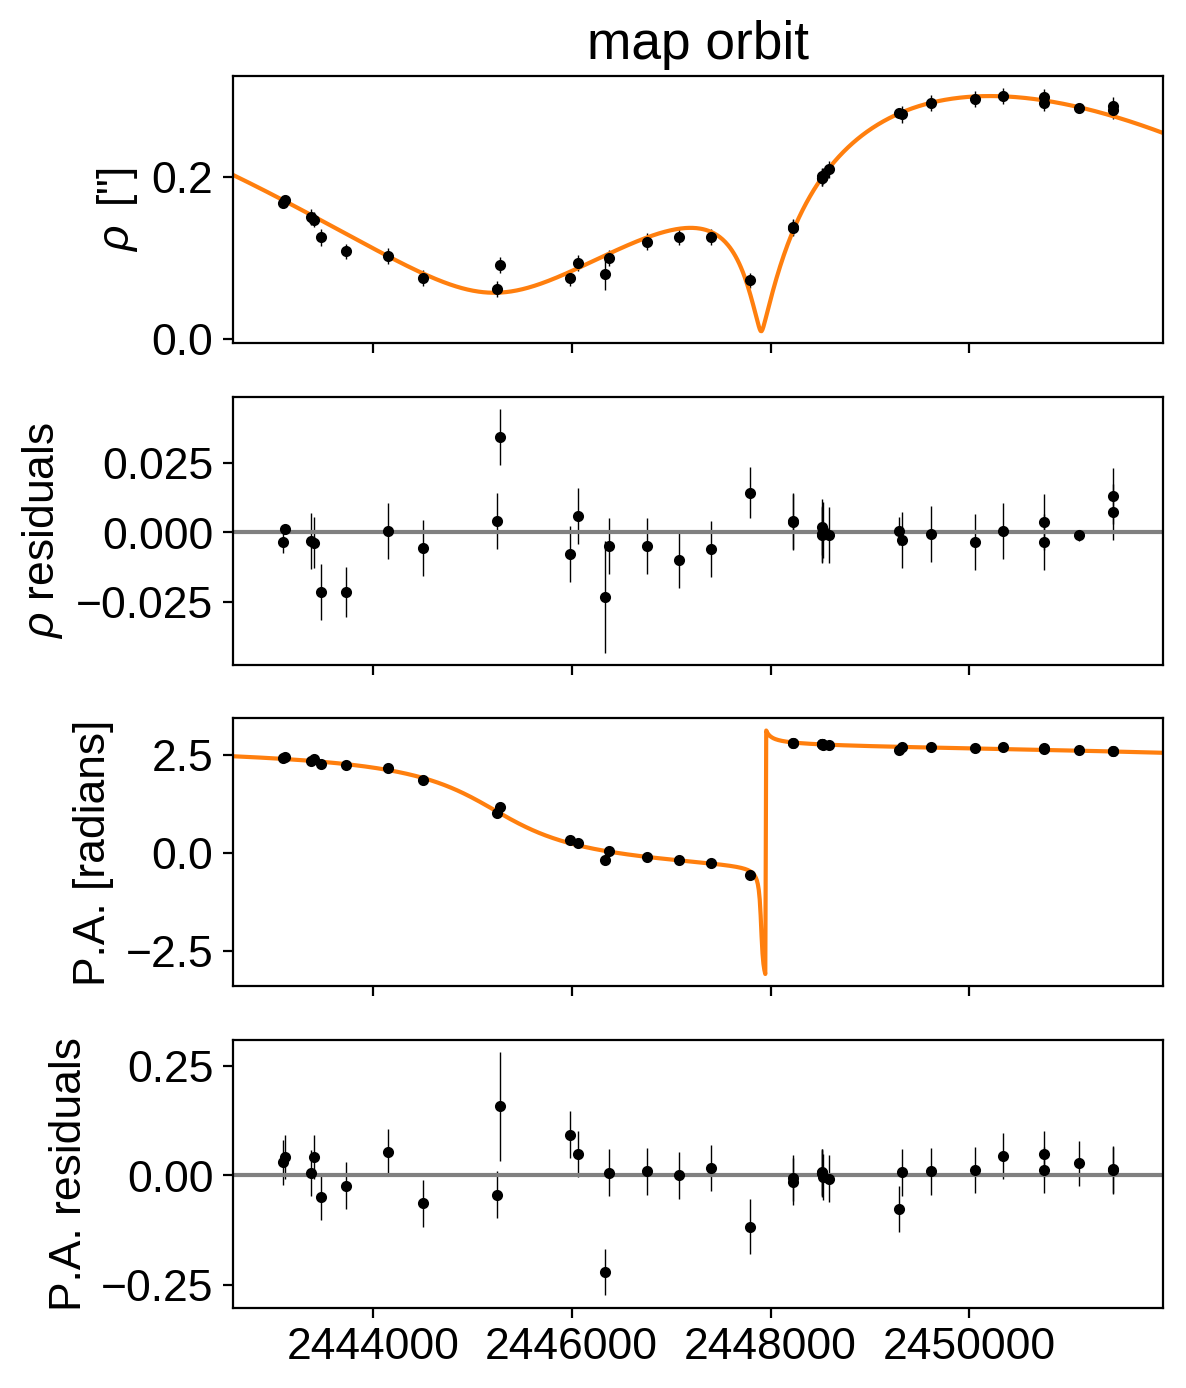

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("map orbit");

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
with model:
    trace = pm.sample(
        tune=5000,
        draws=4000,
        start=map_soln,
        step=xo.get_dense_nuts_step(target_accept=0.9, adaptation_window=201),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 4 chains:   0%|          | 0/36000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 13/36000 [00:00<05:35, 107.32draws/s]

Sampling 4 chains:   0%|          | 18/36000 [00:00<07:40, 78.08draws/s] 

Sampling 4 chains:   0%|          | 22/36000 [00:00<10:26, 57.46draws/s]

Sampling 4 chains:   0%|          | 26/36000 [00:00<12:22, 48.44draws/s]

Sampling 4 chains:   0%|          | 31/36000 [00:00<13:12, 45.38draws/s]

Sampling 4 chains:   0%|          | 35/36000 [00:00<14:54, 40.20draws/s]

Sampling 4 chains:   0%|          | 39/36000 [00:00<15:10, 39.52draws/s]

Sampling 4 chains:   0%|          | 45/36000 [00:00<13:56, 43.00draws/s]

Sampling 4 chains:   0%|          | 50/36000 [00:01<13:23, 44.74draws/s]

Sampling 4 chains:   0%|          | 56/36000 [00:01<13:26, 44.56draws/s]

Sampling 4 chains:   0%|          | 61/36000 [00:01<14:16, 41.98draws/s]

Sampling 4 chains:   0%|          | 66/36000 [00:01<14:05, 42.51draws/s]

Sampling 4 chains:   0%|          | 72/36000 [00:01<14:13, 42.09draws/s]

Sampling 4 chains:   0%|          | 77/36000 [00:01<14:04, 42.53draws/s]

Sampling 4 chains:   0%|          | 82/36000 [00:01<13:27, 44.50draws/s]

Sampling 4 chains:   0%|          | 87/36000 [00:01<13:16, 45.11draws/s]

Sampling 4 chains:   0%|          | 92/36000 [00:01<13:32, 44.21draws/s]

Sampling 4 chains:   0%|          | 97/36000 [00:02<13:50, 43.21draws/s]

Sampling 4 chains:   0%|          | 102/36000 [00:02<13:24, 44.63draws/s]

Sampling 4 chains:   0%|          | 108/36000 [00:02<13:02, 45.85draws/s]

Sampling 4 chains:   0%|          | 113/36000 [00:02<14:17, 41.84draws/s]

Sampling 4 chains:   0%|          | 118/36000 [00:02<14:18, 41.79draws/s]

Sampling 4 chains:   0%|          | 123/36000 [00:02<14:21, 41.64draws/s]

Sampling 4 chains:   0%|          | 129/36000 [00:02<13:10, 45.35draws/s]

Sampling 4 chains:   0%|          | 136/36000 [00:02<12:09, 49.13draws/s]

Sampling 4 chains:   0%|          | 142/36000 [00:03<11:43, 50.98draws/s]

Sampling 4 chains:   0%|          | 148/36000 [00:03<13:15, 45.09draws/s]

Sampling 4 chains:   0%|          | 154/36000 [00:03<12:55, 46.20draws/s]

Sampling 4 chains:   0%|          | 160/36000 [00:03<13:23, 44.59draws/s]

Sampling 4 chains:   0%|          | 166/36000 [00:03<12:24, 48.13draws/s]

Sampling 4 chains:   0%|          | 171/36000 [00:03<12:27, 47.92draws/s]

Sampling 4 chains:   0%|          | 177/36000 [00:03<12:41, 47.07draws/s]

Sampling 4 chains:   1%|          | 184/36000 [00:03<11:45, 50.79draws/s]

Sampling 4 chains:   1%|          | 190/36000 [00:04<11:37, 51.33draws/s]

Sampling 4 chains:   1%|          | 196/36000 [00:04<12:35, 47.40draws/s]

Sampling 4 chains:   1%|          | 201/36000 [00:04<13:36, 43.82draws/s]

Sampling 4 chains:   1%|          | 206/36000 [00:04<13:10, 45.28draws/s]

Sampling 4 chains:   1%|          | 211/36000 [00:04<13:47, 43.27draws/s]

Sampling 4 chains:   1%|          | 216/36000 [00:04<13:49, 43.12draws/s]

Sampling 4 chains:   1%|          | 224/36000 [00:04<12:22, 48.15draws/s]

Sampling 4 chains:   1%|          | 230/36000 [00:04<12:06, 49.23draws/s]

Sampling 4 chains:   1%|          | 237/36000 [00:05<11:02, 53.98draws/s]

Sampling 4 chains:   1%|          | 243/36000 [00:05<10:49, 55.06draws/s]

Sampling 4 chains:   1%|          | 249/36000 [00:05<11:41, 50.98draws/s]

Sampling 4 chains:   1%|          | 255/36000 [00:05<11:48, 50.46draws/s]

Sampling 4 chains:   1%|          | 261/36000 [00:05<11:45, 50.68draws/s]

Sampling 4 chains:   1%|          | 267/36000 [00:05<11:42, 50.85draws/s]

Sampling 4 chains:   1%|          | 274/36000 [00:05<11:29, 51.81draws/s]

Sampling 4 chains:   1%|          | 280/36000 [00:05<11:29, 51.79draws/s]

Sampling 4 chains:   1%|          | 286/36000 [00:05<11:17, 52.73draws/s]

Sampling 4 chains:   1%|          | 292/36000 [00:06<12:24, 47.96draws/s]

Sampling 4 chains:   1%|          | 297/36000 [00:06<13:26, 44.27draws/s]

Sampling 4 chains:   1%|          | 304/36000 [00:06<12:27, 47.74draws/s]

Sampling 4 chains:   1%|          | 310/36000 [00:06<11:47, 50.47draws/s]

Sampling 4 chains:   1%|          | 319/36000 [00:06<10:35, 56.17draws/s]

Sampling 4 chains:   1%|          | 325/36000 [00:06<11:20, 52.43draws/s]

Sampling 4 chains:   1%|          | 331/36000 [00:06<11:44, 50.66draws/s]

Sampling 4 chains:   1%|          | 338/36000 [00:06<10:48, 55.01draws/s]

Sampling 4 chains:   1%|          | 344/36000 [00:07<11:20, 52.37draws/s]

Sampling 4 chains:   1%|          | 350/36000 [00:07<12:30, 47.49draws/s]

Sampling 4 chains:   1%|          | 358/36000 [00:07<11:22, 52.19draws/s]

Sampling 4 chains:   1%|          | 364/36000 [00:07<11:00, 53.93draws/s]

Sampling 4 chains:   1%|          | 372/36000 [00:07<10:33, 56.26draws/s]

Sampling 4 chains:   1%|          | 381/36000 [00:07<09:26, 62.85draws/s]

Sampling 4 chains:   1%|          | 388/36000 [00:07<10:30, 56.46draws/s]

Sampling 4 chains:   1%|          | 395/36000 [00:07<10:57, 54.16draws/s]

Sampling 4 chains:   1%|          | 401/36000 [00:08<11:44, 50.53draws/s]

Sampling 4 chains:   1%|          | 407/36000 [00:08<12:47, 46.40draws/s]

Sampling 4 chains:   1%|          | 412/36000 [00:08<12:57, 45.80draws/s]

Sampling 4 chains:   1%|          | 417/36000 [00:08<13:47, 42.99draws/s]

Sampling 4 chains:   1%|          | 422/36000 [00:08<13:40, 43.36draws/s]

Sampling 4 chains:   1%|          | 427/36000 [00:08<13:21, 44.37draws/s]

Sampling 4 chains:   1%|          | 432/36000 [00:08<13:23, 44.28draws/s]

Sampling 4 chains:   1%|          | 439/36000 [00:08<12:30, 47.36draws/s]

Sampling 4 chains:   1%|          | 444/36000 [00:09<14:23, 41.18draws/s]

Sampling 4 chains:   1%|          | 449/36000 [00:09<13:58, 42.39draws/s]

Sampling 4 chains:   1%|▏         | 456/36000 [00:09<13:10, 44.94draws/s]

Sampling 4 chains:   1%|▏         | 462/36000 [00:09<13:21, 44.34draws/s]

Sampling 4 chains:   1%|▏         | 468/36000 [00:09<12:35, 47.02draws/s]

Sampling 4 chains:   1%|▏         | 473/36000 [00:09<12:25, 47.63draws/s]

Sampling 4 chains:   1%|▏         | 478/36000 [00:09<12:26, 47.62draws/s]

Sampling 4 chains:   1%|▏         | 483/36000 [00:09<12:45, 46.38draws/s]

Sampling 4 chains:   1%|▏         | 490/36000 [00:10<11:37, 50.90draws/s]

Sampling 4 chains:   1%|▏         | 497/36000 [00:10<11:10, 52.94draws/s]

Sampling 4 chains:   1%|▏         | 503/36000 [00:10<11:22, 52.03draws/s]

Sampling 4 chains:   1%|▏         | 509/36000 [00:10<11:31, 51.36draws/s]

Sampling 4 chains:   1%|▏         | 515/36000 [00:10<11:36, 50.94draws/s]

Sampling 4 chains:   1%|▏         | 521/36000 [00:10<11:28, 51.50draws/s]

Sampling 4 chains:   1%|▏         | 527/36000 [00:10<11:51, 49.84draws/s]

Sampling 4 chains:   1%|▏         | 534/36000 [00:10<11:05, 53.27draws/s]

Sampling 4 chains:   2%|▏         | 540/36000 [00:10<10:45, 54.96draws/s]

Sampling 4 chains:   2%|▏         | 546/36000 [00:11<10:39, 55.45draws/s]

Sampling 4 chains:   2%|▏         | 554/36000 [00:11<10:49, 54.54draws/s]

Sampling 4 chains:   2%|▏         | 560/36000 [00:11<10:38, 55.53draws/s]

Sampling 4 chains:   2%|▏         | 566/36000 [00:11<12:33, 47.05draws/s]

Sampling 4 chains:   2%|▏         | 571/36000 [00:11<12:32, 47.07draws/s]

Sampling 4 chains:   2%|▏         | 577/36000 [00:11<11:44, 50.28draws/s]

Sampling 4 chains:   2%|▏         | 583/36000 [00:11<12:41, 46.52draws/s]

Sampling 4 chains:   2%|▏         | 589/36000 [00:12<12:42, 46.45draws/s]

Sampling 4 chains:   2%|▏         | 595/36000 [00:12<12:27, 47.37draws/s]

Sampling 4 chains:   2%|▏         | 603/36000 [00:12<10:56, 53.92draws/s]

Sampling 4 chains:   2%|▏         | 609/36000 [00:12<12:34, 46.90draws/s]

Sampling 4 chains:   2%|▏         | 617/36000 [00:12<12:05, 48.80draws/s]

Sampling 4 chains:   2%|▏         | 623/36000 [00:12<12:42, 46.42draws/s]

Sampling 4 chains:   2%|▏         | 631/36000 [00:12<11:48, 49.93draws/s]

Sampling 4 chains:   2%|▏         | 637/36000 [00:12<11:54, 49.50draws/s]

Sampling 4 chains:   2%|▏         | 643/36000 [00:13<11:49, 49.83draws/s]

Sampling 4 chains:   2%|▏         | 649/36000 [00:13<12:07, 48.60draws/s]

Sampling 4 chains:   2%|▏         | 655/36000 [00:13<11:31, 51.14draws/s]

Sampling 4 chains:   2%|▏         | 661/36000 [00:13<11:53, 49.53draws/s]

Sampling 4 chains:   2%|▏         | 667/36000 [00:13<12:43, 46.30draws/s]

Sampling 4 chains:   2%|▏         | 672/36000 [00:13<13:04, 45.05draws/s]

Sampling 4 chains:   2%|▏         | 679/36000 [00:13<11:45, 50.06draws/s]

Sampling 4 chains:   2%|▏         | 685/36000 [00:13<12:09, 48.44draws/s]

Sampling 4 chains:   2%|▏         | 692/36000 [00:14<11:34, 50.83draws/s]

Sampling 4 chains:   2%|▏         | 698/36000 [00:14<11:25, 51.52draws/s]

Sampling 4 chains:   2%|▏         | 707/36000 [00:14<10:02, 58.59draws/s]

Sampling 4 chains:   2%|▏         | 716/36000 [00:14<09:28, 62.08draws/s]

Sampling 4 chains:   2%|▏         | 723/36000 [00:14<09:22, 62.71draws/s]

Sampling 4 chains:   2%|▏         | 730/36000 [00:14<10:25, 56.42draws/s]

Sampling 4 chains:   2%|▏         | 737/36000 [00:14<10:25, 56.40draws/s]

Sampling 4 chains:   2%|▏         | 745/36000 [00:14<10:03, 58.41draws/s]

Sampling 4 chains:   2%|▏         | 752/36000 [00:15<10:29, 56.03draws/s]

Sampling 4 chains:   2%|▏         | 758/36000 [00:15<10:55, 53.78draws/s]

Sampling 4 chains:   2%|▏         | 764/36000 [00:15<11:41, 50.23draws/s]

Sampling 4 chains:   2%|▏         | 770/36000 [00:15<12:09, 48.28draws/s]

Sampling 4 chains:   2%|▏         | 777/36000 [00:15<11:19, 51.84draws/s]

Sampling 4 chains:   2%|▏         | 784/36000 [00:15<11:19, 51.86draws/s]

Sampling 4 chains:   2%|▏         | 793/36000 [00:15<09:57, 58.93draws/s]

Sampling 4 chains:   2%|▏         | 800/36000 [00:15<10:03, 58.28draws/s]

Sampling 4 chains:   2%|▏         | 807/36000 [00:16<09:56, 58.99draws/s]

Sampling 4 chains:   2%|▏         | 814/36000 [00:16<09:31, 61.60draws/s]

Sampling 4 chains:   2%|▏         | 822/36000 [00:16<08:55, 65.75draws/s]

Sampling 4 chains:   2%|▏         | 844/36000 [00:16<07:04, 82.90draws/s]

Sampling 4 chains:   2%|▏         | 863/36000 [00:16<05:53, 99.35draws/s]

Sampling 4 chains:   2%|▏         | 877/36000 [00:16<05:46, 101.28draws/s]

Sampling 4 chains:   2%|▏         | 893/36000 [00:16<05:10, 113.12draws/s]

Sampling 4 chains:   3%|▎         | 908/36000 [00:16<04:50, 120.68draws/s]

Sampling 4 chains:   3%|▎         | 926/36000 [00:16<04:21, 133.88draws/s]

Sampling 4 chains:   3%|▎         | 949/36000 [00:16<03:50, 152.12draws/s]

Sampling 4 chains:   3%|▎         | 984/36000 [00:17<03:11, 183.07draws/s]

Sampling 4 chains:   3%|▎         | 1017/36000 [00:17<02:45, 210.90draws/s]

Sampling 4 chains:   3%|▎         | 1059/36000 [00:17<02:21, 247.65draws/s]

Sampling 4 chains:   3%|▎         | 1099/36000 [00:17<02:05, 279.12draws/s]

Sampling 4 chains:   3%|▎         | 1151/36000 [00:17<01:48, 321.08draws/s]

Sampling 4 chains:   3%|▎         | 1191/36000 [00:17<01:42, 339.12draws/s]

Sampling 4 chains:   3%|▎         | 1230/36000 [00:17<01:38, 352.13draws/s]

Sampling 4 chains:   4%|▎         | 1278/36000 [00:17<01:31, 381.23draws/s]

Sampling 4 chains:   4%|▎         | 1321/36000 [00:17<01:28, 391.64draws/s]

Sampling 4 chains:   4%|▍         | 1366/36000 [00:18<01:26, 402.11draws/s]

Sampling 4 chains:   4%|▍         | 1409/36000 [00:18<01:25, 406.67draws/s]

Sampling 4 chains:   4%|▍         | 1454/36000 [00:18<01:23, 414.48draws/s]

Sampling 4 chains:   4%|▍         | 1500/36000 [00:18<01:20, 427.13draws/s]

Sampling 4 chains:   4%|▍         | 1548/36000 [00:18<01:18, 441.20draws/s]

Sampling 4 chains:   4%|▍         | 1595/36000 [00:18<01:17, 446.73draws/s]

Sampling 4 chains:   5%|▍         | 1648/36000 [00:18<01:13, 467.91draws/s]

Sampling 4 chains:   5%|▍         | 1699/36000 [00:18<01:11, 476.85draws/s]

Sampling 4 chains:   5%|▍         | 1748/36000 [00:18<01:15, 456.06draws/s]

Sampling 4 chains:   5%|▍         | 1795/36000 [00:18<01:16, 449.07draws/s]

Sampling 4 chains:   5%|▌         | 1841/36000 [00:19<01:21, 418.30draws/s]

Sampling 4 chains:   5%|▌         | 1890/36000 [00:19<01:17, 437.44draws/s]

Sampling 4 chains:   5%|▌         | 1935/36000 [00:19<01:18, 432.97draws/s]

Sampling 4 chains:   5%|▌         | 1979/36000 [00:19<01:28, 385.87draws/s]

Sampling 4 chains:   6%|▌         | 2019/36000 [00:19<01:28, 383.04draws/s]

Sampling 4 chains:   6%|▌         | 2063/36000 [00:19<01:26, 394.40draws/s]

Sampling 4 chains:   6%|▌         | 2108/36000 [00:19<01:24, 401.92draws/s]

Sampling 4 chains:   6%|▌         | 2149/36000 [00:19<01:31, 370.43draws/s]

Sampling 4 chains:   6%|▌         | 2187/36000 [00:19<01:34, 359.08draws/s]

Sampling 4 chains:   6%|▌         | 2226/36000 [00:20<01:32, 366.94draws/s]

Sampling 4 chains:   6%|▋         | 2272/36000 [00:20<01:27, 385.38draws/s]

Sampling 4 chains:   6%|▋         | 2312/36000 [00:20<01:30, 374.25draws/s]

Sampling 4 chains:   7%|▋         | 2350/36000 [00:20<01:36, 350.00draws/s]

Sampling 4 chains:   7%|▋         | 2386/36000 [00:20<01:35, 352.54draws/s]

Sampling 4 chains:   7%|▋         | 2426/36000 [00:20<01:32, 363.78draws/s]

Sampling 4 chains:   7%|▋         | 2464/36000 [00:20<01:31, 368.40draws/s]

Sampling 4 chains:   7%|▋         | 2502/36000 [00:20<01:31, 366.38draws/s]

Sampling 4 chains:   7%|▋         | 2540/36000 [00:20<01:30, 368.15draws/s]

Sampling 4 chains:   7%|▋         | 2577/36000 [00:21<01:31, 367.18draws/s]

Sampling 4 chains:   7%|▋         | 2621/36000 [00:21<01:26, 384.12draws/s]

Sampling 4 chains:   7%|▋         | 2663/36000 [00:21<01:25, 389.10draws/s]

Sampling 4 chains:   8%|▊         | 2706/36000 [00:21<01:23, 399.94draws/s]

Sampling 4 chains:   8%|▊         | 2747/36000 [00:21<01:23, 398.26draws/s]

Sampling 4 chains:   8%|▊         | 2787/36000 [00:21<01:27, 378.36draws/s]

Sampling 4 chains:   8%|▊         | 2827/36000 [00:21<01:27, 379.87draws/s]

Sampling 4 chains:   8%|▊         | 2871/36000 [00:21<01:23, 394.92draws/s]

Sampling 4 chains:   8%|▊         | 2911/36000 [00:21<01:28, 375.93draws/s]

Sampling 4 chains:   8%|▊         | 2950/36000 [00:22<01:32, 357.63draws/s]

Sampling 4 chains:   8%|▊         | 2989/36000 [00:22<01:30, 363.75draws/s]

Sampling 4 chains:   8%|▊         | 3026/36000 [00:22<01:30, 363.96draws/s]

Sampling 4 chains:   9%|▊         | 3066/36000 [00:22<01:28, 371.50draws/s]

Sampling 4 chains:   9%|▊         | 3109/36000 [00:22<01:25, 384.19draws/s]

Sampling 4 chains:   9%|▉         | 3156/36000 [00:22<01:21, 404.35draws/s]

Sampling 4 chains:   9%|▉         | 3197/36000 [00:22<01:22, 398.85draws/s]

Sampling 4 chains:   9%|▉         | 3241/36000 [00:22<01:20, 405.40draws/s]

Sampling 4 chains:   9%|▉         | 3282/36000 [00:22<01:24, 387.62draws/s]

Sampling 4 chains:   9%|▉         | 3323/36000 [00:22<01:24, 386.31draws/s]

Sampling 4 chains:   9%|▉         | 3371/36000 [00:23<01:20, 407.17draws/s]

Sampling 4 chains:   9%|▉         | 3415/36000 [00:23<01:19, 409.56draws/s]

Sampling 4 chains:  10%|▉         | 3457/36000 [00:23<01:23, 389.01draws/s]

Sampling 4 chains:  10%|▉         | 3497/36000 [00:23<01:25, 379.57draws/s]

Sampling 4 chains:  10%|▉         | 3536/36000 [00:23<01:32, 350.63draws/s]

Sampling 4 chains:  10%|▉         | 3576/36000 [00:23<01:29, 363.09draws/s]

Sampling 4 chains:  10%|█         | 3618/36000 [00:23<01:26, 376.42draws/s]

Sampling 4 chains:  10%|█         | 3657/36000 [00:23<01:26, 375.10draws/s]

Sampling 4 chains:  10%|█         | 3695/36000 [00:23<01:27, 367.41draws/s]

Sampling 4 chains:  10%|█         | 3737/36000 [00:24<01:24, 380.81draws/s]

Sampling 4 chains:  11%|█         | 3784/36000 [00:24<01:20, 401.50draws/s]

Sampling 4 chains:  11%|█         | 3836/36000 [00:24<01:14, 429.22draws/s]

Sampling 4 chains:  11%|█         | 3886/36000 [00:24<01:11, 447.81draws/s]

Sampling 4 chains:  11%|█         | 3932/36000 [00:24<01:15, 424.27draws/s]

Sampling 4 chains:  11%|█         | 3976/36000 [00:24<01:16, 417.97draws/s]

Sampling 4 chains:  11%|█         | 4019/36000 [00:24<01:18, 408.83draws/s]

Sampling 4 chains:  11%|█▏        | 4061/36000 [00:24<01:17, 411.19draws/s]

Sampling 4 chains:  11%|█▏        | 4105/36000 [00:24<01:17, 413.63draws/s]

Sampling 4 chains:  12%|█▏        | 4152/36000 [00:25<01:14, 425.31draws/s]

Sampling 4 chains:  12%|█▏        | 4195/36000 [00:25<01:17, 408.22draws/s]

Sampling 4 chains:  12%|█▏        | 4237/36000 [00:25<01:17, 411.32draws/s]

Sampling 4 chains:  12%|█▏        | 4279/36000 [00:25<01:23, 381.71draws/s]

Sampling 4 chains:  12%|█▏        | 4318/36000 [00:25<01:25, 371.17draws/s]

Sampling 4 chains:  12%|█▏        | 4356/36000 [00:25<01:25, 369.53draws/s]

Sampling 4 chains:  12%|█▏        | 4397/36000 [00:25<01:23, 380.31draws/s]

Sampling 4 chains:  12%|█▏        | 4436/36000 [00:25<01:25, 368.20draws/s]

Sampling 4 chains:  12%|█▏        | 4474/36000 [00:25<01:24, 371.09draws/s]

Sampling 4 chains:  13%|█▎        | 4521/36000 [00:25<01:19, 393.99draws/s]

Sampling 4 chains:  13%|█▎        | 4563/36000 [00:26<01:18, 400.77draws/s]

Sampling 4 chains:  13%|█▎        | 4605/36000 [00:26<01:18, 400.20draws/s]

Sampling 4 chains:  13%|█▎        | 4646/36000 [00:26<01:20, 391.24draws/s]

Sampling 4 chains:  13%|█▎        | 4688/36000 [00:26<01:19, 395.64draws/s]

Sampling 4 chains:  13%|█▎        | 4728/36000 [00:26<01:22, 380.43draws/s]

Sampling 4 chains:  13%|█▎        | 4767/36000 [00:26<01:21, 383.16draws/s]

Sampling 4 chains:  13%|█▎        | 4816/36000 [00:26<01:16, 408.92draws/s]

Sampling 4 chains:  13%|█▎        | 4858/36000 [00:26<01:15, 411.01draws/s]

Sampling 4 chains:  14%|█▎        | 4900/36000 [00:26<01:19, 390.89draws/s]

Sampling 4 chains:  14%|█▎        | 4943/36000 [00:27<01:17, 400.81draws/s]

Sampling 4 chains:  14%|█▍        | 4984/36000 [00:27<01:16, 403.47draws/s]

Sampling 4 chains:  14%|█▍        | 5026/36000 [00:27<01:15, 407.71draws/s]

Sampling 4 chains:  14%|█▍        | 5072/36000 [00:27<01:13, 421.79draws/s]

Sampling 4 chains:  14%|█▍        | 5125/36000 [00:27<01:08, 447.87draws/s]

Sampling 4 chains:  14%|█▍        | 5171/36000 [00:27<01:08, 448.84draws/s]

Sampling 4 chains:  14%|█▍        | 5217/36000 [00:27<01:13, 418.45draws/s]

Sampling 4 chains:  15%|█▍        | 5260/36000 [00:27<01:18, 393.26draws/s]

Sampling 4 chains:  15%|█▍        | 5302/36000 [00:27<01:16, 400.73draws/s]

Sampling 4 chains:  15%|█▍        | 5343/36000 [00:28<01:16, 401.34draws/s]

Sampling 4 chains:  15%|█▍        | 5386/36000 [00:28<01:15, 405.90draws/s]

Sampling 4 chains:  15%|█▌        | 5427/36000 [00:28<01:15, 402.51draws/s]

Sampling 4 chains:  15%|█▌        | 5468/36000 [00:28<01:15, 404.44draws/s]

Sampling 4 chains:  15%|█▌        | 5509/36000 [00:28<01:15, 402.19draws/s]

Sampling 4 chains:  15%|█▌        | 5551/36000 [00:28<01:15, 404.72draws/s]

Sampling 4 chains:  16%|█▌        | 5592/36000 [00:28<01:15, 400.90draws/s]

Sampling 4 chains:  16%|█▌        | 5634/36000 [00:28<01:15, 403.12draws/s]

Sampling 4 chains:  16%|█▌        | 5675/36000 [00:28<01:18, 384.78draws/s]

Sampling 4 chains:  16%|█▌        | 5714/36000 [00:28<01:19, 379.46draws/s]

Sampling 4 chains:  16%|█▌        | 5754/36000 [00:29<01:20, 377.82draws/s]

Sampling 4 chains:  16%|█▌        | 5797/36000 [00:29<01:17, 388.86draws/s]

Sampling 4 chains:  16%|█▌        | 5837/36000 [00:29<01:21, 370.45draws/s]

Sampling 4 chains:  16%|█▋        | 5875/36000 [00:29<01:21, 371.35draws/s]

Sampling 4 chains:  16%|█▋        | 5915/36000 [00:29<01:19, 378.87draws/s]

Sampling 4 chains:  17%|█▋        | 5954/36000 [00:29<01:20, 375.53draws/s]

Sampling 4 chains:  17%|█▋        | 5992/36000 [00:29<01:22, 365.20draws/s]

Sampling 4 chains:  17%|█▋        | 6029/36000 [00:29<01:23, 356.91draws/s]

Sampling 4 chains:  17%|█▋        | 6074/36000 [00:29<01:18, 379.63draws/s]

Sampling 4 chains:  17%|█▋        | 6121/36000 [00:30<01:14, 398.57draws/s]

Sampling 4 chains:  17%|█▋        | 6165/36000 [00:30<01:13, 405.85draws/s]

Sampling 4 chains:  17%|█▋        | 6211/36000 [00:30<01:11, 418.33draws/s]

Sampling 4 chains:  17%|█▋        | 6254/36000 [00:30<01:11, 416.70draws/s]

Sampling 4 chains:  17%|█▋        | 6296/36000 [00:30<01:11, 414.26draws/s]

Sampling 4 chains:  18%|█▊        | 6340/36000 [00:30<01:10, 421.40draws/s]

Sampling 4 chains:  18%|█▊        | 6384/36000 [00:30<01:09, 425.05draws/s]

Sampling 4 chains:  18%|█▊        | 6427/36000 [00:30<01:12, 407.59draws/s]

Sampling 4 chains:  18%|█▊        | 6469/36000 [00:30<01:15, 390.03draws/s]

Sampling 4 chains:  18%|█▊        | 6509/36000 [00:30<01:15, 390.24draws/s]

Sampling 4 chains:  18%|█▊        | 6549/36000 [00:31<01:15, 391.53draws/s]

Sampling 4 chains:  18%|█▊        | 6589/36000 [00:31<01:19, 371.64draws/s]

Sampling 4 chains:  18%|█▊        | 6627/36000 [00:31<01:21, 359.71draws/s]

Sampling 4 chains:  19%|█▊        | 6664/36000 [00:31<01:26, 337.59draws/s]

Sampling 4 chains:  19%|█▊        | 6699/36000 [00:31<01:29, 326.25draws/s]

Sampling 4 chains:  19%|█▊        | 6733/36000 [00:31<01:30, 322.25draws/s]

Sampling 4 chains:  19%|█▉        | 6767/36000 [00:31<01:29, 325.89draws/s]

Sampling 4 chains:  19%|█▉        | 6806/36000 [00:31<01:26, 338.04draws/s]

Sampling 4 chains:  19%|█▉        | 6841/36000 [00:31<01:26, 338.38draws/s]

Sampling 4 chains:  19%|█▉        | 6878/36000 [00:32<01:24, 345.42draws/s]

Sampling 4 chains:  19%|█▉        | 6921/36000 [00:32<01:19, 365.26draws/s]

Sampling 4 chains:  19%|█▉        | 6958/36000 [00:32<01:21, 355.08draws/s]

Sampling 4 chains:  19%|█▉        | 7004/36000 [00:32<01:16, 377.43draws/s]

Sampling 4 chains:  20%|█▉        | 7043/36000 [00:32<01:17, 374.93draws/s]

Sampling 4 chains:  20%|█▉        | 7084/36000 [00:32<01:15, 384.33draws/s]

Sampling 4 chains:  20%|█▉        | 7124/36000 [00:32<01:14, 386.76draws/s]

Sampling 4 chains:  20%|█▉        | 7164/36000 [00:32<01:14, 385.63draws/s]

Sampling 4 chains:  20%|██        | 7203/36000 [00:32<01:14, 386.15draws/s]

Sampling 4 chains:  20%|██        | 7249/36000 [00:32<01:11, 404.24draws/s]

Sampling 4 chains:  20%|██        | 7290/36000 [00:33<01:10, 404.43draws/s]

Sampling 4 chains:  20%|██        | 7331/36000 [00:33<01:10, 403.92draws/s]

Sampling 4 chains:  20%|██        | 7379/36000 [00:33<01:08, 419.22draws/s]

Sampling 4 chains:  21%|██        | 7422/36000 [00:33<01:13, 388.85draws/s]

Sampling 4 chains:  21%|██        | 7462/36000 [00:33<01:13, 386.57draws/s]

Sampling 4 chains:  21%|██        | 7504/36000 [00:33<01:13, 387.29draws/s]

Sampling 4 chains:  21%|██        | 7545/36000 [00:33<01:12, 391.13draws/s]

Sampling 4 chains:  21%|██        | 7591/36000 [00:33<01:09, 408.53draws/s]

Sampling 4 chains:  21%|██        | 7633/36000 [00:33<01:12, 388.90draws/s]

Sampling 4 chains:  21%|██▏       | 7673/36000 [00:34<01:15, 373.49draws/s]

Sampling 4 chains:  21%|██▏       | 7718/36000 [00:34<01:11, 393.30draws/s]

Sampling 4 chains:  22%|██▏       | 7761/36000 [00:34<01:10, 402.75draws/s]

Sampling 4 chains:  22%|██▏       | 7802/36000 [00:34<01:16, 370.62draws/s]

Sampling 4 chains:  22%|██▏       | 7844/36000 [00:34<01:13, 380.67draws/s]

Sampling 4 chains:  22%|██▏       | 7883/36000 [00:34<01:13, 380.13draws/s]

Sampling 4 chains:  22%|██▏       | 7922/36000 [00:34<01:14, 374.97draws/s]

Sampling 4 chains:  22%|██▏       | 7960/36000 [00:34<01:15, 369.88draws/s]

Sampling 4 chains:  22%|██▏       | 8000/36000 [00:34<01:14, 374.02draws/s]

Sampling 4 chains:  22%|██▏       | 8038/36000 [00:35<01:15, 371.93draws/s]

Sampling 4 chains:  22%|██▏       | 8078/36000 [00:35<01:13, 379.61draws/s]

Sampling 4 chains:  23%|██▎       | 8127/36000 [00:35<01:08, 406.27draws/s]

Sampling 4 chains:  23%|██▎       | 8169/36000 [00:35<01:08, 408.99draws/s]

Sampling 4 chains:  23%|██▎       | 8213/36000 [00:35<01:06, 414.81draws/s]

Sampling 4 chains:  23%|██▎       | 8261/36000 [00:35<01:04, 431.77draws/s]

Sampling 4 chains:  23%|██▎       | 8305/36000 [00:35<01:06, 414.40draws/s]

Sampling 4 chains:  23%|██▎       | 8347/36000 [00:35<01:10, 393.73draws/s]

Sampling 4 chains:  23%|██▎       | 8387/36000 [00:35<01:13, 374.69draws/s]

Sampling 4 chains:  23%|██▎       | 8429/36000 [00:36<01:12, 380.21draws/s]

Sampling 4 chains:  24%|██▎       | 8468/36000 [00:36<01:14, 370.91draws/s]

Sampling 4 chains:  24%|██▎       | 8509/36000 [00:36<01:12, 381.21draws/s]

Sampling 4 chains:  24%|██▍       | 8558/36000 [00:36<01:07, 407.08draws/s]

Sampling 4 chains:  24%|██▍       | 8600/36000 [00:36<01:06, 410.07draws/s]

Sampling 4 chains:  24%|██▍       | 8652/36000 [00:36<01:02, 436.72draws/s]

Sampling 4 chains:  24%|██▍       | 8697/36000 [00:36<01:03, 427.43draws/s]

Sampling 4 chains:  24%|██▍       | 8746/36000 [00:36<01:01, 441.60draws/s]

Sampling 4 chains:  24%|██▍       | 8791/36000 [00:36<01:04, 420.19draws/s]

Sampling 4 chains:  25%|██▍       | 8838/36000 [00:36<01:02, 432.68draws/s]

Sampling 4 chains:  25%|██▍       | 8888/36000 [00:37<01:00, 448.40draws/s]

Sampling 4 chains:  25%|██▍       | 8934/36000 [00:37<01:03, 428.85draws/s]

Sampling 4 chains:  25%|██▍       | 8978/36000 [00:37<01:04, 417.58draws/s]

Sampling 4 chains:  25%|██▌       | 9021/36000 [00:37<01:05, 409.35draws/s]

Sampling 4 chains:  25%|██▌       | 9063/36000 [00:37<01:07, 398.00draws/s]

Sampling 4 chains:  25%|██▌       | 9104/36000 [00:37<01:09, 386.92draws/s]

Sampling 4 chains:  25%|██▌       | 9146/36000 [00:37<01:07, 395.29draws/s]

Sampling 4 chains:  26%|██▌       | 9189/36000 [00:37<01:06, 403.61draws/s]

Sampling 4 chains:  26%|██▌       | 9238/36000 [00:37<01:03, 424.42draws/s]

Sampling 4 chains:  26%|██▌       | 9284/36000 [00:38<01:01, 431.24draws/s]

Sampling 4 chains:  26%|██▌       | 9329/36000 [00:38<01:01, 432.56draws/s]

Sampling 4 chains:  26%|██▌       | 9374/36000 [00:38<01:01, 436.14draws/s]

Sampling 4 chains:  26%|██▌       | 9420/36000 [00:38<01:00, 441.59draws/s]

Sampling 4 chains:  26%|██▋       | 9465/36000 [00:38<01:05, 404.66draws/s]

Sampling 4 chains:  26%|██▋       | 9507/36000 [00:38<01:07, 390.78draws/s]

Sampling 4 chains:  27%|██▋       | 9550/36000 [00:38<01:05, 400.78draws/s]

Sampling 4 chains:  27%|██▋       | 9600/36000 [00:38<01:01, 425.96draws/s]

Sampling 4 chains:  27%|██▋       | 9650/36000 [00:38<00:59, 445.64draws/s]

Sampling 4 chains:  27%|██▋       | 9696/36000 [00:38<01:00, 434.56draws/s]

Sampling 4 chains:  27%|██▋       | 9741/36000 [00:39<01:04, 408.74draws/s]

Sampling 4 chains:  27%|██▋       | 9783/36000 [00:39<01:06, 391.84draws/s]

Sampling 4 chains:  27%|██▋       | 9827/36000 [00:39<01:04, 404.10draws/s]

Sampling 4 chains:  27%|██▋       | 9868/36000 [00:39<01:06, 394.26draws/s]

Sampling 4 chains:  28%|██▊       | 9908/36000 [00:39<01:08, 381.08draws/s]

Sampling 4 chains:  28%|██▊       | 9947/36000 [00:39<01:08, 382.66draws/s]

Sampling 4 chains:  28%|██▊       | 9987/36000 [00:39<01:07, 386.10draws/s]

Sampling 4 chains:  28%|██▊       | 10027/36000 [00:39<01:06, 389.62draws/s]

Sampling 4 chains:  28%|██▊       | 10067/36000 [00:39<01:09, 375.39draws/s]

Sampling 4 chains:  28%|██▊       | 10105/36000 [00:40<01:10, 365.16draws/s]

Sampling 4 chains:  28%|██▊       | 10148/36000 [00:40<01:08, 379.68draws/s]

Sampling 4 chains:  28%|██▊       | 10194/36000 [00:40<01:05, 396.46draws/s]

Sampling 4 chains:  28%|██▊       | 10237/36000 [00:40<01:03, 404.11draws/s]

Sampling 4 chains:  29%|██▊       | 10278/36000 [00:40<01:06, 385.03draws/s]

Sampling 4 chains:  29%|██▊       | 10317/36000 [00:40<01:09, 371.20draws/s]

Sampling 4 chains:  29%|██▉       | 10358/36000 [00:40<01:07, 380.29draws/s]

Sampling 4 chains:  29%|██▉       | 10397/36000 [00:40<01:10, 363.19draws/s]

Sampling 4 chains:  29%|██▉       | 10434/36000 [00:40<01:11, 359.38draws/s]

Sampling 4 chains:  29%|██▉       | 10471/36000 [00:41<01:10, 361.45draws/s]

Sampling 4 chains:  29%|██▉       | 10512/36000 [00:41<01:08, 371.02draws/s]

Sampling 4 chains:  29%|██▉       | 10550/36000 [00:41<01:09, 368.21draws/s]

Sampling 4 chains:  29%|██▉       | 10587/36000 [00:41<01:09, 363.07draws/s]

Sampling 4 chains:  30%|██▉       | 10631/36000 [00:41<01:06, 380.73draws/s]

Sampling 4 chains:  30%|██▉       | 10679/36000 [00:41<01:02, 404.88draws/s]

Sampling 4 chains:  30%|██▉       | 10728/36000 [00:41<00:59, 425.97draws/s]

Sampling 4 chains:  30%|██▉       | 10774/36000 [00:41<00:58, 433.52draws/s]

Sampling 4 chains:  30%|███       | 10821/36000 [00:41<00:56, 442.53draws/s]

Sampling 4 chains:  30%|███       | 10866/36000 [00:42<01:02, 401.69draws/s]

Sampling 4 chains:  30%|███       | 10910/36000 [00:42<01:01, 408.28draws/s]

Sampling 4 chains:  30%|███       | 10958/36000 [00:42<00:58, 425.87draws/s]

Sampling 4 chains:  31%|███       | 11002/36000 [00:42<00:58, 424.74draws/s]

Sampling 4 chains:  31%|███       | 11045/36000 [00:42<01:01, 408.50draws/s]

Sampling 4 chains:  31%|███       | 11087/36000 [00:42<01:05, 380.23draws/s]

Sampling 4 chains:  31%|███       | 11132/36000 [00:42<01:02, 397.51draws/s]

Sampling 4 chains:  31%|███       | 11175/36000 [00:42<01:01, 403.70draws/s]

Sampling 4 chains:  31%|███       | 11222/36000 [00:42<00:58, 421.23draws/s]

Sampling 4 chains:  31%|███▏      | 11271/36000 [00:42<00:56, 439.18draws/s]

Sampling 4 chains:  31%|███▏      | 11316/36000 [00:43<00:55, 442.13draws/s]

Sampling 4 chains:  32%|███▏      | 11362/36000 [00:43<00:55, 447.18draws/s]

Sampling 4 chains:  32%|███▏      | 11408/36000 [00:43<00:54, 447.15draws/s]

Sampling 4 chains:  32%|███▏      | 11453/36000 [00:43<00:56, 434.31draws/s]

Sampling 4 chains:  32%|███▏      | 11497/36000 [00:43<01:02, 393.68draws/s]

Sampling 4 chains:  32%|███▏      | 11538/36000 [00:43<01:06, 368.54draws/s]

Sampling 4 chains:  32%|███▏      | 11577/36000 [00:43<01:05, 373.41draws/s]

Sampling 4 chains:  32%|███▏      | 11616/36000 [00:43<01:06, 367.74draws/s]

Sampling 4 chains:  32%|███▏      | 11654/36000 [00:43<01:07, 362.14draws/s]

Sampling 4 chains:  32%|███▏      | 11694/36000 [00:44<01:05, 368.30draws/s]

Sampling 4 chains:  33%|███▎      | 11732/36000 [00:44<01:05, 369.09draws/s]

Sampling 4 chains:  33%|███▎      | 11779/36000 [00:44<01:01, 394.08draws/s]

Sampling 4 chains:  33%|███▎      | 11825/36000 [00:44<00:58, 409.80draws/s]

Sampling 4 chains:  33%|███▎      | 11867/36000 [00:44<00:59, 404.21draws/s]

Sampling 4 chains:  33%|███▎      | 11911/36000 [00:44<00:58, 412.81draws/s]

Sampling 4 chains:  33%|███▎      | 11953/36000 [00:44<01:00, 398.21draws/s]

Sampling 4 chains:  33%|███▎      | 11995/36000 [00:44<01:00, 399.86draws/s]

Sampling 4 chains:  33%|███▎      | 12039/36000 [00:44<00:58, 409.16draws/s]

Sampling 4 chains:  34%|███▎      | 12081/36000 [00:45<00:59, 401.60draws/s]

Sampling 4 chains:  34%|███▎      | 12122/36000 [00:45<01:00, 396.62draws/s]

Sampling 4 chains:  34%|███▍      | 12173/36000 [00:45<00:56, 422.94draws/s]

Sampling 4 chains:  34%|███▍      | 12217/36000 [00:45<00:55, 424.74draws/s]

Sampling 4 chains:  34%|███▍      | 12260/36000 [00:45<01:00, 392.33draws/s]

Sampling 4 chains:  34%|███▍      | 12301/36000 [00:45<01:02, 381.75draws/s]

Sampling 4 chains:  34%|███▍      | 12340/36000 [00:45<01:03, 374.96draws/s]

Sampling 4 chains:  34%|███▍      | 12385/36000 [00:45<01:00, 392.19draws/s]

Sampling 4 chains:  35%|███▍      | 12428/36000 [00:45<00:58, 401.86draws/s]

Sampling 4 chains:  35%|███▍      | 12473/36000 [00:45<00:56, 414.66draws/s]

Sampling 4 chains:  35%|███▍      | 12515/36000 [00:46<01:01, 379.57draws/s]

Sampling 4 chains:  35%|███▍      | 12554/36000 [00:46<01:04, 365.82draws/s]

Sampling 4 chains:  35%|███▍      | 12592/36000 [00:46<01:04, 363.83draws/s]

Sampling 4 chains:  35%|███▌      | 12633/36000 [00:46<01:02, 376.31draws/s]

Sampling 4 chains:  35%|███▌      | 12675/36000 [00:46<01:00, 383.41draws/s]

Sampling 4 chains:  35%|███▌      | 12722/36000 [00:46<00:58, 399.38draws/s]

Sampling 4 chains:  35%|███▌      | 12769/36000 [00:46<00:55, 415.23draws/s]

Sampling 4 chains:  36%|███▌      | 12811/36000 [00:46<00:55, 416.27draws/s]

Sampling 4 chains:  36%|███▌      | 12853/36000 [00:46<00:59, 389.19draws/s]

Sampling 4 chains:  36%|███▌      | 12893/36000 [00:47<01:02, 370.89draws/s]

Sampling 4 chains:  36%|███▌      | 12931/36000 [00:47<01:03, 365.18draws/s]

Sampling 4 chains:  36%|███▌      | 12968/36000 [00:47<01:04, 355.68draws/s]

Sampling 4 chains:  36%|███▌      | 13008/36000 [00:47<01:02, 366.87draws/s]

Sampling 4 chains:  36%|███▌      | 13048/36000 [00:47<01:01, 374.29draws/s]

Sampling 4 chains:  36%|███▋      | 13091/36000 [00:47<00:58, 389.23draws/s]

Sampling 4 chains:  36%|███▋      | 13136/36000 [00:47<00:56, 403.49draws/s]

Sampling 4 chains:  37%|███▋      | 13177/36000 [00:47<00:56, 403.93draws/s]

Sampling 4 chains:  37%|███▋      | 13218/36000 [00:47<00:58, 388.15draws/s]

Sampling 4 chains:  37%|███▋      | 13258/36000 [00:48<01:01, 370.35draws/s]

Sampling 4 chains:  37%|███▋      | 13296/36000 [00:48<01:01, 369.58draws/s]

Sampling 4 chains:  37%|███▋      | 13334/36000 [00:48<01:01, 369.61draws/s]

Sampling 4 chains:  37%|███▋      | 13372/36000 [00:48<01:00, 372.30draws/s]

Sampling 4 chains:  37%|███▋      | 13410/36000 [00:48<01:00, 373.55draws/s]

Sampling 4 chains:  37%|███▋      | 13452/36000 [00:48<00:58, 386.36draws/s]

Sampling 4 chains:  37%|███▋      | 13499/36000 [00:48<00:55, 405.20draws/s]

Sampling 4 chains:  38%|███▊      | 13550/36000 [00:48<00:52, 430.96draws/s]

Sampling 4 chains:  38%|███▊      | 13594/36000 [00:48<00:53, 421.07draws/s]

Sampling 4 chains:  38%|███▊      | 13637/36000 [00:48<00:54, 413.57draws/s]

Sampling 4 chains:  38%|███▊      | 13684/36000 [00:49<00:52, 424.56draws/s]

Sampling 4 chains:  38%|███▊      | 13727/36000 [00:49<00:53, 419.34draws/s]

Sampling 4 chains:  38%|███▊      | 13770/36000 [00:49<00:54, 405.52draws/s]

Sampling 4 chains:  38%|███▊      | 13811/36000 [00:49<00:55, 396.27draws/s]

Sampling 4 chains:  38%|███▊      | 13851/36000 [00:49<00:59, 373.51draws/s]

Sampling 4 chains:  39%|███▊      | 13889/36000 [00:49<01:02, 353.42draws/s]

Sampling 4 chains:  39%|███▊      | 13925/36000 [00:49<01:03, 346.77draws/s]

Sampling 4 chains:  39%|███▉      | 13961/36000 [00:49<01:06, 333.28draws/s]

Sampling 4 chains:  39%|███▉      | 13999/36000 [00:49<01:03, 344.85draws/s]

Sampling 4 chains:  39%|███▉      | 14043/36000 [00:50<00:59, 368.71draws/s]

Sampling 4 chains:  39%|███▉      | 14081/36000 [00:50<01:00, 362.53draws/s]

Sampling 4 chains:  39%|███▉      | 14119/36000 [00:50<00:59, 366.74draws/s]

Sampling 4 chains:  39%|███▉      | 14158/36000 [00:50<00:58, 372.90draws/s]

Sampling 4 chains:  39%|███▉      | 14196/36000 [00:50<00:58, 373.45draws/s]

Sampling 4 chains:  40%|███▉      | 14234/36000 [00:50<01:01, 351.77draws/s]

Sampling 4 chains:  40%|███▉      | 14270/36000 [00:50<01:01, 351.46draws/s]

Sampling 4 chains:  40%|███▉      | 14306/36000 [00:50<01:02, 348.85draws/s]

Sampling 4 chains:  40%|███▉      | 14345/36000 [00:50<01:00, 356.86draws/s]

Sampling 4 chains:  40%|███▉      | 14390/36000 [00:51<00:57, 376.88draws/s]

Sampling 4 chains:  40%|████      | 14431/36000 [00:51<00:55, 385.19draws/s]

Sampling 4 chains:  40%|████      | 14472/36000 [00:51<00:55, 388.30draws/s]

Sampling 4 chains:  40%|████      | 14514/36000 [00:51<00:54, 394.79draws/s]

Sampling 4 chains:  40%|████      | 14560/36000 [00:51<00:52, 411.18draws/s]

Sampling 4 chains:  41%|████      | 14602/36000 [00:51<00:52, 405.02draws/s]

Sampling 4 chains:  41%|████      | 14643/36000 [00:51<00:58, 363.70draws/s]

Sampling 4 chains:  41%|████      | 14681/36000 [00:51<00:59, 359.80draws/s]

Sampling 4 chains:  41%|████      | 14718/36000 [00:51<00:59, 356.74draws/s]

Sampling 4 chains:  41%|████      | 14756/36000 [00:52<00:58, 360.30draws/s]

Sampling 4 chains:  41%|████      | 14793/36000 [00:52<01:00, 353.05draws/s]

Sampling 4 chains:  41%|████      | 14836/36000 [00:52<00:57, 369.90draws/s]

Sampling 4 chains:  41%|████▏     | 14876/36000 [00:52<00:56, 376.92draws/s]

Sampling 4 chains:  41%|████▏     | 14915/36000 [00:52<00:55, 378.83draws/s]

Sampling 4 chains:  42%|████▏     | 14957/36000 [00:52<00:54, 389.64draws/s]

Sampling 4 chains:  42%|████▏     | 15001/36000 [00:52<00:52, 398.00draws/s]

Sampling 4 chains:  42%|████▏     | 15042/36000 [00:52<00:52, 400.12draws/s]

Sampling 4 chains:  42%|████▏     | 15083/36000 [00:52<00:54, 386.53draws/s]

Sampling 4 chains:  42%|████▏     | 15122/36000 [00:52<00:56, 368.85draws/s]

Sampling 4 chains:  42%|████▏     | 15162/36000 [00:53<00:55, 374.86draws/s]

Sampling 4 chains:  42%|████▏     | 15205/36000 [00:53<00:53, 388.57draws/s]

Sampling 4 chains:  42%|████▏     | 15248/36000 [00:53<00:51, 399.53draws/s]

Sampling 4 chains:  42%|████▏     | 15292/36000 [00:53<00:50, 410.78draws/s]

Sampling 4 chains:  43%|████▎     | 15336/36000 [00:53<00:49, 417.93draws/s]

Sampling 4 chains:  43%|████▎     | 15386/36000 [00:53<00:46, 438.66draws/s]

Sampling 4 chains:  43%|████▎     | 15431/36000 [00:53<00:47, 432.63draws/s]

Sampling 4 chains:  43%|████▎     | 15475/36000 [00:53<00:48, 423.77draws/s]

Sampling 4 chains:  43%|████▎     | 15527/36000 [00:53<00:46, 443.43draws/s]

Sampling 4 chains:  43%|████▎     | 15578/36000 [00:53<00:44, 460.82draws/s]

Sampling 4 chains:  43%|████▎     | 15625/36000 [00:54<00:45, 448.99draws/s]

Sampling 4 chains:  44%|████▎     | 15671/36000 [00:54<00:45, 441.96draws/s]

Sampling 4 chains:  44%|████▎     | 15716/36000 [00:54<00:49, 411.30draws/s]

Sampling 4 chains:  44%|████▍     | 15760/36000 [00:54<00:48, 415.93draws/s]

Sampling 4 chains:  44%|████▍     | 15803/36000 [00:54<00:50, 400.71draws/s]

Sampling 4 chains:  44%|████▍     | 15845/36000 [00:54<00:49, 405.47draws/s]

Sampling 4 chains:  44%|████▍     | 15886/36000 [00:54<00:50, 397.64draws/s]

Sampling 4 chains:  44%|████▍     | 15931/36000 [00:54<00:48, 410.71draws/s]

Sampling 4 chains:  44%|████▍     | 15976/36000 [00:54<00:47, 420.47draws/s]

Sampling 4 chains:  44%|████▍     | 16019/36000 [00:55<00:48, 412.89draws/s]

Sampling 4 chains:  45%|████▍     | 16061/36000 [00:55<00:51, 385.03draws/s]

Sampling 4 chains:  45%|████▍     | 16101/36000 [00:55<00:51, 385.81draws/s]

Sampling 4 chains:  45%|████▍     | 16145/36000 [00:55<00:50, 392.10draws/s]

Sampling 4 chains:  45%|████▍     | 16185/36000 [00:55<00:51, 381.14draws/s]

Sampling 4 chains:  45%|████▌     | 16224/36000 [00:55<00:51, 381.75draws/s]

Sampling 4 chains:  45%|████▌     | 16263/36000 [00:55<00:54, 361.56draws/s]

Sampling 4 chains:  45%|████▌     | 16300/36000 [00:55<00:55, 352.40draws/s]

Sampling 4 chains:  45%|████▌     | 16336/36000 [00:55<00:57, 341.93draws/s]

Sampling 4 chains:  46%|████▌     | 16380/36000 [00:56<00:54, 362.50draws/s]

Sampling 4 chains:  46%|████▌     | 16423/36000 [00:56<00:51, 380.16draws/s]

Sampling 4 chains:  46%|████▌     | 16469/36000 [00:56<00:48, 400.19draws/s]

Sampling 4 chains:  46%|████▌     | 16512/36000 [00:56<00:47, 406.72draws/s]

Sampling 4 chains:  46%|████▌     | 16554/36000 [00:56<00:49, 393.32draws/s]

Sampling 4 chains:  46%|████▌     | 16594/36000 [00:56<00:50, 386.25draws/s]

Sampling 4 chains:  46%|████▌     | 16635/36000 [00:56<00:49, 390.51draws/s]

Sampling 4 chains:  46%|████▋     | 16675/36000 [00:56<00:49, 391.08draws/s]

Sampling 4 chains:  46%|████▋     | 16715/36000 [00:56<00:51, 371.91draws/s]

Sampling 4 chains:  47%|████▋     | 16753/36000 [00:57<00:51, 372.41draws/s]

Sampling 4 chains:  47%|████▋     | 16793/36000 [00:57<00:50, 380.15draws/s]

Sampling 4 chains:  47%|████▋     | 16832/36000 [00:57<00:50, 379.89draws/s]

Sampling 4 chains:  47%|████▋     | 16878/36000 [00:57<00:48, 396.92draws/s]

Sampling 4 chains:  47%|████▋     | 16921/36000 [00:57<00:47, 405.51draws/s]

Sampling 4 chains:  47%|████▋     | 16962/36000 [00:57<00:47, 401.64draws/s]

Sampling 4 chains:  47%|████▋     | 17003/36000 [00:57<00:47, 401.18draws/s]

Sampling 4 chains:  47%|████▋     | 17046/36000 [00:57<00:46, 406.77draws/s]

Sampling 4 chains:  47%|████▋     | 17087/36000 [00:57<00:47, 397.94draws/s]

Sampling 4 chains:  48%|████▊     | 17127/36000 [00:57<00:47, 393.19draws/s]

Sampling 4 chains:  48%|████▊     | 17170/36000 [00:58<00:47, 399.54draws/s]

Sampling 4 chains:  48%|████▊     | 17211/36000 [00:58<00:50, 372.35draws/s]

Sampling 4 chains:  48%|████▊     | 17249/36000 [00:58<00:52, 360.53draws/s]

Sampling 4 chains:  48%|████▊     | 17288/36000 [00:58<00:51, 365.09draws/s]

Sampling 4 chains:  48%|████▊     | 17333/36000 [00:58<00:48, 385.97draws/s]

Sampling 4 chains:  48%|████▊     | 17373/36000 [00:58<00:51, 361.53draws/s]

Sampling 4 chains:  48%|████▊     | 17410/36000 [00:58<00:52, 352.26draws/s]

Sampling 4 chains:  48%|████▊     | 17446/36000 [00:58<00:52, 351.98draws/s]

Sampling 4 chains:  49%|████▊     | 17487/36000 [00:58<00:50, 367.51draws/s]

Sampling 4 chains:  49%|████▊     | 17526/36000 [00:59<00:49, 372.62draws/s]

Sampling 4 chains:  49%|████▉     | 17564/36000 [00:59<00:51, 357.94draws/s]

Sampling 4 chains:  49%|████▉     | 17603/36000 [00:59<00:50, 365.91draws/s]

Sampling 4 chains:  49%|████▉     | 17646/36000 [00:59<00:48, 380.10draws/s]

Sampling 4 chains:  49%|████▉     | 17685/36000 [00:59<00:49, 367.54draws/s]

Sampling 4 chains:  49%|████▉     | 17723/36000 [00:59<00:50, 361.08draws/s]

Sampling 4 chains:  49%|████▉     | 17760/36000 [00:59<00:52, 347.53draws/s]

Sampling 4 chains:  49%|████▉     | 17798/36000 [00:59<00:51, 356.63draws/s]

Sampling 4 chains:  50%|████▉     | 17838/36000 [00:59<00:49, 367.17draws/s]

Sampling 4 chains:  50%|████▉     | 17884/36000 [01:00<00:47, 385.07draws/s]

Sampling 4 chains:  50%|████▉     | 17927/36000 [01:00<00:45, 396.28draws/s]

Sampling 4 chains:  50%|████▉     | 17974/36000 [01:00<00:43, 415.52draws/s]

Sampling 4 chains:  50%|█████     | 18020/36000 [01:00<00:42, 421.35draws/s]

Sampling 4 chains:  50%|█████     | 18063/36000 [01:00<00:43, 412.54draws/s]

Sampling 4 chains:  50%|█████     | 18105/36000 [01:00<00:44, 406.36draws/s]

Sampling 4 chains:  50%|█████     | 18153/36000 [01:00<00:42, 422.75draws/s]

Sampling 4 chains:  51%|█████     | 18200/36000 [01:00<00:40, 434.98draws/s]

Sampling 4 chains:  51%|█████     | 18244/36000 [01:00<00:41, 428.37draws/s]

Sampling 4 chains:  51%|█████     | 18288/36000 [01:00<00:43, 409.16draws/s]

Sampling 4 chains:  51%|█████     | 18330/36000 [01:01<00:43, 405.74draws/s]

Sampling 4 chains:  51%|█████     | 18376/36000 [01:01<00:42, 416.37draws/s]

Sampling 4 chains:  51%|█████     | 18422/36000 [01:01<00:41, 425.53draws/s]

Sampling 4 chains:  51%|█████▏    | 18465/36000 [01:01<00:41, 422.29draws/s]

Sampling 4 chains:  51%|█████▏    | 18508/36000 [01:01<00:43, 399.75draws/s]

Sampling 4 chains:  52%|█████▏    | 18551/36000 [01:01<00:42, 408.01draws/s]

Sampling 4 chains:  52%|█████▏    | 18593/36000 [01:01<00:42, 405.98draws/s]

Sampling 4 chains:  52%|█████▏    | 18634/36000 [01:01<00:43, 400.87draws/s]

Sampling 4 chains:  52%|█████▏    | 18675/36000 [01:01<00:43, 400.70draws/s]

Sampling 4 chains:  52%|█████▏    | 18716/36000 [01:02<00:43, 394.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18756/36000 [01:02<00:44, 383.93draws/s]

Sampling 4 chains:  52%|█████▏    | 18795/36000 [01:02<00:47, 361.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18832/36000 [01:02<00:48, 356.69draws/s]

Sampling 4 chains:  52%|█████▏    | 18869/36000 [01:02<00:48, 355.70draws/s]

Sampling 4 chains:  53%|█████▎    | 18907/36000 [01:02<00:48, 354.48draws/s]

Sampling 4 chains:  53%|█████▎    | 18953/36000 [01:02<00:44, 379.80draws/s]

Sampling 4 chains:  53%|█████▎    | 18992/36000 [01:02<00:44, 378.93draws/s]

Sampling 4 chains:  53%|█████▎    | 19031/36000 [01:02<00:45, 371.44draws/s]

Sampling 4 chains:  53%|█████▎    | 19075/36000 [01:02<00:43, 389.12draws/s]

Sampling 4 chains:  53%|█████▎    | 19124/36000 [01:03<00:41, 410.75draws/s]

Sampling 4 chains:  53%|█████▎    | 19166/36000 [01:03<00:42, 398.12draws/s]

Sampling 4 chains:  53%|█████▎    | 19207/36000 [01:03<00:42, 397.34draws/s]

Sampling 4 chains:  53%|█████▎    | 19248/36000 [01:03<00:41, 398.95draws/s]

Sampling 4 chains:  54%|█████▎    | 19289/36000 [01:03<00:45, 370.47draws/s]

Sampling 4 chains:  54%|█████▎    | 19328/36000 [01:03<00:45, 369.14draws/s]

Sampling 4 chains:  54%|█████▍    | 19366/36000 [01:03<00:45, 366.70draws/s]

Sampling 4 chains:  54%|█████▍    | 19403/36000 [01:03<00:47, 351.67draws/s]

Sampling 4 chains:  54%|█████▍    | 19440/36000 [01:03<00:46, 356.35draws/s]

Sampling 4 chains:  54%|█████▍    | 19476/36000 [01:04<00:48, 342.41draws/s]

Sampling 4 chains:  54%|█████▍    | 19514/36000 [01:04<00:47, 344.07draws/s]

Sampling 4 chains:  54%|█████▍    | 19549/36000 [01:04<00:49, 334.70draws/s]

Sampling 4 chains:  54%|█████▍    | 19587/36000 [01:04<00:47, 344.51draws/s]

Sampling 4 chains:  55%|█████▍    | 19628/36000 [01:04<00:45, 356.53draws/s]

Sampling 4 chains:  55%|█████▍    | 19675/36000 [01:04<00:42, 382.42draws/s]

Sampling 4 chains:  55%|█████▍    | 19715/36000 [01:04<00:42, 387.27draws/s]

Sampling 4 chains:  55%|█████▍    | 19757/36000 [01:04<00:41, 394.25draws/s]

Sampling 4 chains:  55%|█████▍    | 19797/36000 [01:04<00:41, 394.73draws/s]

Sampling 4 chains:  55%|█████▌    | 19839/36000 [01:05<00:40, 399.83draws/s]

Sampling 4 chains:  55%|█████▌    | 19880/36000 [01:05<00:40, 396.66draws/s]

Sampling 4 chains:  55%|█████▌    | 19923/36000 [01:05<00:39, 404.38draws/s]

Sampling 4 chains:  55%|█████▌    | 19964/36000 [01:05<00:40, 394.26draws/s]

Sampling 4 chains:  56%|█████▌    | 20004/36000 [01:05<00:41, 385.24draws/s]

Sampling 4 chains:  56%|█████▌    | 20045/36000 [01:05<00:40, 390.05draws/s]

Sampling 4 chains:  56%|█████▌    | 20085/36000 [01:05<00:41, 382.92draws/s]

Sampling 4 chains:  56%|█████▌    | 20124/36000 [01:05<00:41, 383.06draws/s]

Sampling 4 chains:  56%|█████▌    | 20169/36000 [01:05<00:39, 400.54draws/s]

Sampling 4 chains:  56%|█████▌    | 20210/36000 [01:05<00:41, 376.09draws/s]

Sampling 4 chains:  56%|█████▋    | 20250/36000 [01:06<00:41, 379.08draws/s]

Sampling 4 chains:  56%|█████▋    | 20294/36000 [01:06<00:39, 394.42draws/s]

Sampling 4 chains:  56%|█████▋    | 20338/36000 [01:06<00:38, 405.85draws/s]

Sampling 4 chains:  57%|█████▋    | 20387/36000 [01:06<00:37, 420.60draws/s]

Sampling 4 chains:  57%|█████▋    | 20433/36000 [01:06<00:36, 427.11draws/s]

Sampling 4 chains:  57%|█████▋    | 20477/36000 [01:06<00:36, 421.83draws/s]

Sampling 4 chains:  57%|█████▋    | 20520/36000 [01:06<00:36, 422.00draws/s]

Sampling 4 chains:  57%|█████▋    | 20563/36000 [01:06<00:36, 424.16draws/s]

Sampling 4 chains:  57%|█████▋    | 20606/36000 [01:06<00:36, 423.97draws/s]

Sampling 4 chains:  57%|█████▋    | 20649/36000 [01:07<00:36, 414.95draws/s]

Sampling 4 chains:  57%|█████▋    | 20694/36000 [01:07<00:36, 421.01draws/s]

Sampling 4 chains:  58%|█████▊    | 20737/36000 [01:07<00:37, 410.89draws/s]

Sampling 4 chains:  58%|█████▊    | 20779/36000 [01:07<00:37, 401.00draws/s]

Sampling 4 chains:  58%|█████▊    | 20820/36000 [01:07<00:38, 399.47draws/s]

Sampling 4 chains:  58%|█████▊    | 20861/36000 [01:07<00:38, 391.15draws/s]

Sampling 4 chains:  58%|█████▊    | 20901/36000 [01:07<00:39, 386.72draws/s]

Sampling 4 chains:  58%|█████▊    | 20944/36000 [01:07<00:38, 391.35draws/s]

Sampling 4 chains:  58%|█████▊    | 20987/36000 [01:07<00:37, 399.23draws/s]

Sampling 4 chains:  58%|█████▊    | 21029/36000 [01:07<00:37, 401.43draws/s]

Sampling 4 chains:  59%|█████▊    | 21077/36000 [01:08<00:35, 418.94draws/s]

Sampling 4 chains:  59%|█████▊    | 21127/36000 [01:08<00:33, 439.57draws/s]

Sampling 4 chains:  59%|█████▉    | 21173/36000 [01:08<00:33, 445.47draws/s]

Sampling 4 chains:  59%|█████▉    | 21218/36000 [01:08<00:33, 445.47draws/s]

Sampling 4 chains:  59%|█████▉    | 21263/36000 [01:08<00:34, 421.48draws/s]

Sampling 4 chains:  59%|█████▉    | 21306/36000 [01:08<00:35, 413.41draws/s]

Sampling 4 chains:  59%|█████▉    | 21349/36000 [01:08<00:35, 415.30draws/s]

Sampling 4 chains:  59%|█████▉    | 21391/36000 [01:08<00:35, 407.56draws/s]

Sampling 4 chains:  60%|█████▉    | 21432/36000 [01:08<00:36, 404.11draws/s]

Sampling 4 chains:  60%|█████▉    | 21473/36000 [01:09<00:36, 401.44draws/s]

Sampling 4 chains:  60%|█████▉    | 21514/36000 [01:09<00:36, 392.88draws/s]

Sampling 4 chains:  60%|█████▉    | 21555/36000 [01:09<00:36, 393.48draws/s]

Sampling 4 chains:  60%|██████    | 21600/36000 [01:09<00:35, 406.17draws/s]

Sampling 4 chains:  60%|██████    | 21643/36000 [01:09<00:34, 412.05draws/s]

Sampling 4 chains:  60%|██████    | 21685/36000 [01:09<00:36, 393.67draws/s]

Sampling 4 chains:  60%|██████    | 21725/36000 [01:09<00:38, 373.48draws/s]

Sampling 4 chains:  60%|██████    | 21766/36000 [01:09<00:37, 380.98draws/s]

Sampling 4 chains:  61%|██████    | 21809/36000 [01:09<00:36, 392.76draws/s]

Sampling 4 chains:  61%|██████    | 21849/36000 [01:09<00:36, 392.86draws/s]

Sampling 4 chains:  61%|██████    | 21893/36000 [01:10<00:34, 405.60draws/s]

Sampling 4 chains:  61%|██████    | 21936/36000 [01:10<00:34, 412.56draws/s]

Sampling 4 chains:  61%|██████    | 21978/36000 [01:10<00:34, 412.27draws/s]

Sampling 4 chains:  61%|██████    | 22020/36000 [01:10<00:34, 404.56draws/s]

Sampling 4 chains:  61%|██████▏   | 22061/36000 [01:10<00:35, 391.89draws/s]

Sampling 4 chains:  61%|██████▏   | 22101/36000 [01:10<00:37, 369.46draws/s]

Sampling 4 chains:  62%|██████▏   | 22143/36000 [01:10<00:36, 380.55draws/s]

Sampling 4 chains:  62%|██████▏   | 22183/36000 [01:10<00:36, 383.25draws/s]

Sampling 4 chains:  62%|██████▏   | 22222/36000 [01:10<00:36, 377.34draws/s]

Sampling 4 chains:  62%|██████▏   | 22268/36000 [01:11<00:34, 395.74draws/s]

Sampling 4 chains:  62%|██████▏   | 22312/36000 [01:11<00:33, 407.98draws/s]

Sampling 4 chains:  62%|██████▏   | 22354/36000 [01:11<00:34, 394.39draws/s]

Sampling 4 chains:  62%|██████▏   | 22394/36000 [01:11<00:34, 390.08draws/s]

Sampling 4 chains:  62%|██████▏   | 22436/36000 [01:11<00:34, 395.35draws/s]

Sampling 4 chains:  62%|██████▏   | 22476/36000 [01:11<00:35, 381.78draws/s]

Sampling 4 chains:  63%|██████▎   | 22516/36000 [01:11<00:34, 386.74draws/s]

Sampling 4 chains:  63%|██████▎   | 22555/36000 [01:11<00:35, 381.39draws/s]

Sampling 4 chains:  63%|██████▎   | 22599/36000 [01:11<00:34, 391.58draws/s]

Sampling 4 chains:  63%|██████▎   | 22639/36000 [01:11<00:34, 389.83draws/s]

Sampling 4 chains:  63%|██████▎   | 22679/36000 [01:12<00:34, 390.55draws/s]

Sampling 4 chains:  63%|██████▎   | 22721/36000 [01:12<00:33, 396.21draws/s]

Sampling 4 chains:  63%|██████▎   | 22761/36000 [01:12<00:33, 390.85draws/s]

Sampling 4 chains:  63%|██████▎   | 22801/36000 [01:12<00:35, 367.84draws/s]

Sampling 4 chains:  63%|██████▎   | 22839/36000 [01:12<00:35, 366.95draws/s]

Sampling 4 chains:  64%|██████▎   | 22876/36000 [01:12<00:36, 362.18draws/s]

Sampling 4 chains:  64%|██████▎   | 22920/36000 [01:12<00:34, 382.38draws/s]

Sampling 4 chains:  64%|██████▍   | 22960/36000 [01:12<00:33, 385.25draws/s]

Sampling 4 chains:  64%|██████▍   | 22999/36000 [01:12<00:35, 368.88draws/s]

Sampling 4 chains:  64%|██████▍   | 23037/36000 [01:13<00:34, 371.46draws/s]

Sampling 4 chains:  64%|██████▍   | 23075/36000 [01:13<00:35, 365.56draws/s]

Sampling 4 chains:  64%|██████▍   | 23115/36000 [01:13<00:34, 374.17draws/s]

Sampling 4 chains:  64%|██████▍   | 23153/36000 [01:13<00:34, 373.90draws/s]

Sampling 4 chains:  64%|██████▍   | 23192/36000 [01:13<00:34, 376.14draws/s]

Sampling 4 chains:  65%|██████▍   | 23230/36000 [01:13<00:33, 375.72draws/s]

Sampling 4 chains:  65%|██████▍   | 23272/36000 [01:13<00:33, 384.82draws/s]

Sampling 4 chains:  65%|██████▍   | 23312/36000 [01:13<00:32, 387.65draws/s]

Sampling 4 chains:  65%|██████▍   | 23355/36000 [01:13<00:31, 395.52draws/s]

Sampling 4 chains:  65%|██████▍   | 23397/36000 [01:13<00:31, 398.32draws/s]

Sampling 4 chains:  65%|██████▌   | 23444/36000 [01:14<00:30, 414.29draws/s]

Sampling 4 chains:  65%|██████▌   | 23486/36000 [01:14<00:30, 411.25draws/s]

Sampling 4 chains:  65%|██████▌   | 23530/36000 [01:14<00:29, 417.09draws/s]

Sampling 4 chains:  65%|██████▌   | 23572/36000 [01:14<00:30, 412.06draws/s]

Sampling 4 chains:  66%|██████▌   | 23617/36000 [01:14<00:29, 422.17draws/s]

Sampling 4 chains:  66%|██████▌   | 23664/36000 [01:14<00:28, 431.67draws/s]

Sampling 4 chains:  66%|██████▌   | 23708/36000 [01:14<00:29, 423.22draws/s]

Sampling 4 chains:  66%|██████▌   | 23751/36000 [01:14<00:29, 414.51draws/s]

Sampling 4 chains:  66%|██████▌   | 23797/36000 [01:14<00:28, 426.98draws/s]

Sampling 4 chains:  66%|██████▌   | 23841/36000 [01:15<00:28, 429.89draws/s]

Sampling 4 chains:  66%|██████▋   | 23886/36000 [01:15<00:27, 434.52draws/s]

Sampling 4 chains:  66%|██████▋   | 23930/36000 [01:15<00:27, 434.39draws/s]

Sampling 4 chains:  67%|██████▋   | 23974/36000 [01:15<00:28, 420.22draws/s]

Sampling 4 chains:  67%|██████▋   | 24017/36000 [01:15<00:29, 405.55draws/s]

Sampling 4 chains:  67%|██████▋   | 24058/36000 [01:15<00:30, 390.64draws/s]

Sampling 4 chains:  67%|██████▋   | 24098/36000 [01:15<00:31, 383.67draws/s]

Sampling 4 chains:  67%|██████▋   | 24137/36000 [01:15<00:32, 366.54draws/s]

Sampling 4 chains:  67%|██████▋   | 24174/36000 [01:15<00:32, 363.40draws/s]

Sampling 4 chains:  67%|██████▋   | 24218/36000 [01:15<00:31, 378.60draws/s]

Sampling 4 chains:  67%|██████▋   | 24257/36000 [01:16<00:31, 377.32draws/s]

Sampling 4 chains:  67%|██████▋   | 24297/36000 [01:16<00:30, 383.66draws/s]

Sampling 4 chains:  68%|██████▊   | 24336/36000 [01:16<00:30, 380.14draws/s]

Sampling 4 chains:  68%|██████▊   | 24375/36000 [01:16<00:30, 378.66draws/s]

Sampling 4 chains:  68%|██████▊   | 24417/36000 [01:16<00:29, 390.14draws/s]

Sampling 4 chains:  68%|██████▊   | 24461/36000 [01:16<00:28, 401.73draws/s]

Sampling 4 chains:  68%|██████▊   | 24502/36000 [01:16<00:28, 398.24draws/s]

Sampling 4 chains:  68%|██████▊   | 24542/36000 [01:16<00:29, 392.00draws/s]

Sampling 4 chains:  68%|██████▊   | 24584/36000 [01:16<00:28, 394.07draws/s]

Sampling 4 chains:  68%|██████▊   | 24624/36000 [01:17<00:29, 384.08draws/s]

Sampling 4 chains:  69%|██████▊   | 24663/36000 [01:17<00:30, 377.63draws/s]

Sampling 4 chains:  69%|██████▊   | 24704/36000 [01:17<00:29, 382.67draws/s]

Sampling 4 chains:  69%|██████▉   | 24753/36000 [01:17<00:27, 409.01draws/s]

Sampling 4 chains:  69%|██████▉   | 24795/36000 [01:17<00:27, 403.17draws/s]

Sampling 4 chains:  69%|██████▉   | 24838/36000 [01:17<00:27, 402.99draws/s]

Sampling 4 chains:  69%|██████▉   | 24880/36000 [01:17<00:27, 406.51draws/s]

Sampling 4 chains:  69%|██████▉   | 24921/36000 [01:17<00:27, 404.19draws/s]

Sampling 4 chains:  69%|██████▉   | 24962/36000 [01:17<00:27, 405.25draws/s]

Sampling 4 chains:  69%|██████▉   | 25003/36000 [01:17<00:27, 398.70draws/s]

Sampling 4 chains:  70%|██████▉   | 25043/36000 [01:18<00:28, 379.79draws/s]

Sampling 4 chains:  70%|██████▉   | 25082/36000 [01:18<00:28, 376.95draws/s]

Sampling 4 chains:  70%|██████▉   | 25122/36000 [01:18<00:28, 380.53draws/s]

Sampling 4 chains:  70%|██████▉   | 25162/36000 [01:18<00:28, 385.62draws/s]

Sampling 4 chains:  70%|███████   | 25202/36000 [01:18<00:27, 389.03draws/s]

Sampling 4 chains:  70%|███████   | 25241/36000 [01:18<00:28, 376.99draws/s]

Sampling 4 chains:  70%|███████   | 25279/36000 [01:18<00:28, 373.90draws/s]

Sampling 4 chains:  70%|███████   | 25324/36000 [01:18<00:27, 393.29draws/s]

Sampling 4 chains:  70%|███████   | 25373/36000 [01:18<00:25, 417.10draws/s]

Sampling 4 chains:  71%|███████   | 25416/36000 [01:19<00:25, 419.22draws/s]

Sampling 4 chains:  71%|███████   | 25460/36000 [01:19<00:24, 422.84draws/s]

Sampling 4 chains:  71%|███████   | 25503/36000 [01:19<00:25, 415.66draws/s]

Sampling 4 chains:  71%|███████   | 25545/36000 [01:19<00:25, 416.01draws/s]

Sampling 4 chains:  71%|███████   | 25587/36000 [01:19<00:24, 416.65draws/s]

Sampling 4 chains:  71%|███████   | 25629/36000 [01:19<00:26, 388.08draws/s]

Sampling 4 chains:  71%|███████▏  | 25669/36000 [01:19<00:27, 372.85draws/s]

Sampling 4 chains:  71%|███████▏  | 25709/36000 [01:19<00:27, 378.54draws/s]

Sampling 4 chains:  72%|███████▏  | 25748/36000 [01:19<00:27, 378.38draws/s]

Sampling 4 chains:  72%|███████▏  | 25787/36000 [01:19<00:27, 367.71draws/s]

Sampling 4 chains:  72%|███████▏  | 25826/36000 [01:20<00:27, 373.60draws/s]

Sampling 4 chains:  72%|███████▏  | 25866/36000 [01:20<00:26, 380.38draws/s]

Sampling 4 chains:  72%|███████▏  | 25905/36000 [01:20<00:26, 382.85draws/s]

Sampling 4 chains:  72%|███████▏  | 25947/36000 [01:20<00:25, 391.65draws/s]

Sampling 4 chains:  72%|███████▏  | 25987/36000 [01:20<00:25, 386.38draws/s]

Sampling 4 chains:  72%|███████▏  | 26032/36000 [01:20<00:24, 401.29draws/s]

Sampling 4 chains:  72%|███████▏  | 26073/36000 [01:20<00:24, 398.45draws/s]

Sampling 4 chains:  73%|███████▎  | 26114/36000 [01:20<00:24, 397.41draws/s]

Sampling 4 chains:  73%|███████▎  | 26158/36000 [01:20<00:24, 409.24draws/s]

Sampling 4 chains:  73%|███████▎  | 26201/36000 [01:21<00:23, 412.79draws/s]

Sampling 4 chains:  73%|███████▎  | 26243/36000 [01:21<00:24, 392.89draws/s]

Sampling 4 chains:  73%|███████▎  | 26284/36000 [01:21<00:24, 397.36draws/s]

Sampling 4 chains:  73%|███████▎  | 26324/36000 [01:21<00:24, 391.43draws/s]

Sampling 4 chains:  73%|███████▎  | 26364/36000 [01:21<00:25, 374.40draws/s]

Sampling 4 chains:  73%|███████▎  | 26406/36000 [01:21<00:24, 385.59draws/s]

Sampling 4 chains:  73%|███████▎  | 26448/36000 [01:21<00:24, 393.75draws/s]

Sampling 4 chains:  74%|███████▎  | 26489/36000 [01:21<00:24, 394.97draws/s]

Sampling 4 chains:  74%|███████▎  | 26529/36000 [01:21<00:24, 379.18draws/s]

Sampling 4 chains:  74%|███████▍  | 26569/36000 [01:21<00:24, 381.91draws/s]

Sampling 4 chains:  74%|███████▍  | 26610/36000 [01:22<00:24, 384.45draws/s]

Sampling 4 chains:  74%|███████▍  | 26653/36000 [01:22<00:23, 396.79draws/s]

Sampling 4 chains:  74%|███████▍  | 26697/36000 [01:22<00:22, 406.59draws/s]

Sampling 4 chains:  74%|███████▍  | 26738/36000 [01:22<00:22, 405.06draws/s]

Sampling 4 chains:  74%|███████▍  | 26782/36000 [01:22<00:22, 413.32draws/s]

Sampling 4 chains:  75%|███████▍  | 26824/36000 [01:22<00:23, 386.71draws/s]

Sampling 4 chains:  75%|███████▍  | 26864/36000 [01:22<00:25, 357.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26911/36000 [01:22<00:23, 384.92draws/s]

Sampling 4 chains:  75%|███████▍  | 26951/36000 [01:22<00:23, 388.12draws/s]

Sampling 4 chains:  75%|███████▍  | 26993/36000 [01:23<00:22, 392.22draws/s]

Sampling 4 chains:  75%|███████▌  | 27036/36000 [01:23<00:22, 402.78draws/s]

Sampling 4 chains:  75%|███████▌  | 27077/36000 [01:23<00:22, 402.10draws/s]

Sampling 4 chains:  75%|███████▌  | 27118/36000 [01:23<00:22, 399.49draws/s]

Sampling 4 chains:  75%|███████▌  | 27159/36000 [01:23<00:22, 397.82draws/s]

Sampling 4 chains:  76%|███████▌  | 27199/36000 [01:23<00:22, 394.37draws/s]

Sampling 4 chains:  76%|███████▌  | 27239/36000 [01:23<00:23, 380.39draws/s]

Sampling 4 chains:  76%|███████▌  | 27278/36000 [01:23<00:22, 381.29draws/s]

Sampling 4 chains:  76%|███████▌  | 27325/36000 [01:23<00:21, 400.55draws/s]

Sampling 4 chains:  76%|███████▌  | 27373/36000 [01:23<00:20, 415.50draws/s]

Sampling 4 chains:  76%|███████▌  | 27415/36000 [01:24<00:20, 416.56draws/s]

Sampling 4 chains:  76%|███████▋  | 27457/36000 [01:24<00:20, 415.92draws/s]

Sampling 4 chains:  76%|███████▋  | 27503/36000 [01:24<00:19, 426.45draws/s]

Sampling 4 chains:  77%|███████▋  | 27550/36000 [01:24<00:19, 438.08draws/s]

Sampling 4 chains:  77%|███████▋  | 27597/36000 [01:24<00:18, 445.11draws/s]

Sampling 4 chains:  77%|███████▋  | 27642/36000 [01:24<00:18, 442.46draws/s]

Sampling 4 chains:  77%|███████▋  | 27687/36000 [01:24<00:19, 425.47draws/s]

Sampling 4 chains:  77%|███████▋  | 27733/36000 [01:24<00:19, 429.43draws/s]

Sampling 4 chains:  77%|███████▋  | 27777/36000 [01:24<00:19, 419.13draws/s]

Sampling 4 chains:  77%|███████▋  | 27823/36000 [01:25<00:19, 427.49draws/s]

Sampling 4 chains:  77%|███████▋  | 27866/36000 [01:25<00:19, 415.87draws/s]

Sampling 4 chains:  78%|███████▊  | 27908/36000 [01:25<00:20, 402.00draws/s]

Sampling 4 chains:  78%|███████▊  | 27949/36000 [01:25<00:20, 385.00draws/s]

Sampling 4 chains:  78%|███████▊  | 27988/36000 [01:25<00:20, 385.42draws/s]

Sampling 4 chains:  78%|███████▊  | 28028/36000 [01:25<00:20, 389.64draws/s]

Sampling 4 chains:  78%|███████▊  | 28070/36000 [01:25<00:19, 397.45draws/s]

Sampling 4 chains:  78%|███████▊  | 28113/36000 [01:25<00:19, 406.11draws/s]

Sampling 4 chains:  78%|███████▊  | 28154/36000 [01:25<00:19, 404.51draws/s]

Sampling 4 chains:  78%|███████▊  | 28196/36000 [01:25<00:19, 405.11draws/s]

Sampling 4 chains:  78%|███████▊  | 28237/36000 [01:26<00:19, 393.58draws/s]

Sampling 4 chains:  79%|███████▊  | 28277/36000 [01:26<00:19, 386.24draws/s]

Sampling 4 chains:  79%|███████▊  | 28319/36000 [01:26<00:19, 394.42draws/s]

Sampling 4 chains:  79%|███████▉  | 28359/36000 [01:26<00:20, 367.67draws/s]

Sampling 4 chains:  79%|███████▉  | 28397/36000 [01:26<00:20, 369.75draws/s]

Sampling 4 chains:  79%|███████▉  | 28435/36000 [01:26<00:20, 362.41draws/s]

Sampling 4 chains:  79%|███████▉  | 28474/36000 [01:26<00:20, 368.55draws/s]

Sampling 4 chains:  79%|███████▉  | 28514/36000 [01:26<00:19, 376.44draws/s]

Sampling 4 chains:  79%|███████▉  | 28554/36000 [01:26<00:19, 377.21draws/s]

Sampling 4 chains:  79%|███████▉  | 28595/36000 [01:27<00:19, 383.81draws/s]

Sampling 4 chains:  80%|███████▉  | 28634/36000 [01:27<00:19, 375.22draws/s]

Sampling 4 chains:  80%|███████▉  | 28674/36000 [01:27<00:19, 378.78draws/s]

Sampling 4 chains:  80%|███████▉  | 28716/36000 [01:27<00:18, 387.19draws/s]

Sampling 4 chains:  80%|███████▉  | 28755/36000 [01:27<00:19, 373.99draws/s]

Sampling 4 chains:  80%|███████▉  | 28795/36000 [01:27<00:18, 380.35draws/s]

Sampling 4 chains:  80%|████████  | 28837/36000 [01:27<00:18, 387.04draws/s]

Sampling 4 chains:  80%|████████  | 28876/36000 [01:27<00:18, 379.03draws/s]

Sampling 4 chains:  80%|████████  | 28915/36000 [01:27<00:19, 370.77draws/s]

Sampling 4 chains:  80%|████████  | 28953/36000 [01:28<00:19, 352.65draws/s]

Sampling 4 chains:  81%|████████  | 28989/36000 [01:28<00:19, 352.39draws/s]

Sampling 4 chains:  81%|████████  | 29025/36000 [01:28<00:20, 345.51draws/s]

Sampling 4 chains:  81%|████████  | 29072/36000 [01:28<00:18, 373.77draws/s]

Sampling 4 chains:  81%|████████  | 29112/36000 [01:28<00:18, 379.98draws/s]

Sampling 4 chains:  81%|████████  | 29152/36000 [01:28<00:17, 385.50draws/s]

Sampling 4 chains:  81%|████████  | 29198/36000 [01:28<00:16, 402.52draws/s]

Sampling 4 chains:  81%|████████  | 29239/36000 [01:28<00:16, 404.00draws/s]

Sampling 4 chains:  81%|████████▏ | 29280/36000 [01:28<00:16, 404.79draws/s]

Sampling 4 chains:  81%|████████▏ | 29321/36000 [01:28<00:16, 400.65draws/s]

Sampling 4 chains:  82%|████████▏ | 29362/36000 [01:29<00:16, 402.82draws/s]

Sampling 4 chains:  82%|████████▏ | 29412/36000 [01:29<00:15, 424.90draws/s]

Sampling 4 chains:  82%|████████▏ | 29455/36000 [01:29<00:16, 402.36draws/s]

Sampling 4 chains:  82%|████████▏ | 29496/36000 [01:29<00:16, 402.21draws/s]

Sampling 4 chains:  82%|████████▏ | 29537/36000 [01:29<00:16, 399.74draws/s]

Sampling 4 chains:  82%|████████▏ | 29578/36000 [01:29<00:16, 392.96draws/s]

Sampling 4 chains:  82%|████████▏ | 29621/36000 [01:29<00:16, 398.31draws/s]

Sampling 4 chains:  82%|████████▏ | 29661/36000 [01:29<00:16, 388.07draws/s]

Sampling 4 chains:  83%|████████▎ | 29701/36000 [01:29<00:16, 391.35draws/s]

Sampling 4 chains:  83%|████████▎ | 29742/36000 [01:29<00:15, 394.88draws/s]

Sampling 4 chains:  83%|████████▎ | 29784/36000 [01:30<00:15, 401.15draws/s]

Sampling 4 chains:  83%|████████▎ | 29825/36000 [01:30<00:15, 392.96draws/s]

Sampling 4 chains:  83%|████████▎ | 29865/36000 [01:30<00:16, 378.34draws/s]

Sampling 4 chains:  83%|████████▎ | 29904/36000 [01:30<00:16, 376.06draws/s]

Sampling 4 chains:  83%|████████▎ | 29942/36000 [01:30<00:16, 364.21draws/s]

Sampling 4 chains:  83%|████████▎ | 29980/36000 [01:30<00:16, 362.78draws/s]

Sampling 4 chains:  83%|████████▎ | 30026/36000 [01:30<00:15, 384.45draws/s]

Sampling 4 chains:  84%|████████▎ | 30072/36000 [01:30<00:14, 400.58draws/s]

Sampling 4 chains:  84%|████████▎ | 30114/36000 [01:30<00:14, 405.10draws/s]

Sampling 4 chains:  84%|████████▍ | 30157/36000 [01:31<00:14, 411.00draws/s]

Sampling 4 chains:  84%|████████▍ | 30200/36000 [01:31<00:14, 413.79draws/s]

Sampling 4 chains:  84%|████████▍ | 30242/36000 [01:31<00:14, 403.54draws/s]

Sampling 4 chains:  84%|████████▍ | 30283/36000 [01:31<00:14, 403.87draws/s]

Sampling 4 chains:  84%|████████▍ | 30324/36000 [01:31<00:14, 398.56draws/s]

Sampling 4 chains:  84%|████████▍ | 30364/36000 [01:31<00:14, 390.54draws/s]

Sampling 4 chains:  84%|████████▍ | 30404/36000 [01:31<00:14, 379.82draws/s]

Sampling 4 chains:  85%|████████▍ | 30443/36000 [01:31<00:14, 376.91draws/s]

Sampling 4 chains:  85%|████████▍ | 30481/36000 [01:31<00:14, 375.04draws/s]

Sampling 4 chains:  85%|████████▍ | 30520/36000 [01:32<00:14, 375.58draws/s]

Sampling 4 chains:  85%|████████▍ | 30558/36000 [01:32<00:14, 372.19draws/s]

Sampling 4 chains:  85%|████████▍ | 30596/36000 [01:32<00:14, 367.47draws/s]

Sampling 4 chains:  85%|████████▌ | 30634/36000 [01:32<00:14, 369.78draws/s]

Sampling 4 chains:  85%|████████▌ | 30676/36000 [01:32<00:13, 381.38draws/s]

Sampling 4 chains:  85%|████████▌ | 30716/36000 [01:32<00:13, 386.56draws/s]

Sampling 4 chains:  85%|████████▌ | 30755/36000 [01:32<00:13, 381.01draws/s]

Sampling 4 chains:  86%|████████▌ | 30799/36000 [01:32<00:13, 396.65draws/s]

Sampling 4 chains:  86%|████████▌ | 30846/36000 [01:32<00:12, 413.14draws/s]

Sampling 4 chains:  86%|████████▌ | 30888/36000 [01:32<00:12, 413.55draws/s]

Sampling 4 chains:  86%|████████▌ | 30930/36000 [01:33<00:12, 415.19draws/s]

Sampling 4 chains:  86%|████████▌ | 30972/36000 [01:33<00:12, 411.25draws/s]

Sampling 4 chains:  86%|████████▌ | 31014/36000 [01:33<00:12, 395.05draws/s]

Sampling 4 chains:  86%|████████▋ | 31054/36000 [01:33<00:12, 395.42draws/s]

Sampling 4 chains:  86%|████████▋ | 31095/36000 [01:33<00:12, 397.47draws/s]

Sampling 4 chains:  86%|████████▋ | 31135/36000 [01:33<00:12, 398.12draws/s]

Sampling 4 chains:  87%|████████▋ | 31175/36000 [01:33<00:12, 388.02draws/s]

Sampling 4 chains:  87%|████████▋ | 31214/36000 [01:33<00:12, 387.41draws/s]

Sampling 4 chains:  87%|████████▋ | 31255/36000 [01:33<00:12, 392.20draws/s]

Sampling 4 chains:  87%|████████▋ | 31297/36000 [01:33<00:11, 399.45draws/s]

Sampling 4 chains:  87%|████████▋ | 31338/36000 [01:34<00:11, 389.51draws/s]

Sampling 4 chains:  87%|████████▋ | 31378/36000 [01:34<00:12, 374.97draws/s]

Sampling 4 chains:  87%|████████▋ | 31416/36000 [01:34<00:12, 373.84draws/s]

Sampling 4 chains:  87%|████████▋ | 31454/36000 [01:34<00:12, 367.70draws/s]

Sampling 4 chains:  87%|████████▋ | 31491/36000 [01:34<00:12, 353.01draws/s]

Sampling 4 chains:  88%|████████▊ | 31527/36000 [01:34<00:12, 349.86draws/s]

Sampling 4 chains:  88%|████████▊ | 31567/36000 [01:34<00:12, 359.71draws/s]

Sampling 4 chains:  88%|████████▊ | 31604/36000 [01:34<00:12, 355.51draws/s]

Sampling 4 chains:  88%|████████▊ | 31644/36000 [01:34<00:11, 366.61draws/s]

Sampling 4 chains:  88%|████████▊ | 31681/36000 [01:35<00:11, 365.19draws/s]

Sampling 4 chains:  88%|████████▊ | 31719/36000 [01:35<00:11, 365.46draws/s]

Sampling 4 chains:  88%|████████▊ | 31756/36000 [01:35<00:11, 364.61draws/s]

Sampling 4 chains:  88%|████████▊ | 31794/36000 [01:35<00:11, 368.14draws/s]

Sampling 4 chains:  88%|████████▊ | 31831/36000 [01:35<00:11, 351.56draws/s]

Sampling 4 chains:  89%|████████▊ | 31867/36000 [01:35<00:11, 346.06draws/s]

Sampling 4 chains:  89%|████████▊ | 31902/36000 [01:35<00:11, 344.53draws/s]

Sampling 4 chains:  89%|████████▊ | 31937/36000 [01:35<00:12, 334.56draws/s]

Sampling 4 chains:  89%|████████▉ | 31974/36000 [01:35<00:11, 343.91draws/s]

Sampling 4 chains:  89%|████████▉ | 32010/36000 [01:35<00:11, 346.15draws/s]

Sampling 4 chains:  89%|████████▉ | 32047/36000 [01:36<00:11, 352.46draws/s]

Sampling 4 chains:  89%|████████▉ | 32089/36000 [01:36<00:10, 364.38draws/s]

Sampling 4 chains:  89%|████████▉ | 32130/36000 [01:36<00:10, 374.68draws/s]

Sampling 4 chains:  89%|████████▉ | 32171/36000 [01:36<00:09, 383.90draws/s]

Sampling 4 chains:  89%|████████▉ | 32212/36000 [01:36<00:09, 390.15draws/s]

Sampling 4 chains:  90%|████████▉ | 32252/36000 [01:36<00:09, 391.94draws/s]

Sampling 4 chains:  90%|████████▉ | 32292/36000 [01:36<00:09, 390.84draws/s]

Sampling 4 chains:  90%|████████▉ | 32337/36000 [01:36<00:09, 406.87draws/s]

Sampling 4 chains:  90%|████████▉ | 32378/36000 [01:36<00:08, 405.20draws/s]

Sampling 4 chains:  90%|█████████ | 32419/36000 [01:37<00:09, 394.75draws/s]

Sampling 4 chains:  90%|█████████ | 32461/36000 [01:37<00:08, 395.74draws/s]

Sampling 4 chains:  90%|█████████ | 32507/36000 [01:37<00:08, 411.49draws/s]

Sampling 4 chains:  90%|█████████ | 32549/36000 [01:37<00:08, 412.65draws/s]

Sampling 4 chains:  91%|█████████ | 32591/36000 [01:37<00:08, 400.72draws/s]

Sampling 4 chains:  91%|█████████ | 32633/36000 [01:37<00:08, 400.16draws/s]

Sampling 4 chains:  91%|█████████ | 32674/36000 [01:37<00:08, 399.56draws/s]

Sampling 4 chains:  91%|█████████ | 32715/36000 [01:37<00:08, 389.73draws/s]

Sampling 4 chains:  91%|█████████ | 32755/36000 [01:37<00:08, 388.04draws/s]

Sampling 4 chains:  91%|█████████ | 32797/36000 [01:37<00:08, 395.82draws/s]

Sampling 4 chains:  91%|█████████ | 32837/36000 [01:38<00:08, 392.00draws/s]

Sampling 4 chains:  91%|█████████▏| 32880/36000 [01:38<00:07, 402.21draws/s]

Sampling 4 chains:  91%|█████████▏| 32921/36000 [01:38<00:07, 399.41draws/s]

Sampling 4 chains:  92%|█████████▏| 32962/36000 [01:38<00:07, 399.31draws/s]

Sampling 4 chains:  92%|█████████▏| 33002/36000 [01:38<00:07, 388.13draws/s]

Sampling 4 chains:  92%|█████████▏| 33045/36000 [01:38<00:07, 398.84draws/s]

Sampling 4 chains:  92%|█████████▏| 33086/36000 [01:38<00:07, 383.17draws/s]

Sampling 4 chains:  92%|█████████▏| 33125/36000 [01:38<00:07, 377.18draws/s]

Sampling 4 chains:  92%|█████████▏| 33164/36000 [01:38<00:07, 380.55draws/s]

Sampling 4 chains:  92%|█████████▏| 33203/36000 [01:39<00:07, 376.86draws/s]

Sampling 4 chains:  92%|█████████▏| 33241/36000 [01:39<00:07, 366.63draws/s]

Sampling 4 chains:  92%|█████████▏| 33282/36000 [01:39<00:07, 375.30draws/s]

Sampling 4 chains:  93%|█████████▎| 33325/36000 [01:39<00:06, 388.95draws/s]

Sampling 4 chains:  93%|█████████▎| 33365/36000 [01:39<00:06, 389.64draws/s]

Sampling 4 chains:  93%|█████████▎| 33405/36000 [01:39<00:06, 374.95draws/s]

Sampling 4 chains:  93%|█████████▎| 33445/36000 [01:39<00:06, 380.49draws/s]

Sampling 4 chains:  93%|█████████▎| 33484/36000 [01:39<00:06, 365.14draws/s]

Sampling 4 chains:  93%|█████████▎| 33521/36000 [01:39<00:06, 358.95draws/s]

Sampling 4 chains:  93%|█████████▎| 33559/36000 [01:39<00:06, 363.99draws/s]

Sampling 4 chains:  93%|█████████▎| 33601/36000 [01:40<00:06, 374.56draws/s]

Sampling 4 chains:  93%|█████████▎| 33639/36000 [01:40<00:06, 369.66draws/s]

Sampling 4 chains:  94%|█████████▎| 33679/36000 [01:40<00:06, 376.45draws/s]

Sampling 4 chains:  94%|█████████▎| 33720/36000 [01:40<00:05, 381.32draws/s]

Sampling 4 chains:  94%|█████████▍| 33759/36000 [01:40<00:05, 375.32draws/s]

Sampling 4 chains:  94%|█████████▍| 33804/36000 [01:40<00:05, 394.90draws/s]

Sampling 4 chains:  94%|█████████▍| 33848/36000 [01:40<00:05, 406.78draws/s]

Sampling 4 chains:  94%|█████████▍| 33890/36000 [01:40<00:05, 398.76draws/s]

Sampling 4 chains:  94%|█████████▍| 33931/36000 [01:40<00:05, 372.57draws/s]

Sampling 4 chains:  94%|█████████▍| 33969/36000 [01:41<00:05, 365.74draws/s]

Sampling 4 chains:  94%|█████████▍| 34006/36000 [01:41<00:05, 338.41draws/s]

Sampling 4 chains:  95%|█████████▍| 34041/36000 [01:41<00:05, 333.53draws/s]

Sampling 4 chains:  95%|█████████▍| 34075/36000 [01:41<00:06, 317.84draws/s]

Sampling 4 chains:  95%|█████████▍| 34108/36000 [01:41<00:06, 310.96draws/s]

Sampling 4 chains:  95%|█████████▍| 34140/36000 [01:41<00:06, 307.66draws/s]

Sampling 4 chains:  95%|█████████▍| 34172/36000 [01:41<00:06, 290.45draws/s]

Sampling 4 chains:  95%|█████████▌| 34203/36000 [01:41<00:06, 295.40draws/s]

Sampling 4 chains:  95%|█████████▌| 34236/36000 [01:41<00:05, 303.53draws/s]

Sampling 4 chains:  95%|█████████▌| 34271/36000 [01:42<00:05, 310.29draws/s]

Sampling 4 chains:  95%|█████████▌| 34303/36000 [01:42<00:05, 308.61draws/s]

Sampling 4 chains:  95%|█████████▌| 34339/36000 [01:42<00:05, 318.32draws/s]

Sampling 4 chains:  95%|█████████▌| 34372/36000 [01:42<00:05, 287.58draws/s]

Sampling 4 chains:  96%|█████████▌| 34402/36000 [01:42<00:06, 259.82draws/s]

Sampling 4 chains:  96%|█████████▌| 34429/36000 [01:42<00:06, 237.70draws/s]

Sampling 4 chains:  96%|█████████▌| 34454/36000 [01:42<00:06, 238.34draws/s]

Sampling 4 chains:  96%|█████████▌| 34481/36000 [01:42<00:06, 245.46draws/s]

Sampling 4 chains:  96%|█████████▌| 34507/36000 [01:42<00:06, 238.75draws/s]

Sampling 4 chains:  96%|█████████▌| 34532/36000 [01:43<00:06, 232.68draws/s]

Sampling 4 chains:  96%|█████████▌| 34556/36000 [01:43<00:06, 231.24draws/s]

Sampling 4 chains:  96%|█████████▌| 34580/36000 [01:43<00:06, 219.55draws/s]

Sampling 4 chains:  96%|█████████▌| 34603/36000 [01:43<00:06, 217.05draws/s]

Sampling 4 chains:  96%|█████████▌| 34625/36000 [01:43<00:06, 211.10draws/s]

Sampling 4 chains:  96%|█████████▌| 34647/36000 [01:43<00:06, 203.96draws/s]

Sampling 4 chains:  96%|█████████▋| 34669/36000 [01:43<00:06, 206.59draws/s]

Sampling 4 chains:  96%|█████████▋| 34690/36000 [01:43<00:06, 204.71draws/s]

Sampling 4 chains:  96%|█████████▋| 34711/36000 [01:44<00:06, 194.34draws/s]

Sampling 4 chains:  96%|█████████▋| 34731/36000 [01:44<00:07, 159.98draws/s]

Sampling 4 chains:  97%|█████████▋| 34749/36000 [01:44<00:08, 148.36draws/s]

Sampling 4 chains:  97%|█████████▋| 34765/36000 [01:44<00:08, 142.52draws/s]

Sampling 4 chains:  97%|█████████▋| 34780/36000 [01:44<00:09, 134.88draws/s]

Sampling 4 chains:  97%|█████████▋| 34797/36000 [01:44<00:08, 142.91draws/s]

Sampling 4 chains:  97%|█████████▋| 34812/36000 [01:44<00:08, 139.44draws/s]

Sampling 4 chains:  97%|█████████▋| 34828/36000 [01:44<00:08, 144.04draws/s]

Sampling 4 chains:  97%|█████████▋| 34843/36000 [01:44<00:08, 142.62draws/s]

Sampling 4 chains:  97%|█████████▋| 34858/36000 [01:45<00:08, 137.29draws/s]

Sampling 4 chains:  97%|█████████▋| 34872/36000 [01:45<00:08, 136.20draws/s]

Sampling 4 chains:  97%|█████████▋| 34886/36000 [01:45<00:08, 134.73draws/s]

Sampling 4 chains:  97%|█████████▋| 34900/36000 [01:45<00:09, 120.38draws/s]

Sampling 4 chains:  97%|█████████▋| 34913/36000 [01:45<00:09, 116.02draws/s]

Sampling 4 chains:  97%|█████████▋| 34925/36000 [01:45<00:09, 116.54draws/s]

Sampling 4 chains:  97%|█████████▋| 34939/36000 [01:45<00:08, 122.03draws/s]

Sampling 4 chains:  97%|█████████▋| 34953/36000 [01:45<00:08, 125.34draws/s]

Sampling 4 chains:  97%|█████████▋| 34967/36000 [01:46<00:08, 128.09draws/s]

Sampling 4 chains:  97%|█████████▋| 34981/36000 [01:46<00:07, 127.97draws/s]

Sampling 4 chains:  97%|█████████▋| 34996/36000 [01:46<00:07, 131.70draws/s]

Sampling 4 chains:  97%|█████████▋| 35011/36000 [01:46<00:07, 136.54draws/s]

Sampling 4 chains:  97%|█████████▋| 35025/36000 [01:46<00:07, 131.50draws/s]

Sampling 4 chains:  97%|█████████▋| 35039/36000 [01:46<00:07, 132.39draws/s]

Sampling 4 chains:  97%|█████████▋| 35053/36000 [01:46<00:07, 128.76draws/s]

Sampling 4 chains:  97%|█████████▋| 35066/36000 [01:46<00:07, 125.28draws/s]

Sampling 4 chains:  97%|█████████▋| 35080/36000 [01:46<00:07, 127.94draws/s]

Sampling 4 chains:  97%|█████████▋| 35093/36000 [01:46<00:07, 124.50draws/s]

Sampling 4 chains:  98%|█████████▊| 35109/36000 [01:47<00:06, 132.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35124/36000 [01:47<00:06, 135.78draws/s]

Sampling 4 chains:  98%|█████████▊| 35141/36000 [01:47<00:06, 142.17draws/s]

Sampling 4 chains:  98%|█████████▊| 35156/36000 [01:47<00:06, 137.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35170/36000 [01:47<00:06, 136.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35187/36000 [01:47<00:05, 143.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35202/36000 [01:47<00:05, 133.12draws/s]

Sampling 4 chains:  98%|█████████▊| 35217/36000 [01:47<00:05, 137.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35233/36000 [01:47<00:05, 143.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35248/36000 [01:48<00:05, 143.31draws/s]

Sampling 4 chains:  98%|█████████▊| 35263/36000 [01:48<00:05, 132.50draws/s]

Sampling 4 chains:  98%|█████████▊| 35277/36000 [01:48<00:05, 125.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35292/36000 [01:48<00:05, 128.44draws/s]

Sampling 4 chains:  98%|█████████▊| 35307/36000 [01:48<00:05, 131.49draws/s]

Sampling 4 chains:  98%|█████████▊| 35322/36000 [01:48<00:04, 136.16draws/s]

Sampling 4 chains:  98%|█████████▊| 35337/36000 [01:48<00:04, 140.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35352/36000 [01:48<00:04, 136.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35368/36000 [01:48<00:04, 141.24draws/s]

Sampling 4 chains:  98%|█████████▊| 35383/36000 [01:49<00:04, 141.64draws/s]

Sampling 4 chains:  98%|█████████▊| 35398/36000 [01:49<00:04, 141.37draws/s]

Sampling 4 chains:  98%|█████████▊| 35413/36000 [01:49<00:04, 141.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35428/36000 [01:49<00:04, 138.25draws/s]

Sampling 4 chains:  98%|█████████▊| 35443/36000 [01:49<00:03, 139.81draws/s]

Sampling 4 chains:  98%|█████████▊| 35459/36000 [01:49<00:03, 144.80draws/s]

Sampling 4 chains:  99%|█████████▊| 35474/36000 [01:49<00:03, 143.33draws/s]

Sampling 4 chains:  99%|█████████▊| 35489/36000 [01:49<00:03, 144.49draws/s]

Sampling 4 chains:  99%|█████████▊| 35507/36000 [01:49<00:03, 151.62draws/s]

Sampling 4 chains:  99%|█████████▊| 35523/36000 [01:50<00:03, 148.00draws/s]

Sampling 4 chains:  99%|█████████▊| 35538/36000 [01:50<00:03, 146.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35553/36000 [01:50<00:03, 145.15draws/s]

Sampling 4 chains:  99%|█████████▉| 35568/36000 [01:50<00:03, 142.53draws/s]

Sampling 4 chains:  99%|█████████▉| 35583/36000 [01:50<00:02, 142.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35598/36000 [01:50<00:02, 138.54draws/s]

Sampling 4 chains:  99%|█████████▉| 35612/36000 [01:50<00:02, 136.84draws/s]

Sampling 4 chains:  99%|█████████▉| 35627/36000 [01:50<00:02, 140.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35644/36000 [01:50<00:02, 145.12draws/s]

Sampling 4 chains:  99%|█████████▉| 35659/36000 [01:50<00:02, 140.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35674/36000 [01:51<00:02, 141.28draws/s]

Sampling 4 chains:  99%|█████████▉| 35689/36000 [01:51<00:02, 142.10draws/s]

Sampling 4 chains:  99%|█████████▉| 35704/36000 [01:51<00:02, 142.84draws/s]

Sampling 4 chains:  99%|█████████▉| 35719/36000 [01:51<00:01, 142.74draws/s]

Sampling 4 chains:  99%|█████████▉| 35735/36000 [01:51<00:01, 145.87draws/s]

Sampling 4 chains:  99%|█████████▉| 35750/36000 [01:51<00:01, 143.47draws/s]

Sampling 4 chains:  99%|█████████▉| 35765/36000 [01:51<00:01, 135.65draws/s]

Sampling 4 chains:  99%|█████████▉| 35780/36000 [01:51<00:01, 138.47draws/s]

Sampling 4 chains:  99%|█████████▉| 35794/36000 [01:51<00:01, 136.09draws/s]

Sampling 4 chains:  99%|█████████▉| 35811/36000 [01:52<00:01, 141.59draws/s]

Sampling 4 chains: 100%|█████████▉| 35826/36000 [01:52<00:01, 136.45draws/s]

Sampling 4 chains: 100%|█████████▉| 35840/36000 [01:52<00:01, 136.28draws/s]

Sampling 4 chains: 100%|█████████▉| 35854/36000 [01:52<00:01, 136.03draws/s]

Sampling 4 chains: 100%|█████████▉| 35869/36000 [01:52<00:00, 138.12draws/s]

Sampling 4 chains: 100%|█████████▉| 35883/36000 [01:52<00:00, 135.05draws/s]

Sampling 4 chains: 100%|█████████▉| 35897/36000 [01:52<00:00, 129.02draws/s]

Sampling 4 chains: 100%|█████████▉| 35912/36000 [01:52<00:00, 134.60draws/s]

Sampling 4 chains: 100%|█████████▉| 35926/36000 [01:52<00:00, 134.54draws/s]

Sampling 4 chains: 100%|█████████▉| 35941/36000 [01:53<00:00, 136.18draws/s]

Sampling 4 chains: 100%|█████████▉| 35956/36000 [01:53<00:00, 136.33draws/s]

Sampling 4 chains: 100%|█████████▉| 35971/36000 [01:53<00:00, 140.09draws/s]

Sampling 4 chains: 100%|█████████▉| 35986/36000 [01:53<00:00, 137.26draws/s]

Sampling 4 chains: 100%|██████████| 36000/36000 [01:53<00:00, 131.36draws/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038560e+04  130.596061  2.568042  1.017395e+04  1.066222e+04   
tperi  2.447861e+06   19.851352  0.214848  2.447824e+06  2.447902e+06   
a_ang  3.176604e-01    0.007585  0.000086  3.032541e-01  3.325282e-01   
omega  1.234878e+00    0.013461  0.000147  1.209089e+00  1.260878e+00   
Omega  2.786880e+00    0.011519  0.000106  2.764110e+00  2.809586e+00   
incl   1.691413e+00    0.006185  0.000080  1.678347e+00  1.703006e+00   
ecc    7.757083e-01    0.011919  0.000142  7.519233e-01  7.988892e-01   

              n_eff      Rhat  
P       2240.618353  1.000838  
tperi   9555.402376  1.000071  
a_ang   7520.206198  0.999966  
omega   8752.570217  0.999960  
Omega  10264.979227  1.000034  
incl    6343.849650  1.000109  
ecc     5257.964087  1.000226

That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

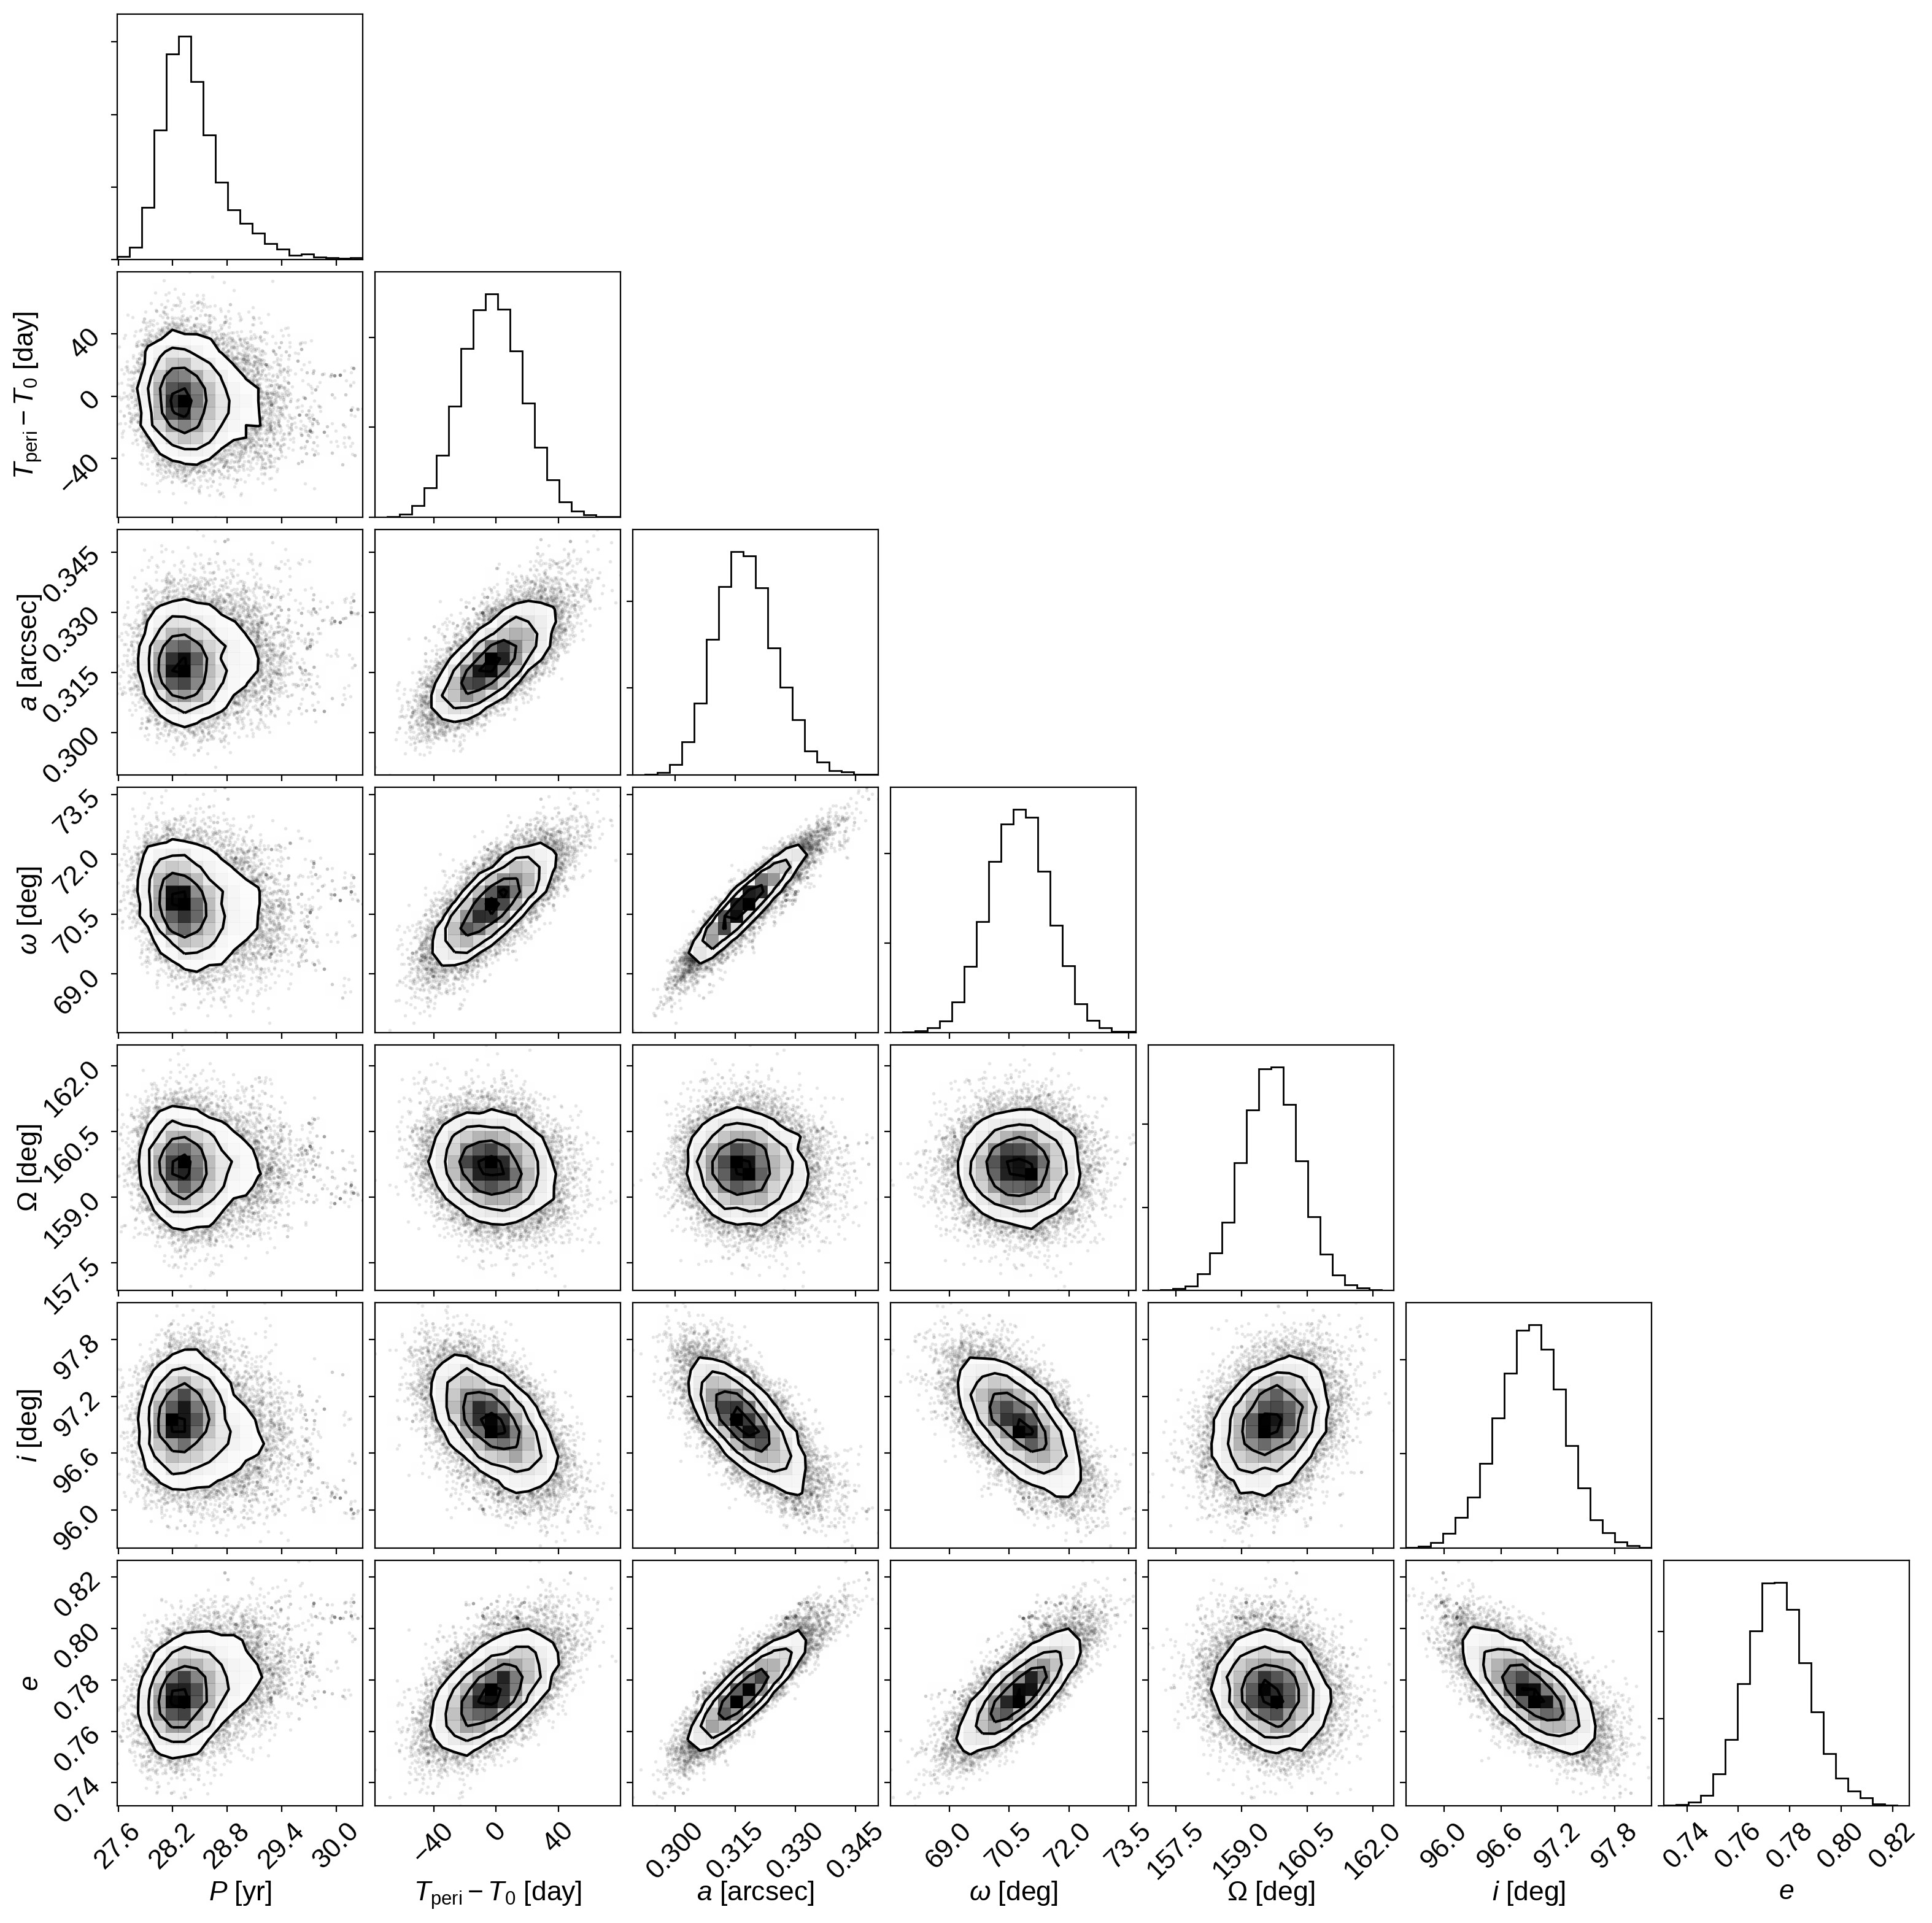

In [12]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
corner.corner(samples);

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

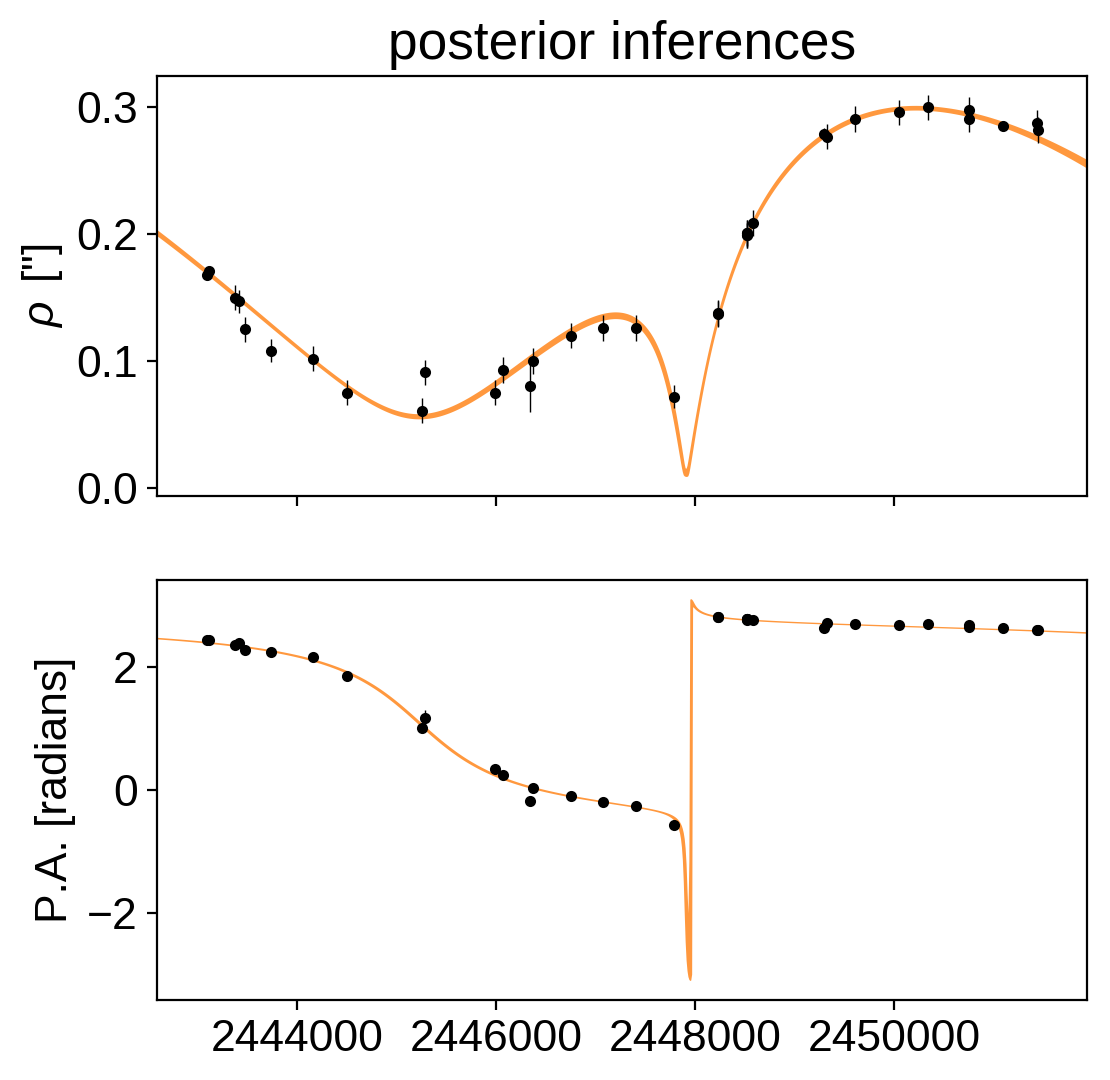

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0)))
tot_theta_err = np.sqrt(
    theta_err ** 2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0))
)

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("posterior inferences");

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem. 

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.076402e+02]

1it [00:00, 511.75it/s, logp=1.076402e+02]

2it [00:00, 696.32it/s, logp=1.076402e+02]

3it [00:00, 724.78it/s, logp=1.476711e+02]

4it [00:00, 763.33it/s, logp=1.084303e+02]

5it [00:00, 812.76it/s, logp=1.485840e+02]

6it [00:00, 818.43it/s, logp=1.497845e+02]

7it [00:00, 825.07it/s, logp=1.499280e+02]

8it [00:00, 834.98it/s, logp=1.499286e+02]

9it [00:00, 840.45it/s, logp=1.499286e+02]

10it [00:00, 840.81it/s, logp=1.499286e+02]

11it [00:01,  7.14it/s, logp=1.499286e+02] 


message: Optimization terminated successfully.
logp: 107.64015029566296 -> 149.92860106267193


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.499286e+02]

1it [00:00, 560.81it/s, logp=1.499286e+02]

2it [00:00, 728.81it/s, logp=1.499286e+02]

3it [00:00, 752.75it/s, logp=-1.185553e+04]

4it [00:00, 794.75it/s, logp=1.499517e+02] 

5it [00:00, 795.91it/s, logp=1.499982e+02]

6it [00:00, 820.83it/s, logp=1.501832e+02]

7it [00:00, 836.92it/s, logp=1.509035e+02]

8it [00:00, 862.34it/s, logp=1.535077e+02]

9it [00:00, 856.04it/s, logp=1.593811e+02]

10it [00:00, 852.67it/s, logp=1.662757e+02]

11it [00:00, 845.16it/s, logp=1.694242e+02]

12it [00:00, 843.50it/s, logp=1.703302e+02]

13it [00:00, 826.36it/s, logp=1.704061e+02]

14it [00:00, 826.49it/s, logp=1.704094e+02]

15it [00:00, 823.37it/s, logp=1.704128e+02]

16it [00:00, 822.56it/s, logp=1.704184e+02]

17it [00:00, 825.00it/s, logp=1.704249e+02]

18it [00:00, 820.72it/s, logp=1.704265e+02]

19it [00:00, 804.35it/s, logp=1.704268e+02]

20it [00:00, 801.46it/s, logp=1.704268e+02]

21it [00:00, 796.35it/s, logp=1.704268e+02]

22it [00:00, 795.05it/s, logp=1.704268e+02]

23it [00:00, 28.32it/s, logp=1.704268e+02] 


message: Optimization terminated successfully.
logp: 149.92860106267193 -> 170.4268151845905


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.704268e+02]

1it [00:00, 338.88it/s, logp=1.704268e+02]

2it [00:00, 449.89it/s, logp=1.704268e+02]

3it [00:00, 478.91it/s, logp=-4.518236e+03]

4it [00:00, 515.78it/s, logp=1.710200e+02] 

5it [00:00, 522.75it/s, logp=1.695336e+02]

6it [00:00, 539.00it/s, logp=1.711520e+02]

7it [00:00, 552.80it/s, logp=1.714066e+02]

8it [00:00, 564.72it/s, logp=1.721879e+02]

9it [00:00, 571.95it/s, logp=1.742150e+02]

10it [00:00, 579.91it/s, logp=1.812157e+02]

11it [00:00, 588.93it/s, logp=1.949820e+02]

12it [00:00, 592.35it/s, logp=1.964691e+02]

13it [00:00, 596.07it/s, logp=1.992100e+02]

14it [00:00, 606.11it/s, logp=2.038785e+02]

15it [00:00, 613.25it/s, logp=2.102587e+02]

16it [00:00, 620.30it/s, logp=2.122110e+02]

17it [00:00, 626.86it/s, logp=2.126408e+02]

18it [00:00, 632.91it/s, logp=2.126846e+02]

19it [00:00, 635.95it/s, logp=2.126998e+02]

20it [00:00, 639.93it/s, logp=2.127263e+02]

21it [00:00, 646.04it/s, logp=2.127699e+02]

22it [00:00, 648.79it/s, logp=2.128244e+02]

23it [00:00, 646.45it/s, logp=2.128398e+02]

24it [00:00, 645.41it/s, logp=2.128456e+02]

25it [00:00, 644.57it/s, logp=2.128460e+02]

26it [00:00, 641.40it/s, logp=2.128463e+02]

27it [00:00, 635.88it/s, logp=2.128468e+02]

28it [00:00, 633.10it/s, logp=2.128475e+02]

29it [00:00, 628.77it/s, logp=2.128479e+02]

30it [00:00, 625.09it/s, logp=2.128480e+02]

31it [00:00, 621.65it/s, logp=2.128480e+02]

32it [00:00, 618.38it/s, logp=2.128480e+02]

33it [00:00, 614.13it/s, logp=2.128480e+02]

34it [00:00, 612.84it/s, logp=2.128480e+02]

35it [00:00, 38.60it/s, logp=2.128480e+02] 


message: Optimization terminated successfully.
logp: 170.42681518459054 -> 212.8480158855976


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.128480e+02]

1it [00:00, 384.27it/s, logp=2.128480e+02]

2it [00:00, 548.60it/s, logp=2.128480e+02]

3it [00:00, 597.03it/s, logp=-4.375386e+03]

4it [00:00, 656.08it/s, logp=2.129960e+02] 

5it [00:00, 683.40it/s, logp=2.131453e+02]

6it [00:00, 692.02it/s, logp=2.132729e+02]

7it [00:00, 704.11it/s, logp=2.132857e+02]

8it [00:00, 715.60it/s, logp=2.132857e+02]

9it [00:00, 729.87it/s, logp=2.132860e+02]

10it [00:00, 735.82it/s, logp=2.132860e+02]

11it [00:00, 739.95it/s, logp=2.132860e+02]

12it [00:01, 10.77it/s, logp=2.132860e+02] 


message: Optimization terminated successfully.
logp: 212.8480158855976 -> 213.28597909410882


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.132860e+02]

1it [00:00, 331.51it/s, logp=2.132860e+02]

2it [00:00, 462.26it/s, logp=2.132860e+02]

3it [00:00, 514.05it/s, logp=-4.038433e+03]

4it [00:00, 554.34it/s, logp=2.152474e+02] 

5it [00:00, 575.13it/s, logp=1.676432e+02]

6it [00:00, 607.87it/s, logp=2.153207e+02]

7it [00:00, 603.57it/s, logp=2.154316e+02]

8it [00:00, 598.88it/s, logp=2.156115e+02]

9it [00:00, 601.74it/s, logp=2.158705e+02]

10it [00:00, 598.92it/s, logp=2.160160e+02]

11it [00:00, 599.16it/s, logp=2.158620e+02]

12it [00:00, 606.49it/s, logp=2.160652e+02]

13it [00:00, 596.13it/s, logp=2.160890e+02]

14it [00:00, 592.83it/s, logp=2.161353e+02]

15it [00:00, 590.28it/s, logp=2.162848e+02]

16it [00:00, 590.46it/s, logp=2.166196e+02]

17it [00:00, 579.21it/s, logp=2.171740e+02]

18it [00:00, 575.32it/s, logp=2.175761e+02]

19it [00:00, 574.45it/s, logp=2.174845e+02]

20it [00:00, 573.47it/s, logp=2.176565e+02]

21it [00:00, 566.32it/s, logp=2.177043e+02]

22it [00:00, 555.15it/s, logp=2.177335e+02]

23it [00:00, 552.54it/s, logp=2.177622e+02]

24it [00:00, 547.63it/s, logp=2.177547e+02]

25it [00:00, 551.34it/s, logp=2.177767e+02]

26it [00:00, 548.87it/s, logp=2.177873e+02]

27it [00:00, 540.51it/s, logp=2.177936e+02]

28it [00:00, 537.01it/s, logp=2.178014e+02]

29it [00:00, 525.93it/s, logp=2.178034e+02]

30it [00:00, 513.97it/s, logp=2.178054e+02]

31it [00:00, 507.43it/s, logp=2.178058e+02]

32it [00:00, 499.71it/s, logp=2.178059e+02]

33it [00:00, 493.06it/s, logp=2.178059e+02]

34it [00:00, 486.82it/s, logp=2.178059e+02]

35it [00:00, 478.89it/s, logp=2.178059e+02]

36it [00:00, 466.55it/s, logp=2.178059e+02]

37it [00:00, 459.15it/s, logp=2.178059e+02]

38it [00:00, 455.00it/s, logp=2.178059e+02]

39it [00:00, 452.72it/s, logp=2.178059e+02]

40it [00:00, 449.52it/s, logp=2.178059e+02]

41it [00:00, 450.55it/s, logp=2.178059e+02]

42it [00:00, 444.70it/s, logp=2.178059e+02]

43it [00:00, 437.35it/s, logp=2.178059e+02]

44it [00:00, 433.32it/s, logp=2.178059e+02]

45it [00:00, 438.15it/s, logp=2.178059e+02]

45it [00:00, 438.15it/s, logp=2.178059e+02]

46it [00:00, 438.15it/s, logp=2.178059e+02]

47it [00:00, 438.15it/s, logp=2.178059e+02]

48it [00:00, 438.15it/s, logp=2.178059e+02]

49it [00:00, 438.15it/s, logp=2.178059e+02]

50it [00:00, 438.15it/s, logp=2.178059e+02]

51it [00:00, 438.15it/s, logp=2.178059e+02]

52it [00:00, 438.15it/s, logp=2.178059e+02]

53it [00:00, 438.15it/s, logp=2.178059e+02]

54it [00:00, 438.15it/s, logp=2.178059e+02]

55it [00:00, 438.15it/s, logp=2.178059e+02]

56it [00:00, 438.15it/s, logp=2.178059e+02]

57it [00:00, 438.15it/s, logp=2.178059e+02]

58it [00:00, 438.15it/s, logp=2.178059e+02]

59it [00:00, 438.15it/s, logp=2.178059e+02]

60it [00:00, 438.15it/s, logp=2.178059e+02]

61it [00:00, 438.15it/s, logp=2.178059e+02]

62it [00:00, 438.15it/s, logp=2.178059e+02]

63it [00:00, 438.15it/s, logp=2.178059e+02]

64it [00:00, 438.15it/s, logp=2.178059e+02]

65it [00:00, 438.15it/s, logp=2.178059e+02]

66it [00:00, 438.15it/s, logp=2.178059e+02]

67it [00:00, 438.15it/s, logp=2.178059e+02]

68it [00:00, 438.15it/s, logp=2.178059e+02]

69it [00:00, 438.15it/s, logp=2.178059e+02]

70it [00:00, 438.15it/s, logp=2.178059e+02]

71it [00:00, 438.15it/s, logp=2.178059e+02]

72it [00:00, 438.15it/s, logp=2.178059e+02]

73it [00:00, 438.15it/s, logp=2.178059e+02]

74it [00:00, 438.15it/s, logp=2.178059e+02]

75it [00:00, 438.15it/s, logp=2.178059e+02]

76it [00:00, 438.15it/s, logp=2.178059e+02]

77it [00:00, 438.15it/s, logp=2.178059e+02]

78it [00:00, 438.15it/s, logp=2.178059e+02]

79it [00:00, 438.15it/s, logp=2.178059e+02]

80it [00:00, 438.15it/s, logp=2.178059e+02]

81it [00:00, 438.15it/s, logp=2.178059e+02]

82it [00:00, 438.15it/s, logp=2.178059e+02]

83it [00:00, 438.15it/s, logp=2.178059e+02]

84it [00:00, 438.15it/s, logp=2.178059e+02]

85it [00:00, 422.40it/s, logp=2.178059e+02]

85it [00:00, 422.40it/s, logp=2.178059e+02]

86it [00:00, 422.40it/s, logp=2.178059e+02]

87it [00:00, 422.40it/s, logp=2.178059e+02]

88it [00:00, 422.40it/s, logp=2.178059e+02]

89it [00:00, 422.40it/s, logp=2.178059e+02]

90it [00:00, 422.40it/s, logp=2.178059e+02]

91it [00:00, 422.40it/s, logp=2.178059e+02]

92it [00:00, 422.40it/s, logp=2.178059e+02]

93it [00:00, 422.40it/s, logp=2.178059e+02]

94it [00:00, 422.40it/s, logp=2.178059e+02]

95it [00:00, 422.40it/s, logp=2.178059e+02]

96it [00:00, 422.40it/s, logp=2.178059e+02]

97it [00:00, 422.40it/s, logp=2.178059e+02]

98it [00:00, 422.40it/s, logp=2.178059e+02]

99it [00:00, 422.40it/s, logp=2.178059e+02]

100it [00:00, 422.40it/s, logp=2.178059e+02]

101it [00:00, 422.40it/s, logp=2.178059e+02]

102it [00:00, 422.40it/s, logp=2.178059e+02]

103it [00:00, 422.40it/s, logp=2.178059e+02]

104it [00:00, 422.40it/s, logp=2.178059e+02]

105it [00:00, 422.40it/s, logp=2.178059e+02]

106it [00:00, 422.40it/s, logp=2.178059e+02]

107it [00:00, 422.40it/s, logp=2.178059e+02]

108it [00:00, 422.40it/s, logp=2.178059e+02]

109it [00:00, 422.40it/s, logp=2.178059e+02]

110it [00:00, 422.40it/s, logp=2.178059e+02]

111it [00:00, 422.40it/s, logp=2.178059e+02]

112it [00:00, 422.40it/s, logp=2.178059e+02]

113it [00:00, 422.40it/s, logp=2.178059e+02]

114it [00:00, 422.40it/s, logp=2.178059e+02]

115it [00:00, 119.55it/s, logp=2.178059e+02]


message: Desired error not necessarily achieved due to precision loss.
logp: 213.28597909410882 -> 217.8058683350306


In [15]:
np.random.seed(5432)
with plx_model:
    plx_trace = pm.sample(
        tune=5000,
        draws=4000,
        start=plx_map_soln,
        step=xo.get_dense_nuts_step(target_accept=0.9, start=plx_map_soln),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 4 chains:   0%|          | 0/36000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 14/36000 [00:00<05:03, 118.71draws/s]

Sampling 4 chains:   0%|          | 18/36000 [00:00<08:14, 72.81draws/s] 

Sampling 4 chains:   0%|          | 22/36000 [00:00<10:16, 58.39draws/s]

Sampling 4 chains:   0%|          | 27/36000 [00:00<13:47, 43.47draws/s]

Sampling 4 chains:   0%|          | 34/36000 [00:00<12:38, 47.43draws/s]

Sampling 4 chains:   0%|          | 39/36000 [00:00<15:04, 39.78draws/s]

Sampling 4 chains:   0%|          | 44/36000 [00:00<14:35, 41.05draws/s]

Sampling 4 chains:   0%|          | 49/36000 [00:01<16:20, 36.65draws/s]

Sampling 4 chains:   0%|          | 54/36000 [00:01<15:59, 37.45draws/s]

Sampling 4 chains:   0%|          | 59/36000 [00:01<15:01, 39.87draws/s]

Sampling 4 chains:   0%|          | 64/36000 [00:01<17:34, 34.07draws/s]

Sampling 4 chains:   0%|          | 69/36000 [00:01<17:08, 34.94draws/s]

Sampling 4 chains:   0%|          | 74/36000 [00:01<15:42, 38.11draws/s]

Sampling 4 chains:   0%|          | 79/36000 [00:01<14:37, 40.92draws/s]

Sampling 4 chains:   0%|          | 84/36000 [00:01<14:40, 40.79draws/s]

Sampling 4 chains:   0%|          | 89/36000 [00:02<15:11, 39.38draws/s]

Sampling 4 chains:   0%|          | 94/36000 [00:02<14:17, 41.88draws/s]

Sampling 4 chains:   0%|          | 99/36000 [00:02<13:39, 43.83draws/s]

Sampling 4 chains:   0%|          | 104/36000 [00:02<13:33, 44.13draws/s]

Sampling 4 chains:   0%|          | 109/36000 [00:02<13:34, 44.07draws/s]

Sampling 4 chains:   0%|          | 115/36000 [00:02<13:33, 44.12draws/s]

Sampling 4 chains:   0%|          | 121/36000 [00:02<13:16, 45.04draws/s]

Sampling 4 chains:   0%|          | 127/36000 [00:02<12:40, 47.17draws/s]

Sampling 4 chains:   0%|          | 133/36000 [00:03<13:27, 44.42draws/s]

Sampling 4 chains:   0%|          | 138/36000 [00:03<13:28, 44.35draws/s]

Sampling 4 chains:   0%|          | 143/36000 [00:03<13:06, 45.61draws/s]

Sampling 4 chains:   0%|          | 148/36000 [00:03<13:51, 43.12draws/s]

Sampling 4 chains:   0%|          | 153/36000 [00:03<13:39, 43.73draws/s]

Sampling 4 chains:   0%|          | 158/36000 [00:03<15:38, 38.21draws/s]

Sampling 4 chains:   0%|          | 163/36000 [00:03<15:40, 38.09draws/s]

Sampling 4 chains:   0%|          | 168/36000 [00:03<16:35, 35.99draws/s]

Sampling 4 chains:   0%|          | 173/36000 [00:04<15:30, 38.50draws/s]

Sampling 4 chains:   0%|          | 179/36000 [00:04<14:55, 40.01draws/s]

Sampling 4 chains:   1%|          | 184/36000 [00:04<15:28, 38.59draws/s]

Sampling 4 chains:   1%|          | 191/36000 [00:04<13:27, 44.36draws/s]

Sampling 4 chains:   1%|          | 196/36000 [00:04<13:26, 44.40draws/s]

Sampling 4 chains:   1%|          | 201/36000 [00:04<16:04, 37.12draws/s]

Sampling 4 chains:   1%|          | 207/36000 [00:04<14:41, 40.62draws/s]

Sampling 4 chains:   1%|          | 212/36000 [00:05<15:41, 38.00draws/s]

Sampling 4 chains:   1%|          | 217/36000 [00:05<14:53, 40.05draws/s]

Sampling 4 chains:   1%|          | 224/36000 [00:05<13:13, 45.09draws/s]

Sampling 4 chains:   1%|          | 229/36000 [00:05<13:26, 44.36draws/s]

Sampling 4 chains:   1%|          | 235/36000 [00:05<12:47, 46.62draws/s]

Sampling 4 chains:   1%|          | 241/36000 [00:05<11:59, 49.72draws/s]

Sampling 4 chains:   1%|          | 247/36000 [00:05<12:05, 49.28draws/s]

Sampling 4 chains:   1%|          | 253/36000 [00:05<12:40, 47.01draws/s]

Sampling 4 chains:   1%|          | 258/36000 [00:05<13:25, 44.40draws/s]

Sampling 4 chains:   1%|          | 265/36000 [00:06<12:01, 49.55draws/s]

Sampling 4 chains:   1%|          | 271/36000 [00:06<11:57, 49.80draws/s]

Sampling 4 chains:   1%|          | 277/36000 [00:06<12:59, 45.85draws/s]

Sampling 4 chains:   1%|          | 284/36000 [00:06<12:12, 48.73draws/s]

Sampling 4 chains:   1%|          | 290/36000 [00:06<12:33, 47.42draws/s]

Sampling 4 chains:   1%|          | 296/36000 [00:06<12:32, 47.42draws/s]

Sampling 4 chains:   1%|          | 301/36000 [00:06<12:26, 47.84draws/s]

Sampling 4 chains:   1%|          | 306/36000 [00:06<12:48, 46.47draws/s]

Sampling 4 chains:   1%|          | 311/36000 [00:07<12:59, 45.77draws/s]

Sampling 4 chains:   1%|          | 316/36000 [00:07<14:28, 41.08draws/s]

Sampling 4 chains:   1%|          | 323/36000 [00:07<13:02, 45.60draws/s]

Sampling 4 chains:   1%|          | 329/36000 [00:07<13:34, 43.78draws/s]

Sampling 4 chains:   1%|          | 334/36000 [00:07<13:30, 44.01draws/s]

Sampling 4 chains:   1%|          | 339/36000 [00:07<13:17, 44.73draws/s]

Sampling 4 chains:   1%|          | 344/36000 [00:07<13:48, 43.04draws/s]

Sampling 4 chains:   1%|          | 351/36000 [00:07<12:54, 46.04draws/s]

Sampling 4 chains:   1%|          | 357/36000 [00:08<12:57, 45.87draws/s]

Sampling 4 chains:   1%|          | 363/36000 [00:08<12:12, 48.68draws/s]

Sampling 4 chains:   1%|          | 368/36000 [00:08<12:41, 46.78draws/s]

Sampling 4 chains:   1%|          | 373/36000 [00:08<13:04, 45.39draws/s]

Sampling 4 chains:   1%|          | 378/36000 [00:08<13:24, 44.26draws/s]

Sampling 4 chains:   1%|          | 384/36000 [00:08<12:50, 46.24draws/s]

Sampling 4 chains:   1%|          | 390/36000 [00:08<12:07, 48.93draws/s]

Sampling 4 chains:   1%|          | 398/36000 [00:08<10:56, 54.22draws/s]

Sampling 4 chains:   1%|          | 411/36000 [00:08<09:04, 65.36draws/s]

Sampling 4 chains:   1%|          | 433/36000 [00:09<07:09, 82.77draws/s]

Sampling 4 chains:   1%|▏         | 451/36000 [00:09<05:59, 98.76draws/s]

Sampling 4 chains:   1%|▏         | 471/36000 [00:09<05:06, 116.07draws/s]

Sampling 4 chains:   1%|▏         | 494/36000 [00:09<04:20, 136.28draws/s]

Sampling 4 chains:   1%|▏         | 513/36000 [00:09<03:58, 148.86draws/s]

Sampling 4 chains:   1%|▏         | 532/36000 [00:09<04:12, 140.63draws/s]

Sampling 4 chains:   2%|▏         | 549/36000 [00:09<04:12, 140.36draws/s]

Sampling 4 chains:   2%|▏         | 567/36000 [00:09<03:56, 149.60draws/s]

Sampling 4 chains:   2%|▏         | 586/36000 [00:09<03:42, 159.24draws/s]

Sampling 4 chains:   2%|▏         | 604/36000 [00:10<03:54, 150.94draws/s]

Sampling 4 chains:   2%|▏         | 620/36000 [00:10<03:50, 153.31draws/s]

Sampling 4 chains:   2%|▏         | 639/36000 [00:10<03:37, 162.64draws/s]

Sampling 4 chains:   2%|▏         | 662/36000 [00:10<03:18, 178.24draws/s]

Sampling 4 chains:   2%|▏         | 681/36000 [00:10<03:15, 180.47draws/s]

Sampling 4 chains:   2%|▏         | 706/36000 [00:10<03:00, 195.97draws/s]

Sampling 4 chains:   2%|▏         | 732/36000 [00:10<02:47, 210.06draws/s]

Sampling 4 chains:   2%|▏         | 754/36000 [00:10<02:49, 208.03draws/s]

Sampling 4 chains:   2%|▏         | 778/36000 [00:10<02:43, 215.59draws/s]

Sampling 4 chains:   2%|▏         | 810/36000 [00:11<02:27, 238.54draws/s]

Sampling 4 chains:   2%|▏         | 844/36000 [00:11<02:14, 261.18draws/s]

Sampling 4 chains:   2%|▏         | 881/36000 [00:11<02:02, 285.97draws/s]

Sampling 4 chains:   3%|▎         | 928/36000 [00:11<01:49, 321.71draws/s]

Sampling 4 chains:   3%|▎         | 971/36000 [00:11<01:41, 345.18draws/s]

Sampling 4 chains:   3%|▎         | 1013/36000 [00:11<01:36, 363.62draws/s]

Sampling 4 chains:   3%|▎         | 1057/36000 [00:11<01:31, 382.39draws/s]

Sampling 4 chains:   3%|▎         | 1101/36000 [00:11<01:28, 395.08draws/s]

Sampling 4 chains:   3%|▎         | 1148/36000 [00:11<01:24, 413.75draws/s]

Sampling 4 chains:   3%|▎         | 1191/36000 [00:11<01:27, 396.60draws/s]

Sampling 4 chains:   3%|▎         | 1232/36000 [00:12<01:34, 368.97draws/s]

Sampling 4 chains:   4%|▎         | 1270/36000 [00:12<01:38, 354.21draws/s]

Sampling 4 chains:   4%|▎         | 1309/36000 [00:12<01:35, 363.64draws/s]

Sampling 4 chains:   4%|▍         | 1350/36000 [00:12<01:32, 375.83draws/s]

Sampling 4 chains:   4%|▍         | 1392/36000 [00:12<01:29, 386.39draws/s]

Sampling 4 chains:   4%|▍         | 1437/36000 [00:12<01:25, 403.00draws/s]

Sampling 4 chains:   4%|▍         | 1478/36000 [00:12<01:27, 395.51draws/s]

Sampling 4 chains:   4%|▍         | 1518/36000 [00:12<01:28, 387.90draws/s]

Sampling 4 chains:   4%|▍         | 1570/36000 [00:12<01:22, 417.96draws/s]

Sampling 4 chains:   5%|▍         | 1622/36000 [00:13<01:17, 443.94draws/s]

Sampling 4 chains:   5%|▍         | 1668/36000 [00:13<01:20, 424.95draws/s]

Sampling 4 chains:   5%|▍         | 1712/36000 [00:13<01:24, 407.76draws/s]

Sampling 4 chains:   5%|▍         | 1755/36000 [00:13<01:23, 410.96draws/s]

Sampling 4 chains:   5%|▍         | 1797/36000 [00:13<01:24, 403.58draws/s]

Sampling 4 chains:   5%|▌         | 1838/36000 [00:13<01:32, 370.70draws/s]

Sampling 4 chains:   5%|▌         | 1883/36000 [00:13<01:27, 388.42draws/s]

Sampling 4 chains:   5%|▌         | 1923/36000 [00:13<01:30, 376.69draws/s]

Sampling 4 chains:   5%|▌         | 1962/36000 [00:13<01:32, 367.37draws/s]

Sampling 4 chains:   6%|▌         | 2004/36000 [00:14<01:29, 380.56draws/s]

Sampling 4 chains:   6%|▌         | 2043/36000 [00:14<01:31, 371.75draws/s]

Sampling 4 chains:   6%|▌         | 2081/36000 [00:14<01:37, 349.60draws/s]

Sampling 4 chains:   6%|▌         | 2118/36000 [00:14<01:35, 354.01draws/s]

Sampling 4 chains:   6%|▌         | 2154/36000 [00:14<01:36, 350.00draws/s]

Sampling 4 chains:   6%|▌         | 2195/36000 [00:14<01:33, 360.99draws/s]

Sampling 4 chains:   6%|▌         | 2232/36000 [00:14<01:41, 334.31draws/s]

Sampling 4 chains:   6%|▋         | 2268/36000 [00:14<01:39, 338.22draws/s]

Sampling 4 chains:   6%|▋         | 2312/36000 [00:14<01:32, 362.82draws/s]

Sampling 4 chains:   7%|▋         | 2350/36000 [00:15<01:35, 350.95draws/s]

Sampling 4 chains:   7%|▋         | 2386/36000 [00:15<01:39, 336.77draws/s]

Sampling 4 chains:   7%|▋         | 2421/36000 [00:15<01:44, 321.51draws/s]

Sampling 4 chains:   7%|▋         | 2459/36000 [00:15<01:41, 329.60draws/s]

Sampling 4 chains:   7%|▋         | 2500/36000 [00:15<01:35, 350.00draws/s]

Sampling 4 chains:   7%|▋         | 2536/36000 [00:15<01:35, 349.20draws/s]

Sampling 4 chains:   7%|▋         | 2572/36000 [00:15<01:40, 332.31draws/s]

Sampling 4 chains:   7%|▋         | 2609/36000 [00:15<01:37, 342.51draws/s]

Sampling 4 chains:   7%|▋         | 2645/36000 [00:15<01:37, 343.69draws/s]

Sampling 4 chains:   7%|▋         | 2684/36000 [00:16<01:34, 353.96draws/s]

Sampling 4 chains:   8%|▊         | 2720/36000 [00:16<01:33, 355.65draws/s]

Sampling 4 chains:   8%|▊         | 2756/36000 [00:16<01:39, 335.57draws/s]

Sampling 4 chains:   8%|▊         | 2790/36000 [00:16<01:40, 329.36draws/s]

Sampling 4 chains:   8%|▊         | 2824/36000 [00:16<01:40, 330.45draws/s]

Sampling 4 chains:   8%|▊         | 2858/36000 [00:16<01:41, 327.65draws/s]

Sampling 4 chains:   8%|▊         | 2905/36000 [00:16<01:31, 360.09draws/s]

Sampling 4 chains:   8%|▊         | 2943/36000 [00:16<01:30, 364.51draws/s]

Sampling 4 chains:   8%|▊         | 2981/36000 [00:16<01:33, 353.74draws/s]

Sampling 4 chains:   8%|▊         | 3017/36000 [00:16<01:34, 349.29draws/s]

Sampling 4 chains:   8%|▊         | 3053/36000 [00:17<01:37, 339.02draws/s]

Sampling 4 chains:   9%|▊         | 3094/36000 [00:17<01:32, 353.84draws/s]

Sampling 4 chains:   9%|▊         | 3130/36000 [00:17<01:38, 335.09draws/s]

Sampling 4 chains:   9%|▉         | 3165/36000 [00:17<01:40, 327.05draws/s]

Sampling 4 chains:   9%|▉         | 3199/36000 [00:17<01:43, 317.46draws/s]

Sampling 4 chains:   9%|▉         | 3232/36000 [00:17<01:45, 309.93draws/s]

Sampling 4 chains:   9%|▉         | 3269/36000 [00:17<01:40, 324.99draws/s]

Sampling 4 chains:   9%|▉         | 3309/36000 [00:17<01:35, 343.13draws/s]

Sampling 4 chains:   9%|▉         | 3344/36000 [00:17<01:36, 339.66draws/s]

Sampling 4 chains:   9%|▉         | 3379/36000 [00:18<01:38, 329.74draws/s]

Sampling 4 chains:   9%|▉         | 3413/36000 [00:18<01:41, 320.20draws/s]

Sampling 4 chains:  10%|▉         | 3449/36000 [00:18<01:38, 330.43draws/s]

Sampling 4 chains:  10%|▉         | 3483/36000 [00:18<01:38, 329.71draws/s]

Sampling 4 chains:  10%|▉         | 3520/36000 [00:18<01:35, 340.02draws/s]

Sampling 4 chains:  10%|▉         | 3568/36000 [00:18<01:27, 368.99draws/s]

Sampling 4 chains:  10%|█         | 3615/36000 [00:18<01:22, 394.21draws/s]

Sampling 4 chains:  10%|█         | 3659/36000 [00:18<01:19, 404.77draws/s]

Sampling 4 chains:  10%|█         | 3701/36000 [00:18<01:20, 401.41draws/s]

Sampling 4 chains:  10%|█         | 3742/36000 [00:19<01:23, 384.81draws/s]

Sampling 4 chains:  11%|█         | 3782/36000 [00:19<01:23, 387.87draws/s]

Sampling 4 chains:  11%|█         | 3822/36000 [00:19<01:32, 347.19draws/s]

Sampling 4 chains:  11%|█         | 3858/36000 [00:19<01:37, 329.01draws/s]

Sampling 4 chains:  11%|█         | 3895/36000 [00:19<01:34, 339.15draws/s]

Sampling 4 chains:  11%|█         | 3937/36000 [00:19<01:29, 359.62draws/s]

Sampling 4 chains:  11%|█         | 3988/36000 [00:19<01:21, 392.38draws/s]

Sampling 4 chains:  11%|█         | 4029/36000 [00:19<01:24, 378.18draws/s]

Sampling 4 chains:  11%|█▏        | 4068/36000 [00:19<01:25, 373.66draws/s]

Sampling 4 chains:  11%|█▏        | 4108/36000 [00:20<01:24, 376.36draws/s]

Sampling 4 chains:  12%|█▏        | 4147/36000 [00:20<01:27, 365.28draws/s]

Sampling 4 chains:  12%|█▏        | 4185/36000 [00:20<01:28, 361.19draws/s]

Sampling 4 chains:  12%|█▏        | 4222/36000 [00:20<01:30, 352.69draws/s]

Sampling 4 chains:  12%|█▏        | 4259/36000 [00:20<01:29, 356.18draws/s]

Sampling 4 chains:  12%|█▏        | 4295/36000 [00:20<01:32, 340.93draws/s]

Sampling 4 chains:  12%|█▏        | 4335/36000 [00:20<01:28, 356.72draws/s]

Sampling 4 chains:  12%|█▏        | 4386/36000 [00:20<01:20, 390.74draws/s]

Sampling 4 chains:  12%|█▏        | 4429/36000 [00:20<01:18, 401.11draws/s]

Sampling 4 chains:  12%|█▏        | 4474/36000 [00:20<01:16, 413.79draws/s]

Sampling 4 chains:  13%|█▎        | 4522/36000 [00:21<01:13, 431.14draws/s]

Sampling 4 chains:  13%|█▎        | 4566/36000 [00:21<01:14, 422.96draws/s]

Sampling 4 chains:  13%|█▎        | 4609/36000 [00:21<01:16, 412.86draws/s]

Sampling 4 chains:  13%|█▎        | 4651/36000 [00:21<01:20, 389.49draws/s]

Sampling 4 chains:  13%|█▎        | 4691/36000 [00:21<01:23, 373.48draws/s]

Sampling 4 chains:  13%|█▎        | 4729/36000 [00:21<01:24, 371.16draws/s]

Sampling 4 chains:  13%|█▎        | 4773/36000 [00:21<01:20, 387.07draws/s]

Sampling 4 chains:  13%|█▎        | 4813/36000 [00:21<01:21, 384.04draws/s]

Sampling 4 chains:  13%|█▎        | 4856/36000 [00:21<01:18, 396.43draws/s]

Sampling 4 chains:  14%|█▎        | 4896/36000 [00:22<01:19, 389.75draws/s]

Sampling 4 chains:  14%|█▎        | 4936/36000 [00:22<01:19, 390.22draws/s]

Sampling 4 chains:  14%|█▍        | 4976/36000 [00:22<01:22, 378.06draws/s]

Sampling 4 chains:  14%|█▍        | 5015/36000 [00:22<01:23, 371.92draws/s]

Sampling 4 chains:  14%|█▍        | 5053/36000 [00:22<01:27, 354.67draws/s]

Sampling 4 chains:  14%|█▍        | 5089/36000 [00:22<01:30, 342.52draws/s]

Sampling 4 chains:  14%|█▍        | 5124/36000 [00:22<01:32, 333.85draws/s]

Sampling 4 chains:  14%|█▍        | 5162/36000 [00:22<01:29, 343.08draws/s]

Sampling 4 chains:  14%|█▍        | 5207/36000 [00:22<01:23, 368.05draws/s]

Sampling 4 chains:  15%|█▍        | 5253/36000 [00:23<01:19, 387.41draws/s]

Sampling 4 chains:  15%|█▍        | 5294/36000 [00:23<01:18, 391.32draws/s]

Sampling 4 chains:  15%|█▍        | 5334/36000 [00:23<01:21, 374.17draws/s]

Sampling 4 chains:  15%|█▍        | 5372/36000 [00:23<01:27, 350.60draws/s]

Sampling 4 chains:  15%|█▌        | 5408/36000 [00:23<01:27, 351.10draws/s]

Sampling 4 chains:  15%|█▌        | 5444/36000 [00:23<01:29, 342.90draws/s]

Sampling 4 chains:  15%|█▌        | 5479/36000 [00:23<01:31, 334.57draws/s]

Sampling 4 chains:  15%|█▌        | 5514/36000 [00:23<01:30, 338.48draws/s]

Sampling 4 chains:  15%|█▌        | 5553/36000 [00:23<01:26, 351.91draws/s]

Sampling 4 chains:  16%|█▌        | 5594/36000 [00:23<01:22, 366.98draws/s]

Sampling 4 chains:  16%|█▌        | 5637/36000 [00:24<01:19, 382.06draws/s]

Sampling 4 chains:  16%|█▌        | 5676/36000 [00:24<01:19, 381.04draws/s]

Sampling 4 chains:  16%|█▌        | 5715/36000 [00:24<01:21, 371.70draws/s]

Sampling 4 chains:  16%|█▌        | 5754/36000 [00:24<01:20, 375.16draws/s]

Sampling 4 chains:  16%|█▌        | 5792/36000 [00:24<01:21, 368.49draws/s]

Sampling 4 chains:  16%|█▌        | 5836/36000 [00:24<01:18, 382.27draws/s]

Sampling 4 chains:  16%|█▋        | 5875/36000 [00:24<01:19, 378.63draws/s]

Sampling 4 chains:  16%|█▋        | 5917/36000 [00:24<01:17, 389.45draws/s]

Sampling 4 chains:  17%|█▋        | 5967/36000 [00:24<01:12, 415.71draws/s]

Sampling 4 chains:  17%|█▋        | 6012/36000 [00:25<01:10, 422.55draws/s]

Sampling 4 chains:  17%|█▋        | 6057/36000 [00:25<01:09, 428.65draws/s]

Sampling 4 chains:  17%|█▋        | 6105/36000 [00:25<01:07, 442.02draws/s]

Sampling 4 chains:  17%|█▋        | 6150/36000 [00:25<01:10, 422.41draws/s]

Sampling 4 chains:  17%|█▋        | 6193/36000 [00:25<01:12, 412.60draws/s]

Sampling 4 chains:  17%|█▋        | 6245/36000 [00:25<01:08, 437.21draws/s]

Sampling 4 chains:  17%|█▋        | 6290/36000 [00:25<01:07, 437.06draws/s]

Sampling 4 chains:  18%|█▊        | 6335/36000 [00:25<01:12, 408.70draws/s]

Sampling 4 chains:  18%|█▊        | 6378/36000 [00:25<01:11, 414.59draws/s]

Sampling 4 chains:  18%|█▊        | 6421/36000 [00:25<01:11, 416.14draws/s]

Sampling 4 chains:  18%|█▊        | 6463/36000 [00:26<01:11, 415.60draws/s]

Sampling 4 chains:  18%|█▊        | 6507/36000 [00:26<01:10, 420.59draws/s]

Sampling 4 chains:  18%|█▊        | 6550/36000 [00:26<01:12, 408.61draws/s]

Sampling 4 chains:  18%|█▊        | 6592/36000 [00:26<01:12, 406.45draws/s]

Sampling 4 chains:  18%|█▊        | 6638/36000 [00:26<01:09, 420.00draws/s]

Sampling 4 chains:  19%|█▊        | 6681/36000 [00:26<01:12, 404.70draws/s]

Sampling 4 chains:  19%|█▊        | 6722/36000 [00:26<01:16, 383.49draws/s]

Sampling 4 chains:  19%|█▉        | 6761/36000 [00:26<01:18, 373.32draws/s]

Sampling 4 chains:  19%|█▉        | 6805/36000 [00:26<01:14, 390.69draws/s]

Sampling 4 chains:  19%|█▉        | 6859/36000 [00:27<01:08, 423.42draws/s]

Sampling 4 chains:  19%|█▉        | 6903/36000 [00:27<01:10, 414.63draws/s]

Sampling 4 chains:  19%|█▉        | 6946/36000 [00:27<01:10, 411.55draws/s]

Sampling 4 chains:  19%|█▉        | 6988/36000 [00:27<01:10, 409.37draws/s]

Sampling 4 chains:  20%|█▉        | 7030/36000 [00:27<01:15, 386.06draws/s]

Sampling 4 chains:  20%|█▉        | 7070/36000 [00:27<01:15, 381.63draws/s]

Sampling 4 chains:  20%|█▉        | 7109/36000 [00:27<01:16, 380.00draws/s]

Sampling 4 chains:  20%|█▉        | 7148/36000 [00:27<01:16, 376.15draws/s]

Sampling 4 chains:  20%|█▉        | 7188/36000 [00:27<01:16, 378.07draws/s]

Sampling 4 chains:  20%|██        | 7229/36000 [00:28<01:14, 386.28draws/s]

Sampling 4 chains:  20%|██        | 7268/36000 [00:28<01:16, 376.01draws/s]

Sampling 4 chains:  20%|██        | 7311/36000 [00:28<01:13, 390.49draws/s]

Sampling 4 chains:  20%|██        | 7356/36000 [00:28<01:10, 404.22draws/s]

Sampling 4 chains:  21%|██        | 7397/36000 [00:28<01:17, 370.58draws/s]

Sampling 4 chains:  21%|██        | 7435/36000 [00:28<01:19, 357.78draws/s]

Sampling 4 chains:  21%|██        | 7473/36000 [00:28<01:18, 362.56draws/s]

Sampling 4 chains:  21%|██        | 7511/36000 [00:28<01:18, 364.62draws/s]

Sampling 4 chains:  21%|██        | 7557/36000 [00:28<01:13, 386.60draws/s]

Sampling 4 chains:  21%|██        | 7598/36000 [00:28<01:12, 392.53draws/s]

Sampling 4 chains:  21%|██        | 7639/36000 [00:29<01:12, 390.38draws/s]

Sampling 4 chains:  21%|██▏       | 7679/36000 [00:29<01:12, 387.99draws/s]

Sampling 4 chains:  21%|██▏       | 7725/36000 [00:29<01:09, 404.12draws/s]

Sampling 4 chains:  22%|██▏       | 7771/36000 [00:29<01:07, 417.05draws/s]

Sampling 4 chains:  22%|██▏       | 7814/36000 [00:29<01:07, 415.53draws/s]

Sampling 4 chains:  22%|██▏       | 7856/36000 [00:29<01:08, 409.15draws/s]

Sampling 4 chains:  22%|██▏       | 7898/36000 [00:29<01:11, 395.67draws/s]

Sampling 4 chains:  22%|██▏       | 7938/36000 [00:29<01:10, 395.98draws/s]

Sampling 4 chains:  22%|██▏       | 7978/36000 [00:29<01:12, 384.82draws/s]

Sampling 4 chains:  22%|██▏       | 8017/36000 [00:30<01:15, 370.32draws/s]

Sampling 4 chains:  22%|██▏       | 8055/36000 [00:30<01:16, 366.30draws/s]

Sampling 4 chains:  23%|██▎       | 8101/36000 [00:30<01:11, 388.98draws/s]

Sampling 4 chains:  23%|██▎       | 8145/36000 [00:30<01:09, 402.69draws/s]

Sampling 4 chains:  23%|██▎       | 8194/36000 [00:30<01:05, 423.57draws/s]

Sampling 4 chains:  23%|██▎       | 8240/36000 [00:30<01:04, 433.57draws/s]

Sampling 4 chains:  23%|██▎       | 8284/36000 [00:30<01:04, 431.92draws/s]

Sampling 4 chains:  23%|██▎       | 8330/36000 [00:30<01:03, 436.58draws/s]

Sampling 4 chains:  23%|██▎       | 8379/36000 [00:30<01:01, 451.17draws/s]

Sampling 4 chains:  23%|██▎       | 8426/36000 [00:30<01:00, 456.61draws/s]

Sampling 4 chains:  24%|██▎       | 8473/36000 [00:31<00:59, 460.49draws/s]

Sampling 4 chains:  24%|██▎       | 8522/36000 [00:31<00:59, 465.36draws/s]

Sampling 4 chains:  24%|██▍       | 8569/36000 [00:31<01:00, 449.81draws/s]

Sampling 4 chains:  24%|██▍       | 8615/36000 [00:31<01:02, 434.90draws/s]

Sampling 4 chains:  24%|██▍       | 8662/36000 [00:31<01:01, 441.91draws/s]

Sampling 4 chains:  24%|██▍       | 8707/36000 [00:31<01:01, 441.94draws/s]

Sampling 4 chains:  24%|██▍       | 8752/36000 [00:31<01:01, 441.86draws/s]

Sampling 4 chains:  24%|██▍       | 8797/36000 [00:31<01:03, 427.98draws/s]

Sampling 4 chains:  25%|██▍       | 8840/36000 [00:31<01:08, 394.69draws/s]

Sampling 4 chains:  25%|██▍       | 8881/36000 [00:32<01:08, 393.33draws/s]

Sampling 4 chains:  25%|██▍       | 8923/36000 [00:32<01:07, 400.36draws/s]

Sampling 4 chains:  25%|██▍       | 8969/36000 [00:32<01:04, 416.33draws/s]

Sampling 4 chains:  25%|██▌       | 9012/36000 [00:32<01:11, 376.71draws/s]

Sampling 4 chains:  25%|██▌       | 9051/36000 [00:32<01:11, 377.57draws/s]

Sampling 4 chains:  25%|██▌       | 9090/36000 [00:32<01:17, 346.88draws/s]

Sampling 4 chains:  25%|██▌       | 9126/36000 [00:32<01:17, 347.31draws/s]

Sampling 4 chains:  25%|██▌       | 9162/36000 [00:32<01:18, 341.27draws/s]

Sampling 4 chains:  26%|██▌       | 9208/36000 [00:32<01:12, 369.55draws/s]

Sampling 4 chains:  26%|██▌       | 9258/36000 [00:33<01:06, 400.03draws/s]

Sampling 4 chains:  26%|██▌       | 9301/36000 [00:33<01:06, 403.58draws/s]

Sampling 4 chains:  26%|██▌       | 9343/36000 [00:33<01:06, 400.54draws/s]

Sampling 4 chains:  26%|██▌       | 9384/36000 [00:33<01:07, 396.27draws/s]

Sampling 4 chains:  26%|██▌       | 9425/36000 [00:33<01:07, 394.60draws/s]

Sampling 4 chains:  26%|██▋       | 9470/36000 [00:33<01:05, 407.45draws/s]

Sampling 4 chains:  26%|██▋       | 9512/36000 [00:33<01:05, 404.22draws/s]

Sampling 4 chains:  27%|██▋       | 9553/36000 [00:33<01:07, 393.52draws/s]

Sampling 4 chains:  27%|██▋       | 9593/36000 [00:33<01:12, 364.77draws/s]

Sampling 4 chains:  27%|██▋       | 9631/36000 [00:34<01:13, 359.48draws/s]

Sampling 4 chains:  27%|██▋       | 9673/36000 [00:34<01:10, 375.32draws/s]

Sampling 4 chains:  27%|██▋       | 9716/36000 [00:34<01:07, 387.85draws/s]

Sampling 4 chains:  27%|██▋       | 9756/36000 [00:34<01:08, 382.63draws/s]

Sampling 4 chains:  27%|██▋       | 9795/36000 [00:34<01:10, 372.44draws/s]

Sampling 4 chains:  27%|██▋       | 9833/36000 [00:34<01:10, 373.49draws/s]

Sampling 4 chains:  27%|██▋       | 9873/36000 [00:34<01:09, 377.69draws/s]

Sampling 4 chains:  28%|██▊       | 9915/36000 [00:34<01:07, 386.17draws/s]

Sampling 4 chains:  28%|██▊       | 9954/36000 [00:34<01:07, 383.99draws/s]

Sampling 4 chains:  28%|██▊       | 9995/36000 [00:34<01:06, 389.27draws/s]

Sampling 4 chains:  28%|██▊       | 10035/36000 [00:35<01:09, 375.67draws/s]

Sampling 4 chains:  28%|██▊       | 10079/36000 [00:35<01:06, 388.27draws/s]

Sampling 4 chains:  28%|██▊       | 10119/36000 [00:35<01:10, 367.57draws/s]

Sampling 4 chains:  28%|██▊       | 10159/36000 [00:35<01:08, 376.70draws/s]

Sampling 4 chains:  28%|██▊       | 10197/36000 [00:35<01:09, 372.03draws/s]

Sampling 4 chains:  28%|██▊       | 10235/36000 [00:35<01:09, 371.61draws/s]

Sampling 4 chains:  29%|██▊       | 10273/36000 [00:35<01:10, 364.58draws/s]

Sampling 4 chains:  29%|██▊       | 10312/36000 [00:35<01:09, 370.19draws/s]

Sampling 4 chains:  29%|██▉       | 10353/36000 [00:35<01:07, 380.35draws/s]

Sampling 4 chains:  29%|██▉       | 10394/36000 [00:36<01:06, 387.10draws/s]

Sampling 4 chains:  29%|██▉       | 10436/36000 [00:36<01:05, 391.56draws/s]

Sampling 4 chains:  29%|██▉       | 10478/36000 [00:36<01:04, 397.74draws/s]

Sampling 4 chains:  29%|██▉       | 10524/36000 [00:36<01:01, 413.42draws/s]

Sampling 4 chains:  29%|██▉       | 10566/36000 [00:36<01:01, 411.80draws/s]

Sampling 4 chains:  29%|██▉       | 10608/36000 [00:36<01:02, 407.97draws/s]

Sampling 4 chains:  30%|██▉       | 10649/36000 [00:36<01:02, 405.48draws/s]

Sampling 4 chains:  30%|██▉       | 10691/36000 [00:36<01:02, 408.05draws/s]

Sampling 4 chains:  30%|██▉       | 10734/36000 [00:36<01:01, 412.82draws/s]

Sampling 4 chains:  30%|██▉       | 10783/36000 [00:36<00:58, 432.39draws/s]

Sampling 4 chains:  30%|███       | 10827/36000 [00:37<00:57, 434.42draws/s]

Sampling 4 chains:  30%|███       | 10871/36000 [00:37<00:58, 433.24draws/s]

Sampling 4 chains:  30%|███       | 10917/36000 [00:37<00:56, 440.36draws/s]

Sampling 4 chains:  30%|███       | 10972/36000 [00:37<00:53, 464.18draws/s]

Sampling 4 chains:  31%|███       | 11019/36000 [00:37<00:54, 457.39draws/s]

Sampling 4 chains:  31%|███       | 11066/36000 [00:37<00:58, 424.04draws/s]

Sampling 4 chains:  31%|███       | 11110/36000 [00:37<01:00, 408.95draws/s]

Sampling 4 chains:  31%|███       | 11153/36000 [00:37<01:00, 411.01draws/s]

Sampling 4 chains:  31%|███       | 11198/36000 [00:37<00:58, 421.16draws/s]

Sampling 4 chains:  31%|███       | 11241/36000 [00:38<01:00, 409.07draws/s]

Sampling 4 chains:  31%|███▏      | 11283/36000 [00:38<01:01, 401.08draws/s]

Sampling 4 chains:  31%|███▏      | 11324/36000 [00:38<01:01, 402.61draws/s]

Sampling 4 chains:  32%|███▏      | 11368/36000 [00:38<00:59, 410.70draws/s]

Sampling 4 chains:  32%|███▏      | 11415/36000 [00:38<00:58, 422.94draws/s]

Sampling 4 chains:  32%|███▏      | 11458/36000 [00:38<00:58, 422.07draws/s]

Sampling 4 chains:  32%|███▏      | 11510/36000 [00:38<00:54, 446.71draws/s]

Sampling 4 chains:  32%|███▏      | 11556/36000 [00:38<00:57, 423.97draws/s]

Sampling 4 chains:  32%|███▏      | 11599/36000 [00:38<01:00, 401.64draws/s]

Sampling 4 chains:  32%|███▏      | 11649/36000 [00:38<00:57, 426.07draws/s]

Sampling 4 chains:  32%|███▏      | 11693/36000 [00:39<00:56, 427.23draws/s]

Sampling 4 chains:  33%|███▎      | 11737/36000 [00:39<00:56, 428.75draws/s]

Sampling 4 chains:  33%|███▎      | 11781/36000 [00:39<00:56, 425.12draws/s]

Sampling 4 chains:  33%|███▎      | 11824/36000 [00:39<00:59, 406.95draws/s]

Sampling 4 chains:  33%|███▎      | 11866/36000 [00:39<01:03, 380.81draws/s]

Sampling 4 chains:  33%|███▎      | 11905/36000 [00:39<01:03, 380.66draws/s]

Sampling 4 chains:  33%|███▎      | 11955/36000 [00:39<00:58, 409.66draws/s]

Sampling 4 chains:  33%|███▎      | 12004/36000 [00:39<00:55, 429.93draws/s]

Sampling 4 chains:  33%|███▎      | 12048/36000 [00:39<00:56, 426.82draws/s]

Sampling 4 chains:  34%|███▎      | 12092/36000 [00:40<00:57, 412.80draws/s]

Sampling 4 chains:  34%|███▎      | 12137/36000 [00:40<00:56, 420.81draws/s]

Sampling 4 chains:  34%|███▍      | 12186/36000 [00:40<00:54, 439.37draws/s]

Sampling 4 chains:  34%|███▍      | 12231/36000 [00:40<00:53, 440.96draws/s]

Sampling 4 chains:  34%|███▍      | 12276/36000 [00:40<00:53, 440.57draws/s]

Sampling 4 chains:  34%|███▍      | 12321/36000 [00:40<00:58, 407.98draws/s]

Sampling 4 chains:  34%|███▍      | 12363/36000 [00:40<01:02, 376.63draws/s]

Sampling 4 chains:  34%|███▍      | 12402/36000 [00:40<01:02, 378.67draws/s]

Sampling 4 chains:  35%|███▍      | 12441/36000 [00:40<01:02, 378.78draws/s]

Sampling 4 chains:  35%|███▍      | 12484/36000 [00:41<01:00, 391.14draws/s]

Sampling 4 chains:  35%|███▍      | 12530/36000 [00:41<00:57, 405.86draws/s]

Sampling 4 chains:  35%|███▍      | 12579/36000 [00:41<00:54, 427.14draws/s]

Sampling 4 chains:  35%|███▌      | 12623/36000 [00:41<00:54, 426.14draws/s]

Sampling 4 chains:  35%|███▌      | 12667/36000 [00:41<00:55, 417.47draws/s]

Sampling 4 chains:  35%|███▌      | 12710/36000 [00:41<00:57, 407.38draws/s]

Sampling 4 chains:  35%|███▌      | 12757/36000 [00:41<00:54, 423.24draws/s]

Sampling 4 chains:  36%|███▌      | 12800/36000 [00:41<00:55, 421.56draws/s]

Sampling 4 chains:  36%|███▌      | 12843/36000 [00:41<00:56, 412.26draws/s]

Sampling 4 chains:  36%|███▌      | 12885/36000 [00:41<00:56, 412.11draws/s]

Sampling 4 chains:  36%|███▌      | 12927/36000 [00:42<00:55, 414.11draws/s]

Sampling 4 chains:  36%|███▌      | 12971/36000 [00:42<00:54, 421.36draws/s]

Sampling 4 chains:  36%|███▌      | 13014/36000 [00:42<00:54, 422.34draws/s]

Sampling 4 chains:  36%|███▋      | 13063/36000 [00:42<00:52, 439.78draws/s]

Sampling 4 chains:  36%|███▋      | 13109/36000 [00:42<00:51, 445.60draws/s]

Sampling 4 chains:  37%|███▋      | 13155/36000 [00:42<00:50, 449.72draws/s]

Sampling 4 chains:  37%|███▋      | 13201/36000 [00:42<00:56, 404.67draws/s]

Sampling 4 chains:  37%|███▋      | 13243/36000 [00:42<00:57, 392.48draws/s]

Sampling 4 chains:  37%|███▋      | 13289/36000 [00:42<00:55, 409.52draws/s]

Sampling 4 chains:  37%|███▋      | 13341/36000 [00:43<00:51, 436.82draws/s]

Sampling 4 chains:  37%|███▋      | 13395/36000 [00:43<00:48, 463.09draws/s]

Sampling 4 chains:  37%|███▋      | 13445/36000 [00:43<00:47, 473.05draws/s]

Sampling 4 chains:  37%|███▋      | 13495/36000 [00:43<00:46, 480.39draws/s]

Sampling 4 chains:  38%|███▊      | 13544/36000 [00:43<00:48, 459.96draws/s]

Sampling 4 chains:  38%|███▊      | 13591/36000 [00:43<00:49, 449.64draws/s]

Sampling 4 chains:  38%|███▊      | 13640/36000 [00:43<00:48, 460.75draws/s]

Sampling 4 chains:  38%|███▊      | 13692/36000 [00:43<00:47, 470.11draws/s]

Sampling 4 chains:  38%|███▊      | 13740/36000 [00:43<00:51, 436.35draws/s]

Sampling 4 chains:  38%|███▊      | 13785/36000 [00:44<00:56, 390.63draws/s]

Sampling 4 chains:  38%|███▊      | 13826/36000 [00:44<00:58, 381.01draws/s]

Sampling 4 chains:  39%|███▊      | 13869/36000 [00:44<00:56, 394.08draws/s]

Sampling 4 chains:  39%|███▊      | 13910/36000 [00:44<00:55, 394.65draws/s]

Sampling 4 chains:  39%|███▉      | 13953/36000 [00:44<00:54, 403.43draws/s]

Sampling 4 chains:  39%|███▉      | 13994/36000 [00:44<00:54, 402.00draws/s]

Sampling 4 chains:  39%|███▉      | 14035/36000 [00:44<00:55, 398.37draws/s]

Sampling 4 chains:  39%|███▉      | 14076/36000 [00:44<00:56, 391.00draws/s]

Sampling 4 chains:  39%|███▉      | 14120/36000 [00:44<00:54, 401.38draws/s]

Sampling 4 chains:  39%|███▉      | 14161/36000 [00:44<00:56, 384.48draws/s]

Sampling 4 chains:  39%|███▉      | 14202/36000 [00:45<00:55, 389.42draws/s]

Sampling 4 chains:  40%|███▉      | 14242/36000 [00:45<00:55, 390.66draws/s]

Sampling 4 chains:  40%|███▉      | 14282/36000 [00:45<00:56, 381.33draws/s]

Sampling 4 chains:  40%|███▉      | 14322/36000 [00:45<00:56, 386.03draws/s]

Sampling 4 chains:  40%|███▉      | 14361/36000 [00:45<00:56, 381.44draws/s]

Sampling 4 chains:  40%|████      | 14400/36000 [00:45<00:58, 371.36draws/s]

Sampling 4 chains:  40%|████      | 14438/36000 [00:45<00:59, 365.17draws/s]

Sampling 4 chains:  40%|████      | 14475/36000 [00:45<00:59, 362.39draws/s]

Sampling 4 chains:  40%|████      | 14512/36000 [00:45<00:59, 358.85draws/s]

Sampling 4 chains:  40%|████      | 14551/36000 [00:46<00:58, 366.53draws/s]

Sampling 4 chains:  41%|████      | 14596/36000 [00:46<00:55, 384.49draws/s]

Sampling 4 chains:  41%|████      | 14639/36000 [00:46<00:54, 394.36draws/s]

Sampling 4 chains:  41%|████      | 14681/36000 [00:46<00:53, 395.78draws/s]

Sampling 4 chains:  41%|████      | 14721/36000 [00:46<00:55, 385.25draws/s]

Sampling 4 chains:  41%|████      | 14760/36000 [00:46<01:00, 352.86draws/s]

Sampling 4 chains:  41%|████      | 14796/36000 [00:46<01:00, 352.06draws/s]

Sampling 4 chains:  41%|████      | 14836/36000 [00:46<00:58, 364.15draws/s]

Sampling 4 chains:  41%|████▏     | 14873/36000 [00:46<00:58, 359.55draws/s]

Sampling 4 chains:  41%|████▏     | 14912/36000 [00:47<00:57, 366.04draws/s]

Sampling 4 chains:  42%|████▏     | 14953/36000 [00:47<00:55, 377.48draws/s]

Sampling 4 chains:  42%|████▏     | 14995/36000 [00:47<00:54, 387.04draws/s]

Sampling 4 chains:  42%|████▏     | 15034/36000 [00:47<00:56, 374.02draws/s]

Sampling 4 chains:  42%|████▏     | 15072/36000 [00:47<00:58, 357.75draws/s]

Sampling 4 chains:  42%|████▏     | 15109/36000 [00:47<01:02, 332.15draws/s]

Sampling 4 chains:  42%|████▏     | 15143/36000 [00:47<01:02, 334.10draws/s]

Sampling 4 chains:  42%|████▏     | 15185/36000 [00:47<00:58, 355.88draws/s]

Sampling 4 chains:  42%|████▏     | 15232/36000 [00:47<00:54, 383.62draws/s]

Sampling 4 chains:  42%|████▏     | 15280/36000 [00:47<00:50, 407.36draws/s]

Sampling 4 chains:  43%|████▎     | 15322/36000 [00:48<00:50, 408.55draws/s]

Sampling 4 chains:  43%|████▎     | 15370/36000 [00:48<00:48, 426.11draws/s]

Sampling 4 chains:  43%|████▎     | 15414/36000 [00:48<00:49, 416.71draws/s]

Sampling 4 chains:  43%|████▎     | 15461/36000 [00:48<00:47, 429.94draws/s]

Sampling 4 chains:  43%|████▎     | 15505/36000 [00:48<00:47, 432.80draws/s]

Sampling 4 chains:  43%|████▎     | 15560/36000 [00:48<00:44, 458.97draws/s]

Sampling 4 chains:  43%|████▎     | 15608/36000 [00:48<00:43, 464.89draws/s]

Sampling 4 chains:  43%|████▎     | 15657/36000 [00:48<00:43, 471.13draws/s]

Sampling 4 chains:  44%|████▎     | 15712/36000 [00:48<00:41, 492.16draws/s]

Sampling 4 chains:  44%|████▍     | 15768/36000 [00:49<00:40, 505.38draws/s]

Sampling 4 chains:  44%|████▍     | 15819/36000 [00:49<00:40, 496.21draws/s]

Sampling 4 chains:  44%|████▍     | 15869/36000 [00:49<00:44, 456.86draws/s]

Sampling 4 chains:  44%|████▍     | 15916/36000 [00:49<00:46, 433.08draws/s]

Sampling 4 chains:  44%|████▍     | 15961/36000 [00:49<00:46, 434.01draws/s]

Sampling 4 chains:  44%|████▍     | 16006/36000 [00:49<00:47, 419.60draws/s]

Sampling 4 chains:  45%|████▍     | 16049/36000 [00:49<00:47, 419.11draws/s]

Sampling 4 chains:  45%|████▍     | 16097/36000 [00:49<00:45, 435.50draws/s]

Sampling 4 chains:  45%|████▍     | 16141/36000 [00:49<00:47, 419.88draws/s]

Sampling 4 chains:  45%|████▍     | 16184/36000 [00:50<00:48, 409.14draws/s]

Sampling 4 chains:  45%|████▌     | 16226/36000 [00:50<00:48, 409.27draws/s]

Sampling 4 chains:  45%|████▌     | 16268/36000 [00:50<00:50, 393.36draws/s]

Sampling 4 chains:  45%|████▌     | 16308/36000 [00:50<00:52, 375.81draws/s]

Sampling 4 chains:  45%|████▌     | 16346/36000 [00:50<00:53, 368.69draws/s]

Sampling 4 chains:  46%|████▌     | 16384/36000 [00:50<00:53, 364.47draws/s]

Sampling 4 chains:  46%|████▌     | 16427/36000 [00:50<00:51, 381.11draws/s]

Sampling 4 chains:  46%|████▌     | 16470/36000 [00:50<00:49, 392.63draws/s]

Sampling 4 chains:  46%|████▌     | 16516/36000 [00:50<00:47, 408.68draws/s]

Sampling 4 chains:  46%|████▌     | 16559/36000 [00:50<00:47, 408.31draws/s]

Sampling 4 chains:  46%|████▌     | 16601/36000 [00:51<00:49, 392.40draws/s]

Sampling 4 chains:  46%|████▌     | 16641/36000 [00:51<00:50, 385.38draws/s]

Sampling 4 chains:  46%|████▋     | 16685/36000 [00:51<00:48, 399.96draws/s]

Sampling 4 chains:  46%|████▋     | 16726/36000 [00:51<00:49, 390.10draws/s]

Sampling 4 chains:  47%|████▋     | 16766/36000 [00:51<00:49, 389.58draws/s]

Sampling 4 chains:  47%|████▋     | 16806/36000 [00:51<00:51, 369.78draws/s]

Sampling 4 chains:  47%|████▋     | 16855/36000 [00:51<00:48, 396.81draws/s]

Sampling 4 chains:  47%|████▋     | 16897/36000 [00:51<00:48, 397.25draws/s]

Sampling 4 chains:  47%|████▋     | 16940/36000 [00:51<00:47, 404.57draws/s]

Sampling 4 chains:  47%|████▋     | 16986/36000 [00:52<00:45, 419.32draws/s]

Sampling 4 chains:  47%|████▋     | 17029/36000 [00:52<00:44, 422.13draws/s]

Sampling 4 chains:  47%|████▋     | 17072/36000 [00:52<00:48, 392.95draws/s]

Sampling 4 chains:  48%|████▊     | 17112/36000 [00:52<00:51, 364.80draws/s]

Sampling 4 chains:  48%|████▊     | 17150/36000 [00:52<00:51, 365.26draws/s]

Sampling 4 chains:  48%|████▊     | 17189/36000 [00:52<00:50, 371.43draws/s]

Sampling 4 chains:  48%|████▊     | 17227/36000 [00:52<00:51, 363.23draws/s]

Sampling 4 chains:  48%|████▊     | 17273/36000 [00:52<00:48, 387.24draws/s]

Sampling 4 chains:  48%|████▊     | 17317/36000 [00:52<00:46, 401.29draws/s]

Sampling 4 chains:  48%|████▊     | 17358/36000 [00:53<00:46, 399.82draws/s]

Sampling 4 chains:  48%|████▊     | 17399/36000 [00:53<00:46, 402.42draws/s]

Sampling 4 chains:  48%|████▊     | 17441/36000 [00:53<00:45, 407.19draws/s]

Sampling 4 chains:  49%|████▊     | 17482/36000 [00:53<00:47, 386.95draws/s]

Sampling 4 chains:  49%|████▊     | 17522/36000 [00:53<00:49, 372.28draws/s]

Sampling 4 chains:  49%|████▉     | 17560/36000 [00:53<00:50, 363.75draws/s]

Sampling 4 chains:  49%|████▉     | 17597/36000 [00:53<00:50, 363.95draws/s]

Sampling 4 chains:  49%|████▉     | 17634/36000 [00:53<00:53, 346.45draws/s]

Sampling 4 chains:  49%|████▉     | 17669/36000 [00:53<00:53, 345.66draws/s]

Sampling 4 chains:  49%|████▉     | 17707/36000 [00:53<00:52, 351.50draws/s]

Sampling 4 chains:  49%|████▉     | 17748/36000 [00:54<00:50, 364.94draws/s]

Sampling 4 chains:  49%|████▉     | 17792/36000 [00:54<00:47, 383.90draws/s]

Sampling 4 chains:  50%|████▉     | 17831/36000 [00:54<00:47, 383.80draws/s]

Sampling 4 chains:  50%|████▉     | 17875/36000 [00:54<00:45, 394.03draws/s]

Sampling 4 chains:  50%|████▉     | 17915/36000 [00:54<00:46, 388.90draws/s]

Sampling 4 chains:  50%|████▉     | 17955/36000 [00:54<00:50, 358.89draws/s]

Sampling 4 chains:  50%|████▉     | 17992/36000 [00:54<00:52, 345.40draws/s]

Sampling 4 chains:  50%|█████     | 18028/36000 [00:54<00:52, 343.52draws/s]

Sampling 4 chains:  50%|█████     | 18063/36000 [00:54<00:53, 335.52draws/s]

Sampling 4 chains:  50%|█████     | 18100/36000 [00:55<00:51, 344.34draws/s]

Sampling 4 chains:  50%|█████     | 18135/36000 [00:55<00:53, 335.45draws/s]

Sampling 4 chains:  50%|█████     | 18169/36000 [00:55<00:53, 334.35draws/s]

Sampling 4 chains:  51%|█████     | 18206/36000 [00:55<00:51, 343.91draws/s]

Sampling 4 chains:  51%|█████     | 18249/36000 [00:55<00:48, 365.54draws/s]

Sampling 4 chains:  51%|█████     | 18287/36000 [00:55<00:50, 354.01draws/s]

Sampling 4 chains:  51%|█████     | 18331/36000 [00:55<00:47, 375.48draws/s]

Sampling 4 chains:  51%|█████     | 18370/36000 [00:55<00:47, 368.87draws/s]

Sampling 4 chains:  51%|█████     | 18408/36000 [00:55<00:48, 362.45draws/s]

Sampling 4 chains:  51%|█████▏    | 18458/36000 [00:56<00:44, 393.27draws/s]

Sampling 4 chains:  51%|█████▏    | 18510/36000 [00:56<00:41, 423.48draws/s]

Sampling 4 chains:  52%|█████▏    | 18554/36000 [00:56<00:43, 397.57draws/s]

Sampling 4 chains:  52%|█████▏    | 18596/36000 [00:56<00:44, 393.57draws/s]

Sampling 4 chains:  52%|█████▏    | 18637/36000 [00:56<00:46, 373.93draws/s]

Sampling 4 chains:  52%|█████▏    | 18676/36000 [00:56<00:48, 358.80draws/s]

Sampling 4 chains:  52%|█████▏    | 18716/36000 [00:56<00:47, 366.51draws/s]

Sampling 4 chains:  52%|█████▏    | 18763/36000 [00:56<00:44, 389.35draws/s]

Sampling 4 chains:  52%|█████▏    | 18805/36000 [00:56<00:43, 393.25draws/s]

Sampling 4 chains:  52%|█████▏    | 18845/36000 [00:57<00:45, 380.78draws/s]

Sampling 4 chains:  52%|█████▏    | 18885/36000 [00:57<00:44, 385.21draws/s]

Sampling 4 chains:  53%|█████▎    | 18928/36000 [00:57<00:43, 392.75draws/s]

Sampling 4 chains:  53%|█████▎    | 18968/36000 [00:57<00:44, 383.84draws/s]

Sampling 4 chains:  53%|█████▎    | 19013/36000 [00:57<00:42, 398.77draws/s]

Sampling 4 chains:  53%|█████▎    | 19055/36000 [00:57<00:42, 403.35draws/s]

Sampling 4 chains:  53%|█████▎    | 19097/36000 [00:57<00:41, 405.20draws/s]

Sampling 4 chains:  53%|█████▎    | 19138/36000 [00:57<00:43, 392.10draws/s]

Sampling 4 chains:  53%|█████▎    | 19178/36000 [00:57<00:43, 388.16draws/s]

Sampling 4 chains:  53%|█████▎    | 19219/36000 [00:57<00:42, 393.13draws/s]

Sampling 4 chains:  53%|█████▎    | 19259/36000 [00:58<00:44, 375.36draws/s]

Sampling 4 chains:  54%|█████▎    | 19297/36000 [00:58<00:44, 375.32draws/s]

Sampling 4 chains:  54%|█████▎    | 19348/36000 [00:58<00:41, 403.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19399/36000 [00:58<00:38, 430.19draws/s]

Sampling 4 chains:  54%|█████▍    | 19448/36000 [00:58<00:37, 445.28draws/s]

Sampling 4 chains:  54%|█████▍    | 19503/36000 [00:58<00:35, 471.21draws/s]

Sampling 4 chains:  54%|█████▍    | 19552/36000 [00:58<00:34, 470.47draws/s]

Sampling 4 chains:  54%|█████▍    | 19608/36000 [00:58<00:33, 493.52draws/s]

Sampling 4 chains:  55%|█████▍    | 19661/36000 [00:58<00:32, 503.41draws/s]

Sampling 4 chains:  55%|█████▍    | 19712/36000 [00:59<00:34, 476.20draws/s]

Sampling 4 chains:  55%|█████▍    | 19761/36000 [00:59<00:36, 447.06draws/s]

Sampling 4 chains:  55%|█████▌    | 19807/36000 [00:59<00:37, 427.86draws/s]

Sampling 4 chains:  55%|█████▌    | 19851/36000 [00:59<00:38, 422.34draws/s]

Sampling 4 chains:  55%|█████▌    | 19894/36000 [00:59<00:39, 412.19draws/s]

Sampling 4 chains:  55%|█████▌    | 19936/36000 [00:59<00:40, 400.86draws/s]

Sampling 4 chains:  55%|█████▌    | 19977/36000 [00:59<00:40, 398.51draws/s]

Sampling 4 chains:  56%|█████▌    | 20018/36000 [00:59<00:41, 387.42draws/s]

Sampling 4 chains:  56%|█████▌    | 20057/36000 [00:59<00:41, 384.78draws/s]

Sampling 4 chains:  56%|█████▌    | 20096/36000 [01:00<00:41, 381.45draws/s]

Sampling 4 chains:  56%|█████▌    | 20136/36000 [01:00<00:41, 385.96draws/s]

Sampling 4 chains:  56%|█████▌    | 20175/36000 [01:00<00:41, 381.15draws/s]

Sampling 4 chains:  56%|█████▌    | 20214/36000 [01:00<00:42, 374.72draws/s]

Sampling 4 chains:  56%|█████▋    | 20252/36000 [01:00<00:43, 361.43draws/s]

Sampling 4 chains:  56%|█████▋    | 20289/36000 [01:00<00:43, 357.34draws/s]

Sampling 4 chains:  56%|█████▋    | 20327/36000 [01:00<00:43, 362.51draws/s]

Sampling 4 chains:  57%|█████▋    | 20366/36000 [01:00<00:42, 365.48draws/s]

Sampling 4 chains:  57%|█████▋    | 20412/36000 [01:00<00:40, 385.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20458/36000 [01:00<00:38, 403.61draws/s]

Sampling 4 chains:  57%|█████▋    | 20499/36000 [01:01<00:38, 398.55draws/s]

Sampling 4 chains:  57%|█████▋    | 20549/36000 [01:01<00:36, 421.25draws/s]

Sampling 4 chains:  57%|█████▋    | 20597/36000 [01:01<00:35, 433.46draws/s]

Sampling 4 chains:  57%|█████▋    | 20643/36000 [01:01<00:35, 437.97draws/s]

Sampling 4 chains:  57%|█████▋    | 20688/36000 [01:01<00:34, 440.79draws/s]

Sampling 4 chains:  58%|█████▊    | 20734/36000 [01:01<00:34, 445.77draws/s]

Sampling 4 chains:  58%|█████▊    | 20782/36000 [01:01<00:33, 455.26draws/s]

Sampling 4 chains:  58%|█████▊    | 20829/36000 [01:01<00:33, 455.66draws/s]

Sampling 4 chains:  58%|█████▊    | 20875/36000 [01:01<00:33, 451.73draws/s]

Sampling 4 chains:  58%|█████▊    | 20921/36000 [01:01<00:34, 441.99draws/s]

Sampling 4 chains:  58%|█████▊    | 20966/36000 [01:02<00:34, 441.88draws/s]

Sampling 4 chains:  58%|█████▊    | 21011/36000 [01:02<00:34, 429.42draws/s]

Sampling 4 chains:  58%|█████▊    | 21055/36000 [01:02<00:34, 430.36draws/s]

Sampling 4 chains:  59%|█████▊    | 21099/36000 [01:02<00:35, 418.98draws/s]

Sampling 4 chains:  59%|█████▊    | 21142/36000 [01:02<00:35, 413.15draws/s]

Sampling 4 chains:  59%|█████▉    | 21184/36000 [01:02<00:37, 394.69draws/s]

Sampling 4 chains:  59%|█████▉    | 21225/36000 [01:02<00:37, 396.33draws/s]

Sampling 4 chains:  59%|█████▉    | 21265/36000 [01:02<00:40, 367.23draws/s]

Sampling 4 chains:  59%|█████▉    | 21303/36000 [01:02<00:40, 359.56draws/s]

Sampling 4 chains:  59%|█████▉    | 21348/36000 [01:03<00:38, 382.62draws/s]

Sampling 4 chains:  59%|█████▉    | 21392/36000 [01:03<00:37, 394.60draws/s]

Sampling 4 chains:  60%|█████▉    | 21436/36000 [01:03<00:35, 406.33draws/s]

Sampling 4 chains:  60%|█████▉    | 21478/36000 [01:03<00:36, 399.88draws/s]

Sampling 4 chains:  60%|█████▉    | 21521/36000 [01:03<00:35, 406.49draws/s]

Sampling 4 chains:  60%|█████▉    | 21563/36000 [01:03<00:35, 409.16draws/s]

Sampling 4 chains:  60%|██████    | 21606/36000 [01:03<00:34, 414.49draws/s]

Sampling 4 chains:  60%|██████    | 21651/36000 [01:03<00:33, 424.50draws/s]

Sampling 4 chains:  60%|██████    | 21694/36000 [01:03<00:34, 417.09draws/s]

Sampling 4 chains:  60%|██████    | 21736/36000 [01:04<00:35, 407.05draws/s]

Sampling 4 chains:  60%|██████    | 21779/36000 [01:04<00:34, 413.35draws/s]

Sampling 4 chains:  61%|██████    | 21824/36000 [01:04<00:33, 423.60draws/s]

Sampling 4 chains:  61%|██████    | 21867/36000 [01:04<00:33, 419.04draws/s]

Sampling 4 chains:  61%|██████    | 21911/36000 [01:04<00:33, 417.74draws/s]

Sampling 4 chains:  61%|██████    | 21953/36000 [01:04<00:33, 413.46draws/s]

Sampling 4 chains:  61%|██████    | 21996/36000 [01:04<00:33, 417.98draws/s]

Sampling 4 chains:  61%|██████    | 22038/36000 [01:04<00:33, 417.08draws/s]

Sampling 4 chains:  61%|██████▏   | 22080/36000 [01:04<00:33, 417.89draws/s]

Sampling 4 chains:  61%|██████▏   | 22122/36000 [01:04<00:33, 417.40draws/s]

Sampling 4 chains:  62%|██████▏   | 22164/36000 [01:05<00:35, 386.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22204/36000 [01:05<00:36, 380.58draws/s]

Sampling 4 chains:  62%|██████▏   | 22245/36000 [01:05<00:35, 386.67draws/s]

Sampling 4 chains:  62%|██████▏   | 22286/36000 [01:05<00:35, 390.12draws/s]

Sampling 4 chains:  62%|██████▏   | 22326/36000 [01:05<00:35, 389.14draws/s]

Sampling 4 chains:  62%|██████▏   | 22366/36000 [01:05<00:35, 386.94draws/s]

Sampling 4 chains:  62%|██████▏   | 22410/36000 [01:05<00:33, 400.40draws/s]

Sampling 4 chains:  62%|██████▏   | 22455/36000 [01:05<00:32, 413.61draws/s]

Sampling 4 chains:  62%|██████▏   | 22497/36000 [01:05<00:33, 401.72draws/s]

Sampling 4 chains:  63%|██████▎   | 22540/36000 [01:05<00:32, 409.51draws/s]

Sampling 4 chains:  63%|██████▎   | 22582/36000 [01:06<00:33, 398.32draws/s]

Sampling 4 chains:  63%|██████▎   | 22623/36000 [01:06<00:36, 370.47draws/s]

Sampling 4 chains:  63%|██████▎   | 22661/36000 [01:06<00:36, 361.07draws/s]

Sampling 4 chains:  63%|██████▎   | 22698/36000 [01:06<00:36, 359.98draws/s]

Sampling 4 chains:  63%|██████▎   | 22735/36000 [01:06<00:37, 352.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22773/36000 [01:06<00:37, 355.93draws/s]

Sampling 4 chains:  63%|██████▎   | 22816/36000 [01:06<00:35, 372.30draws/s]

Sampling 4 chains:  63%|██████▎   | 22854/36000 [01:06<00:35, 368.71draws/s]

Sampling 4 chains:  64%|██████▎   | 22892/36000 [01:06<00:36, 363.36draws/s]

Sampling 4 chains:  64%|██████▎   | 22933/36000 [01:07<00:34, 374.27draws/s]

Sampling 4 chains:  64%|██████▍   | 22975/36000 [01:07<00:33, 384.63draws/s]

Sampling 4 chains:  64%|██████▍   | 23014/36000 [01:07<00:34, 378.58draws/s]

Sampling 4 chains:  64%|██████▍   | 23053/36000 [01:07<00:34, 374.99draws/s]

Sampling 4 chains:  64%|██████▍   | 23093/36000 [01:07<00:34, 375.41draws/s]

Sampling 4 chains:  64%|██████▍   | 23139/36000 [01:07<00:32, 394.93draws/s]

Sampling 4 chains:  64%|██████▍   | 23181/36000 [01:07<00:31, 401.88draws/s]

Sampling 4 chains:  65%|██████▍   | 23222/36000 [01:07<00:32, 396.33draws/s]

Sampling 4 chains:  65%|██████▍   | 23262/36000 [01:07<00:33, 376.20draws/s]

Sampling 4 chains:  65%|██████▍   | 23304/36000 [01:08<00:32, 387.32draws/s]

Sampling 4 chains:  65%|██████▍   | 23348/36000 [01:08<00:31, 398.14draws/s]

Sampling 4 chains:  65%|██████▍   | 23397/36000 [01:08<00:29, 421.64draws/s]

Sampling 4 chains:  65%|██████▌   | 23440/36000 [01:08<00:30, 416.90draws/s]

Sampling 4 chains:  65%|██████▌   | 23483/36000 [01:08<00:30, 409.38draws/s]

Sampling 4 chains:  65%|██████▌   | 23525/36000 [01:08<00:31, 399.49draws/s]

Sampling 4 chains:  65%|██████▌   | 23567/36000 [01:08<00:30, 403.72draws/s]

Sampling 4 chains:  66%|██████▌   | 23608/36000 [01:08<00:33, 369.67draws/s]

Sampling 4 chains:  66%|██████▌   | 23646/36000 [01:08<00:33, 368.55draws/s]

Sampling 4 chains:  66%|██████▌   | 23685/36000 [01:09<00:32, 373.59draws/s]

Sampling 4 chains:  66%|██████▌   | 23727/36000 [01:09<00:31, 386.16draws/s]

Sampling 4 chains:  66%|██████▌   | 23771/36000 [01:09<00:30, 399.94draws/s]

Sampling 4 chains:  66%|██████▌   | 23813/36000 [01:09<00:30, 400.80draws/s]

Sampling 4 chains:  66%|██████▋   | 23854/36000 [01:09<00:30, 394.05draws/s]

Sampling 4 chains:  66%|██████▋   | 23895/36000 [01:09<00:30, 396.08draws/s]

Sampling 4 chains:  66%|██████▋   | 23935/36000 [01:09<00:31, 387.10draws/s]

Sampling 4 chains:  67%|██████▋   | 23984/36000 [01:09<00:29, 410.19draws/s]

Sampling 4 chains:  67%|██████▋   | 24026/36000 [01:09<00:30, 397.75draws/s]

Sampling 4 chains:  67%|██████▋   | 24067/36000 [01:09<00:30, 394.97draws/s]

Sampling 4 chains:  67%|██████▋   | 24107/36000 [01:10<00:30, 384.30draws/s]

Sampling 4 chains:  67%|██████▋   | 24151/36000 [01:10<00:29, 399.32draws/s]

Sampling 4 chains:  67%|██████▋   | 24192/36000 [01:10<00:32, 366.44draws/s]

Sampling 4 chains:  67%|██████▋   | 24230/36000 [01:10<00:33, 354.64draws/s]

Sampling 4 chains:  67%|██████▋   | 24268/36000 [01:10<00:32, 360.93draws/s]

Sampling 4 chains:  68%|██████▊   | 24307/36000 [01:10<00:32, 365.05draws/s]

Sampling 4 chains:  68%|██████▊   | 24345/36000 [01:10<00:31, 367.93draws/s]

Sampling 4 chains:  68%|██████▊   | 24386/36000 [01:10<00:30, 377.84draws/s]

Sampling 4 chains:  68%|██████▊   | 24427/36000 [01:10<00:30, 385.62draws/s]

Sampling 4 chains:  68%|██████▊   | 24468/36000 [01:11<00:29, 392.38draws/s]

Sampling 4 chains:  68%|██████▊   | 24510/36000 [01:11<00:28, 398.39draws/s]

Sampling 4 chains:  68%|██████▊   | 24550/36000 [01:11<00:28, 397.72draws/s]

Sampling 4 chains:  68%|██████▊   | 24590/36000 [01:11<00:28, 398.34draws/s]

Sampling 4 chains:  68%|██████▊   | 24630/36000 [01:11<00:29, 389.97draws/s]

Sampling 4 chains:  69%|██████▊   | 24670/36000 [01:11<00:29, 387.97draws/s]

Sampling 4 chains:  69%|██████▊   | 24711/36000 [01:11<00:28, 393.44draws/s]

Sampling 4 chains:  69%|██████▉   | 24752/36000 [01:11<00:28, 397.37draws/s]

Sampling 4 chains:  69%|██████▉   | 24795/36000 [01:11<00:27, 404.87draws/s]

Sampling 4 chains:  69%|██████▉   | 24837/36000 [01:11<00:27, 407.45draws/s]

Sampling 4 chains:  69%|██████▉   | 24878/36000 [01:12<00:27, 404.45draws/s]

Sampling 4 chains:  69%|██████▉   | 24925/36000 [01:12<00:26, 420.62draws/s]

Sampling 4 chains:  69%|██████▉   | 24970/36000 [01:12<00:25, 428.26draws/s]

Sampling 4 chains:  69%|██████▉   | 25013/36000 [01:12<00:26, 419.22draws/s]

Sampling 4 chains:  70%|██████▉   | 25056/36000 [01:12<00:25, 421.15draws/s]

Sampling 4 chains:  70%|██████▉   | 25099/36000 [01:12<00:26, 417.17draws/s]

Sampling 4 chains:  70%|██████▉   | 25143/36000 [01:12<00:25, 420.91draws/s]

Sampling 4 chains:  70%|██████▉   | 25190/36000 [01:12<00:24, 432.55draws/s]

Sampling 4 chains:  70%|███████   | 25236/36000 [01:12<00:24, 440.35draws/s]

Sampling 4 chains:  70%|███████   | 25285/36000 [01:12<00:23, 450.82draws/s]

Sampling 4 chains:  70%|███████   | 25331/36000 [01:13<00:23, 449.16draws/s]

Sampling 4 chains:  70%|███████   | 25377/36000 [01:13<00:24, 440.63draws/s]

Sampling 4 chains:  71%|███████   | 25422/36000 [01:13<00:25, 422.86draws/s]

Sampling 4 chains:  71%|███████   | 25471/36000 [01:13<00:24, 438.29draws/s]

Sampling 4 chains:  71%|███████   | 25516/36000 [01:13<00:23, 440.59draws/s]

Sampling 4 chains:  71%|███████   | 25561/36000 [01:13<00:25, 408.73draws/s]

Sampling 4 chains:  71%|███████   | 25603/36000 [01:13<00:25, 410.04draws/s]

Sampling 4 chains:  71%|███████   | 25645/36000 [01:13<00:25, 408.69draws/s]

Sampling 4 chains:  71%|███████▏  | 25687/36000 [01:13<00:25, 400.09draws/s]

Sampling 4 chains:  71%|███████▏  | 25733/36000 [01:14<00:24, 415.73draws/s]

Sampling 4 chains:  72%|███████▏  | 25777/36000 [01:14<00:24, 416.52draws/s]

Sampling 4 chains:  72%|███████▏  | 25821/36000 [01:14<00:24, 423.13draws/s]

Sampling 4 chains:  72%|███████▏  | 25864/36000 [01:14<00:24, 414.88draws/s]

Sampling 4 chains:  72%|███████▏  | 25906/36000 [01:14<00:24, 411.15draws/s]

Sampling 4 chains:  72%|███████▏  | 25948/36000 [01:14<00:24, 410.43draws/s]

Sampling 4 chains:  72%|███████▏  | 25996/36000 [01:14<00:23, 425.05draws/s]

Sampling 4 chains:  72%|███████▏  | 26045/36000 [01:14<00:22, 442.57draws/s]

Sampling 4 chains:  72%|███████▏  | 26090/36000 [01:14<00:22, 443.81draws/s]

Sampling 4 chains:  73%|███████▎  | 26137/36000 [01:14<00:22, 445.07draws/s]

Sampling 4 chains:  73%|███████▎  | 26182/36000 [01:15<00:23, 422.49draws/s]

Sampling 4 chains:  73%|███████▎  | 26225/36000 [01:15<00:23, 409.36draws/s]

Sampling 4 chains:  73%|███████▎  | 26269/36000 [01:15<00:23, 417.54draws/s]

Sampling 4 chains:  73%|███████▎  | 26316/36000 [01:15<00:22, 431.47draws/s]

Sampling 4 chains:  73%|███████▎  | 26360/36000 [01:15<00:22, 433.29draws/s]

Sampling 4 chains:  73%|███████▎  | 26405/36000 [01:15<00:21, 437.82draws/s]

Sampling 4 chains:  73%|███████▎  | 26449/36000 [01:15<00:22, 430.31draws/s]

Sampling 4 chains:  74%|███████▎  | 26493/36000 [01:15<00:22, 428.42draws/s]

Sampling 4 chains:  74%|███████▎  | 26536/36000 [01:15<00:22, 421.71draws/s]

Sampling 4 chains:  74%|███████▍  | 26580/36000 [01:16<00:22, 425.83draws/s]

Sampling 4 chains:  74%|███████▍  | 26629/36000 [01:16<00:21, 441.39draws/s]

Sampling 4 chains:  74%|███████▍  | 26677/36000 [01:16<00:20, 449.46draws/s]

Sampling 4 chains:  74%|███████▍  | 26723/36000 [01:16<00:21, 438.10draws/s]

Sampling 4 chains:  74%|███████▍  | 26767/36000 [01:16<00:22, 419.48draws/s]

Sampling 4 chains:  74%|███████▍  | 26810/36000 [01:16<00:22, 413.59draws/s]

Sampling 4 chains:  75%|███████▍  | 26852/36000 [01:16<00:22, 415.09draws/s]

Sampling 4 chains:  75%|███████▍  | 26897/36000 [01:16<00:21, 424.57draws/s]

Sampling 4 chains:  75%|███████▍  | 26943/36000 [01:16<00:20, 434.33draws/s]

Sampling 4 chains:  75%|███████▍  | 26987/36000 [01:16<00:20, 432.18draws/s]

Sampling 4 chains:  75%|███████▌  | 27032/36000 [01:17<00:20, 437.07draws/s]

Sampling 4 chains:  75%|███████▌  | 27080/36000 [01:17<00:19, 447.63draws/s]

Sampling 4 chains:  75%|███████▌  | 27125/36000 [01:17<00:20, 440.00draws/s]

Sampling 4 chains:  75%|███████▌  | 27177/36000 [01:17<00:19, 460.59draws/s]

Sampling 4 chains:  76%|███████▌  | 27224/36000 [01:17<00:19, 458.30draws/s]

Sampling 4 chains:  76%|███████▌  | 27271/36000 [01:17<00:18, 460.18draws/s]

Sampling 4 chains:  76%|███████▌  | 27318/36000 [01:17<00:18, 458.76draws/s]

Sampling 4 chains:  76%|███████▌  | 27366/36000 [01:17<00:18, 461.86draws/s]

Sampling 4 chains:  76%|███████▌  | 27413/36000 [01:17<00:19, 444.92draws/s]

Sampling 4 chains:  76%|███████▋  | 27458/36000 [01:17<00:19, 444.09draws/s]

Sampling 4 chains:  76%|███████▋  | 27503/36000 [01:18<00:19, 440.19draws/s]

Sampling 4 chains:  77%|███████▋  | 27548/36000 [01:18<00:19, 429.27draws/s]

Sampling 4 chains:  77%|███████▋  | 27597/36000 [01:18<00:19, 439.66draws/s]

Sampling 4 chains:  77%|███████▋  | 27643/36000 [01:18<00:18, 444.86draws/s]

Sampling 4 chains:  77%|███████▋  | 27688/36000 [01:18<00:19, 431.02draws/s]

Sampling 4 chains:  77%|███████▋  | 27732/36000 [01:18<00:19, 425.08draws/s]

Sampling 4 chains:  77%|███████▋  | 27775/36000 [01:18<00:19, 415.43draws/s]

Sampling 4 chains:  77%|███████▋  | 27820/36000 [01:18<00:19, 423.62draws/s]

Sampling 4 chains:  77%|███████▋  | 27863/36000 [01:18<00:19, 411.73draws/s]

Sampling 4 chains:  78%|███████▊  | 27905/36000 [01:19<00:20, 403.27draws/s]

Sampling 4 chains:  78%|███████▊  | 27947/36000 [01:19<00:19, 407.95draws/s]

Sampling 4 chains:  78%|███████▊  | 27988/36000 [01:19<00:19, 404.97draws/s]

Sampling 4 chains:  78%|███████▊  | 28029/36000 [01:19<00:19, 405.52draws/s]

Sampling 4 chains:  78%|███████▊  | 28070/36000 [01:19<00:19, 402.26draws/s]

Sampling 4 chains:  78%|███████▊  | 28111/36000 [01:19<00:20, 387.66draws/s]

Sampling 4 chains:  78%|███████▊  | 28150/36000 [01:19<00:20, 383.21draws/s]

Sampling 4 chains:  78%|███████▊  | 28189/36000 [01:19<00:20, 380.90draws/s]

Sampling 4 chains:  78%|███████▊  | 28228/36000 [01:19<00:20, 377.47draws/s]

Sampling 4 chains:  79%|███████▊  | 28268/36000 [01:20<00:20, 383.25draws/s]

Sampling 4 chains:  79%|███████▊  | 28310/36000 [01:20<00:19, 389.44draws/s]

Sampling 4 chains:  79%|███████▉  | 28353/36000 [01:20<00:19, 398.88draws/s]

Sampling 4 chains:  79%|███████▉  | 28396/36000 [01:20<00:18, 405.14draws/s]

Sampling 4 chains:  79%|███████▉  | 28437/36000 [01:20<00:18, 401.49draws/s]

Sampling 4 chains:  79%|███████▉  | 28478/36000 [01:20<00:18, 403.25draws/s]

Sampling 4 chains:  79%|███████▉  | 28519/36000 [01:20<00:18, 404.24draws/s]

Sampling 4 chains:  79%|███████▉  | 28561/36000 [01:20<00:18, 404.87draws/s]

Sampling 4 chains:  79%|███████▉  | 28602/36000 [01:20<00:18, 391.84draws/s]

Sampling 4 chains:  80%|███████▉  | 28646/36000 [01:20<00:18, 404.12draws/s]

Sampling 4 chains:  80%|███████▉  | 28687/36000 [01:21<00:18, 399.96draws/s]

Sampling 4 chains:  80%|███████▉  | 28730/36000 [01:21<00:17, 405.19draws/s]

Sampling 4 chains:  80%|███████▉  | 28771/36000 [01:21<00:18, 400.32draws/s]

Sampling 4 chains:  80%|████████  | 28812/36000 [01:21<00:18, 391.19draws/s]

Sampling 4 chains:  80%|████████  | 28855/36000 [01:21<00:17, 401.25draws/s]

Sampling 4 chains:  80%|████████  | 28897/36000 [01:21<00:17, 404.34draws/s]

Sampling 4 chains:  80%|████████  | 28939/36000 [01:21<00:17, 406.60draws/s]

Sampling 4 chains:  81%|████████  | 28981/36000 [01:21<00:17, 405.99draws/s]

Sampling 4 chains:  81%|████████  | 29028/36000 [01:21<00:16, 422.71draws/s]

Sampling 4 chains:  81%|████████  | 29071/36000 [01:21<00:16, 414.58draws/s]

Sampling 4 chains:  81%|████████  | 29113/36000 [01:22<00:16, 413.26draws/s]

Sampling 4 chains:  81%|████████  | 29156/36000 [01:22<00:16, 411.75draws/s]

Sampling 4 chains:  81%|████████  | 29199/36000 [01:22<00:16, 415.15draws/s]

Sampling 4 chains:  81%|████████  | 29241/36000 [01:22<00:16, 414.30draws/s]

Sampling 4 chains:  81%|████████▏ | 29283/36000 [01:22<00:16, 406.80draws/s]

Sampling 4 chains:  81%|████████▏ | 29324/36000 [01:22<00:16, 395.32draws/s]

Sampling 4 chains:  82%|████████▏ | 29368/36000 [01:22<00:16, 406.35draws/s]

Sampling 4 chains:  82%|████████▏ | 29409/36000 [01:22<00:16, 400.27draws/s]

Sampling 4 chains:  82%|████████▏ | 29450/36000 [01:22<00:16, 397.85draws/s]

Sampling 4 chains:  82%|████████▏ | 29491/36000 [01:23<00:16, 394.69draws/s]

Sampling 4 chains:  82%|████████▏ | 29535/36000 [01:23<00:16, 401.87draws/s]

Sampling 4 chains:  82%|████████▏ | 29579/36000 [01:23<00:15, 411.34draws/s]

Sampling 4 chains:  82%|████████▏ | 29621/36000 [01:23<00:16, 395.00draws/s]

Sampling 4 chains:  82%|████████▏ | 29661/36000 [01:23<00:16, 395.50draws/s]

Sampling 4 chains:  83%|████████▎ | 29701/36000 [01:23<00:16, 391.38draws/s]

Sampling 4 chains:  83%|████████▎ | 29741/36000 [01:23<00:15, 393.46draws/s]

Sampling 4 chains:  83%|████████▎ | 29783/36000 [01:23<00:15, 399.38draws/s]

Sampling 4 chains:  83%|████████▎ | 29831/36000 [01:23<00:14, 411.48draws/s]

Sampling 4 chains:  83%|████████▎ | 29873/36000 [01:23<00:15, 398.02draws/s]

Sampling 4 chains:  83%|████████▎ | 29914/36000 [01:24<00:15, 400.64draws/s]

Sampling 4 chains:  83%|████████▎ | 29955/36000 [01:24<00:15, 400.21draws/s]

Sampling 4 chains:  83%|████████▎ | 29996/36000 [01:24<00:15, 398.95draws/s]

Sampling 4 chains:  83%|████████▎ | 30037/36000 [01:24<00:14, 400.44draws/s]

Sampling 4 chains:  84%|████████▎ | 30078/36000 [01:24<00:14, 396.99draws/s]

Sampling 4 chains:  84%|████████▎ | 30118/36000 [01:24<00:15, 388.23draws/s]

Sampling 4 chains:  84%|████████▍ | 30159/36000 [01:24<00:14, 392.31draws/s]

Sampling 4 chains:  84%|████████▍ | 30201/36000 [01:24<00:14, 399.87draws/s]

Sampling 4 chains:  84%|████████▍ | 30242/36000 [01:24<00:14, 395.15draws/s]

Sampling 4 chains:  84%|████████▍ | 30286/36000 [01:25<00:14, 407.05draws/s]

Sampling 4 chains:  84%|████████▍ | 30327/36000 [01:25<00:14, 392.50draws/s]

Sampling 4 chains:  84%|████████▍ | 30367/36000 [01:25<00:14, 380.82draws/s]

Sampling 4 chains:  84%|████████▍ | 30408/36000 [01:25<00:14, 384.70draws/s]

Sampling 4 chains:  85%|████████▍ | 30452/36000 [01:25<00:13, 398.20draws/s]

Sampling 4 chains:  85%|████████▍ | 30493/36000 [01:25<00:14, 393.22draws/s]

Sampling 4 chains:  85%|████████▍ | 30533/36000 [01:25<00:14, 378.22draws/s]

Sampling 4 chains:  85%|████████▍ | 30574/36000 [01:25<00:14, 386.19draws/s]

Sampling 4 chains:  85%|████████▌ | 30615/36000 [01:25<00:13, 392.14draws/s]

Sampling 4 chains:  85%|████████▌ | 30660/36000 [01:25<00:13, 403.02draws/s]

Sampling 4 chains:  85%|████████▌ | 30703/36000 [01:26<00:12, 409.60draws/s]

Sampling 4 chains:  85%|████████▌ | 30745/36000 [01:26<00:13, 401.05draws/s]

Sampling 4 chains:  86%|████████▌ | 30786/36000 [01:26<00:12, 401.12draws/s]

Sampling 4 chains:  86%|████████▌ | 30827/36000 [01:26<00:12, 402.98draws/s]

Sampling 4 chains:  86%|████████▌ | 30869/36000 [01:26<00:12, 406.54draws/s]

Sampling 4 chains:  86%|████████▌ | 30916/36000 [01:26<00:12, 422.53draws/s]

Sampling 4 chains:  86%|████████▌ | 30959/36000 [01:26<00:11, 420.19draws/s]

Sampling 4 chains:  86%|████████▌ | 31002/36000 [01:26<00:12, 401.22draws/s]

Sampling 4 chains:  86%|████████▌ | 31046/36000 [01:26<00:12, 405.35draws/s]

Sampling 4 chains:  86%|████████▋ | 31088/36000 [01:27<00:12, 406.10draws/s]

Sampling 4 chains:  86%|████████▋ | 31133/36000 [01:27<00:11, 417.18draws/s]

Sampling 4 chains:  87%|████████▋ | 31176/36000 [01:27<00:11, 419.98draws/s]

Sampling 4 chains:  87%|████████▋ | 31219/36000 [01:27<00:11, 422.83draws/s]

Sampling 4 chains:  87%|████████▋ | 31266/36000 [01:27<00:10, 435.30draws/s]

Sampling 4 chains:  87%|████████▋ | 31311/36000 [01:27<00:10, 436.95draws/s]

Sampling 4 chains:  87%|████████▋ | 31355/36000 [01:27<00:10, 433.56draws/s]

Sampling 4 chains:  87%|████████▋ | 31400/36000 [01:27<00:10, 432.47draws/s]

Sampling 4 chains:  87%|████████▋ | 31444/36000 [01:27<00:11, 413.79draws/s]

Sampling 4 chains:  87%|████████▋ | 31489/36000 [01:27<00:10, 420.50draws/s]

Sampling 4 chains:  88%|████████▊ | 31532/36000 [01:28<00:10, 422.88draws/s]

Sampling 4 chains:  88%|████████▊ | 31576/36000 [01:28<00:10, 426.40draws/s]

Sampling 4 chains:  88%|████████▊ | 31619/36000 [01:28<00:10, 412.82draws/s]

Sampling 4 chains:  88%|████████▊ | 31665/36000 [01:28<00:10, 420.03draws/s]

Sampling 4 chains:  88%|████████▊ | 31708/36000 [01:28<00:10, 419.62draws/s]

Sampling 4 chains:  88%|████████▊ | 31751/36000 [01:28<00:10, 420.13draws/s]

Sampling 4 chains:  88%|████████▊ | 31794/36000 [01:28<00:09, 421.96draws/s]

Sampling 4 chains:  88%|████████▊ | 31840/36000 [01:28<00:09, 432.35draws/s]

Sampling 4 chains:  89%|████████▊ | 31884/36000 [01:28<00:09, 430.37draws/s]

Sampling 4 chains:  89%|████████▊ | 31928/36000 [01:28<00:09, 425.23draws/s]

Sampling 4 chains:  89%|████████▉ | 31975/36000 [01:29<00:09, 434.95draws/s]

Sampling 4 chains:  89%|████████▉ | 32019/36000 [01:29<00:09, 429.72draws/s]

Sampling 4 chains:  89%|████████▉ | 32070/36000 [01:29<00:08, 448.52draws/s]

Sampling 4 chains:  89%|████████▉ | 32117/36000 [01:29<00:08, 454.23draws/s]

Sampling 4 chains:  89%|████████▉ | 32164/36000 [01:29<00:08, 458.50draws/s]

Sampling 4 chains:  89%|████████▉ | 32211/36000 [01:29<00:08, 446.70draws/s]

Sampling 4 chains:  90%|████████▉ | 32256/36000 [01:29<00:08, 443.18draws/s]

Sampling 4 chains:  90%|████████▉ | 32301/36000 [01:29<00:08, 440.46draws/s]

Sampling 4 chains:  90%|████████▉ | 32350/36000 [01:29<00:08, 453.03draws/s]

Sampling 4 chains:  90%|████████▉ | 32396/36000 [01:30<00:08, 448.79draws/s]

Sampling 4 chains:  90%|█████████ | 32441/36000 [01:30<00:08, 437.60draws/s]

Sampling 4 chains:  90%|█████████ | 32485/36000 [01:30<00:08, 431.43draws/s]

Sampling 4 chains:  90%|█████████ | 32529/36000 [01:30<00:08, 431.33draws/s]

Sampling 4 chains:  90%|█████████ | 32573/36000 [01:30<00:08, 398.14draws/s]

Sampling 4 chains:  91%|█████████ | 32614/36000 [01:30<00:09, 371.99draws/s]

Sampling 4 chains:  91%|█████████ | 32652/36000 [01:30<00:09, 370.40draws/s]

Sampling 4 chains:  91%|█████████ | 32697/36000 [01:30<00:08, 390.14draws/s]

Sampling 4 chains:  91%|█████████ | 32737/36000 [01:30<00:08, 372.21draws/s]

Sampling 4 chains:  91%|█████████ | 32780/36000 [01:31<00:08, 384.09draws/s]

Sampling 4 chains:  91%|█████████ | 32827/36000 [01:31<00:07, 403.08draws/s]

Sampling 4 chains:  91%|█████████▏| 32870/36000 [01:31<00:07, 409.38draws/s]

Sampling 4 chains:  91%|█████████▏| 32914/36000 [01:31<00:07, 417.29draws/s]

Sampling 4 chains:  92%|█████████▏| 32957/36000 [01:31<00:07, 416.31draws/s]

Sampling 4 chains:  92%|█████████▏| 32999/36000 [01:31<00:07, 416.31draws/s]

Sampling 4 chains:  92%|█████████▏| 33044/36000 [01:31<00:06, 425.32draws/s]

Sampling 4 chains:  92%|█████████▏| 33088/36000 [01:31<00:06, 425.29draws/s]

Sampling 4 chains:  92%|█████████▏| 33135/36000 [01:31<00:06, 437.19draws/s]

Sampling 4 chains:  92%|█████████▏| 33180/36000 [01:31<00:06, 435.82draws/s]

Sampling 4 chains:  92%|█████████▏| 33225/36000 [01:32<00:06, 438.16draws/s]

Sampling 4 chains:  92%|█████████▏| 33269/36000 [01:32<00:06, 429.24draws/s]

Sampling 4 chains:  93%|█████████▎| 33313/36000 [01:32<00:06, 417.84draws/s]

Sampling 4 chains:  93%|█████████▎| 33355/36000 [01:32<00:06, 410.71draws/s]

Sampling 4 chains:  93%|█████████▎| 33397/36000 [01:32<00:06, 400.91draws/s]

Sampling 4 chains:  93%|█████████▎| 33440/36000 [01:32<00:06, 408.79draws/s]

Sampling 4 chains:  93%|█████████▎| 33488/36000 [01:32<00:05, 424.50draws/s]

Sampling 4 chains:  93%|█████████▎| 33532/36000 [01:32<00:05, 426.81draws/s]

Sampling 4 chains:  93%|█████████▎| 33575/36000 [01:32<00:05, 421.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33618/36000 [01:32<00:05, 408.57draws/s]

Sampling 4 chains:  94%|█████████▎| 33660/36000 [01:33<00:05, 406.98draws/s]

Sampling 4 chains:  94%|█████████▎| 33701/36000 [01:33<00:05, 405.54draws/s]

Sampling 4 chains:  94%|█████████▎| 33745/36000 [01:33<00:05, 410.40draws/s]

Sampling 4 chains:  94%|█████████▍| 33799/36000 [01:33<00:05, 437.31draws/s]

Sampling 4 chains:  94%|█████████▍| 33844/36000 [01:33<00:04, 437.55draws/s]

Sampling 4 chains:  94%|█████████▍| 33889/36000 [01:33<00:04, 431.49draws/s]

Sampling 4 chains:  94%|█████████▍| 33933/36000 [01:33<00:04, 425.68draws/s]

Sampling 4 chains:  94%|█████████▍| 33976/36000 [01:33<00:04, 412.44draws/s]

Sampling 4 chains:  94%|█████████▍| 34019/36000 [01:33<00:04, 414.05draws/s]

Sampling 4 chains:  95%|█████████▍| 34065/36000 [01:34<00:04, 426.25draws/s]

Sampling 4 chains:  95%|█████████▍| 34111/36000 [01:34<00:04, 434.49draws/s]

Sampling 4 chains:  95%|█████████▍| 34155/36000 [01:34<00:04, 433.14draws/s]

Sampling 4 chains:  95%|█████████▍| 34199/36000 [01:34<00:04, 430.86draws/s]

Sampling 4 chains:  95%|█████████▌| 34243/36000 [01:34<00:04, 428.38draws/s]

Sampling 4 chains:  95%|█████████▌| 34288/36000 [01:34<00:03, 433.92draws/s]

Sampling 4 chains:  95%|█████████▌| 34332/36000 [01:34<00:03, 434.56draws/s]

Sampling 4 chains:  95%|█████████▌| 34379/36000 [01:34<00:03, 443.62draws/s]

Sampling 4 chains:  96%|█████████▌| 34424/36000 [01:34<00:03, 426.74draws/s]

Sampling 4 chains:  96%|█████████▌| 34467/36000 [01:34<00:03, 426.26draws/s]

Sampling 4 chains:  96%|█████████▌| 34510/36000 [01:35<00:03, 420.62draws/s]

Sampling 4 chains:  96%|█████████▌| 34559/36000 [01:35<00:03, 436.41draws/s]

Sampling 4 chains:  96%|█████████▌| 34603/36000 [01:35<00:03, 432.99draws/s]

Sampling 4 chains:  96%|█████████▌| 34647/36000 [01:35<00:03, 432.04draws/s]

Sampling 4 chains:  96%|█████████▋| 34692/36000 [01:35<00:03, 435.40draws/s]

Sampling 4 chains:  96%|█████████▋| 34737/36000 [01:35<00:02, 437.21draws/s]

Sampling 4 chains:  97%|█████████▋| 34782/36000 [01:35<00:02, 439.66draws/s]

Sampling 4 chains:  97%|█████████▋| 34829/36000 [01:35<00:02, 441.66draws/s]

Sampling 4 chains:  97%|█████████▋| 34878/36000 [01:35<00:02, 455.06draws/s]

Sampling 4 chains:  97%|█████████▋| 34924/36000 [01:35<00:02, 447.94draws/s]

Sampling 4 chains:  97%|█████████▋| 34972/36000 [01:36<00:02, 450.98draws/s]

Sampling 4 chains:  97%|█████████▋| 35018/36000 [01:36<00:02, 447.44draws/s]

Sampling 4 chains:  97%|█████████▋| 35063/36000 [01:36<00:02, 434.24draws/s]

Sampling 4 chains:  98%|█████████▊| 35107/36000 [01:36<00:02, 432.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35151/36000 [01:36<00:02, 421.58draws/s]

Sampling 4 chains:  98%|█████████▊| 35194/36000 [01:36<00:01, 420.61draws/s]

Sampling 4 chains:  98%|█████████▊| 35240/36000 [01:36<00:01, 390.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35280/36000 [01:36<00:02, 344.31draws/s]

Sampling 4 chains:  98%|█████████▊| 35316/36000 [01:37<00:02, 285.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35348/36000 [01:37<00:02, 265.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35377/36000 [01:37<00:02, 256.06draws/s]

Sampling 4 chains:  98%|█████████▊| 35405/36000 [01:37<00:02, 237.39draws/s]

Sampling 4 chains:  98%|█████████▊| 35431/36000 [01:37<00:02, 237.40draws/s]

Sampling 4 chains:  98%|█████████▊| 35456/36000 [01:37<00:02, 237.53draws/s]

Sampling 4 chains:  99%|█████████▊| 35481/36000 [01:37<00:02, 232.33draws/s]

Sampling 4 chains:  99%|█████████▊| 35505/36000 [01:37<00:02, 229.07draws/s]

Sampling 4 chains:  99%|█████████▊| 35530/36000 [01:38<00:02, 234.66draws/s]

Sampling 4 chains:  99%|█████████▉| 35554/36000 [01:38<00:02, 215.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35577/36000 [01:38<00:01, 216.60draws/s]

Sampling 4 chains:  99%|█████████▉| 35600/36000 [01:38<00:01, 214.13draws/s]

Sampling 4 chains:  99%|█████████▉| 35623/36000 [01:38<00:01, 218.58draws/s]

Sampling 4 chains:  99%|█████████▉| 35646/36000 [01:38<00:01, 213.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35668/36000 [01:38<00:01, 213.41draws/s]

Sampling 4 chains:  99%|█████████▉| 35690/36000 [01:38<00:01, 207.85draws/s]

Sampling 4 chains:  99%|█████████▉| 35713/36000 [01:38<00:01, 213.46draws/s]

Sampling 4 chains:  99%|█████████▉| 35735/36000 [01:39<00:01, 212.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35757/36000 [01:39<00:01, 209.56draws/s]

Sampling 4 chains:  99%|█████████▉| 35779/36000 [01:39<00:01, 207.71draws/s]

Sampling 4 chains:  99%|█████████▉| 35803/36000 [01:39<00:00, 215.87draws/s]

Sampling 4 chains: 100%|█████████▉| 35825/36000 [01:39<00:00, 216.32draws/s]

Sampling 4 chains: 100%|█████████▉| 35847/36000 [01:39<00:00, 203.89draws/s]

Sampling 4 chains: 100%|█████████▉| 35870/36000 [01:39<00:00, 209.89draws/s]

Sampling 4 chains: 100%|█████████▉| 35893/36000 [01:39<00:00, 213.30draws/s]

Sampling 4 chains: 100%|█████████▉| 35918/36000 [01:39<00:00, 221.57draws/s]

Sampling 4 chains: 100%|█████████▉| 35942/36000 [01:39<00:00, 224.98draws/s]

Sampling 4 chains: 100%|█████████▉| 35966/36000 [01:40<00:00, 227.06draws/s]

Sampling 4 chains: 100%|█████████▉| 35989/36000 [01:40<00:00, 203.21draws/s]

Sampling 4 chains: 100%|██████████| 36000/36000 [01:40<00:00, 358.80draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Check the convergence diagnostics.

In [16]:
pm.summary(
    plx_trace,
    varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc", "M_tot", "plx"],
)

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038256e+04  124.916056  2.067192  1.016925e+04  1.064818e+04   
tperi  2.447861e+06   19.848048  0.219461  2.447822e+06  2.447900e+06   
a_ang  3.176802e-01    0.007623  0.000085  3.027949e-01  3.326448e-01   
omega  1.234978e+00    0.013582  0.000155  1.208285e+00  1.261611e+00   
Omega  2.786885e+00    0.011637  0.000126  2.763404e+00  2.809243e+00   
incl   1.691449e+00    0.006090  0.000063  1.679782e+00  1.703857e+00   
ecc    7.756602e-01    0.012000  0.000131  7.527246e-01  8.002851e-01   
M_tot  2.863766e+00    0.269617  0.003001  2.362946e+00  3.413032e+00   
plx    2.405191e-02    0.000454  0.000004  2.316966e-02  2.493864e-02   

              n_eff      Rhat  
P       3826.618493  1.000518  
tperi   9609.039231  1.000113  
a_ang   8640.489878  1.000150  
omega   8058.727070  1.000193  
Omega  10790.652837  1.000192  
incl    9221.379543  0.999979  
ecc     7944.595520  1.000063  
M_tot   9369.328149  1.000088  
plx    13465.793319  0.999971

And make the corner plot for the physical parameters.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


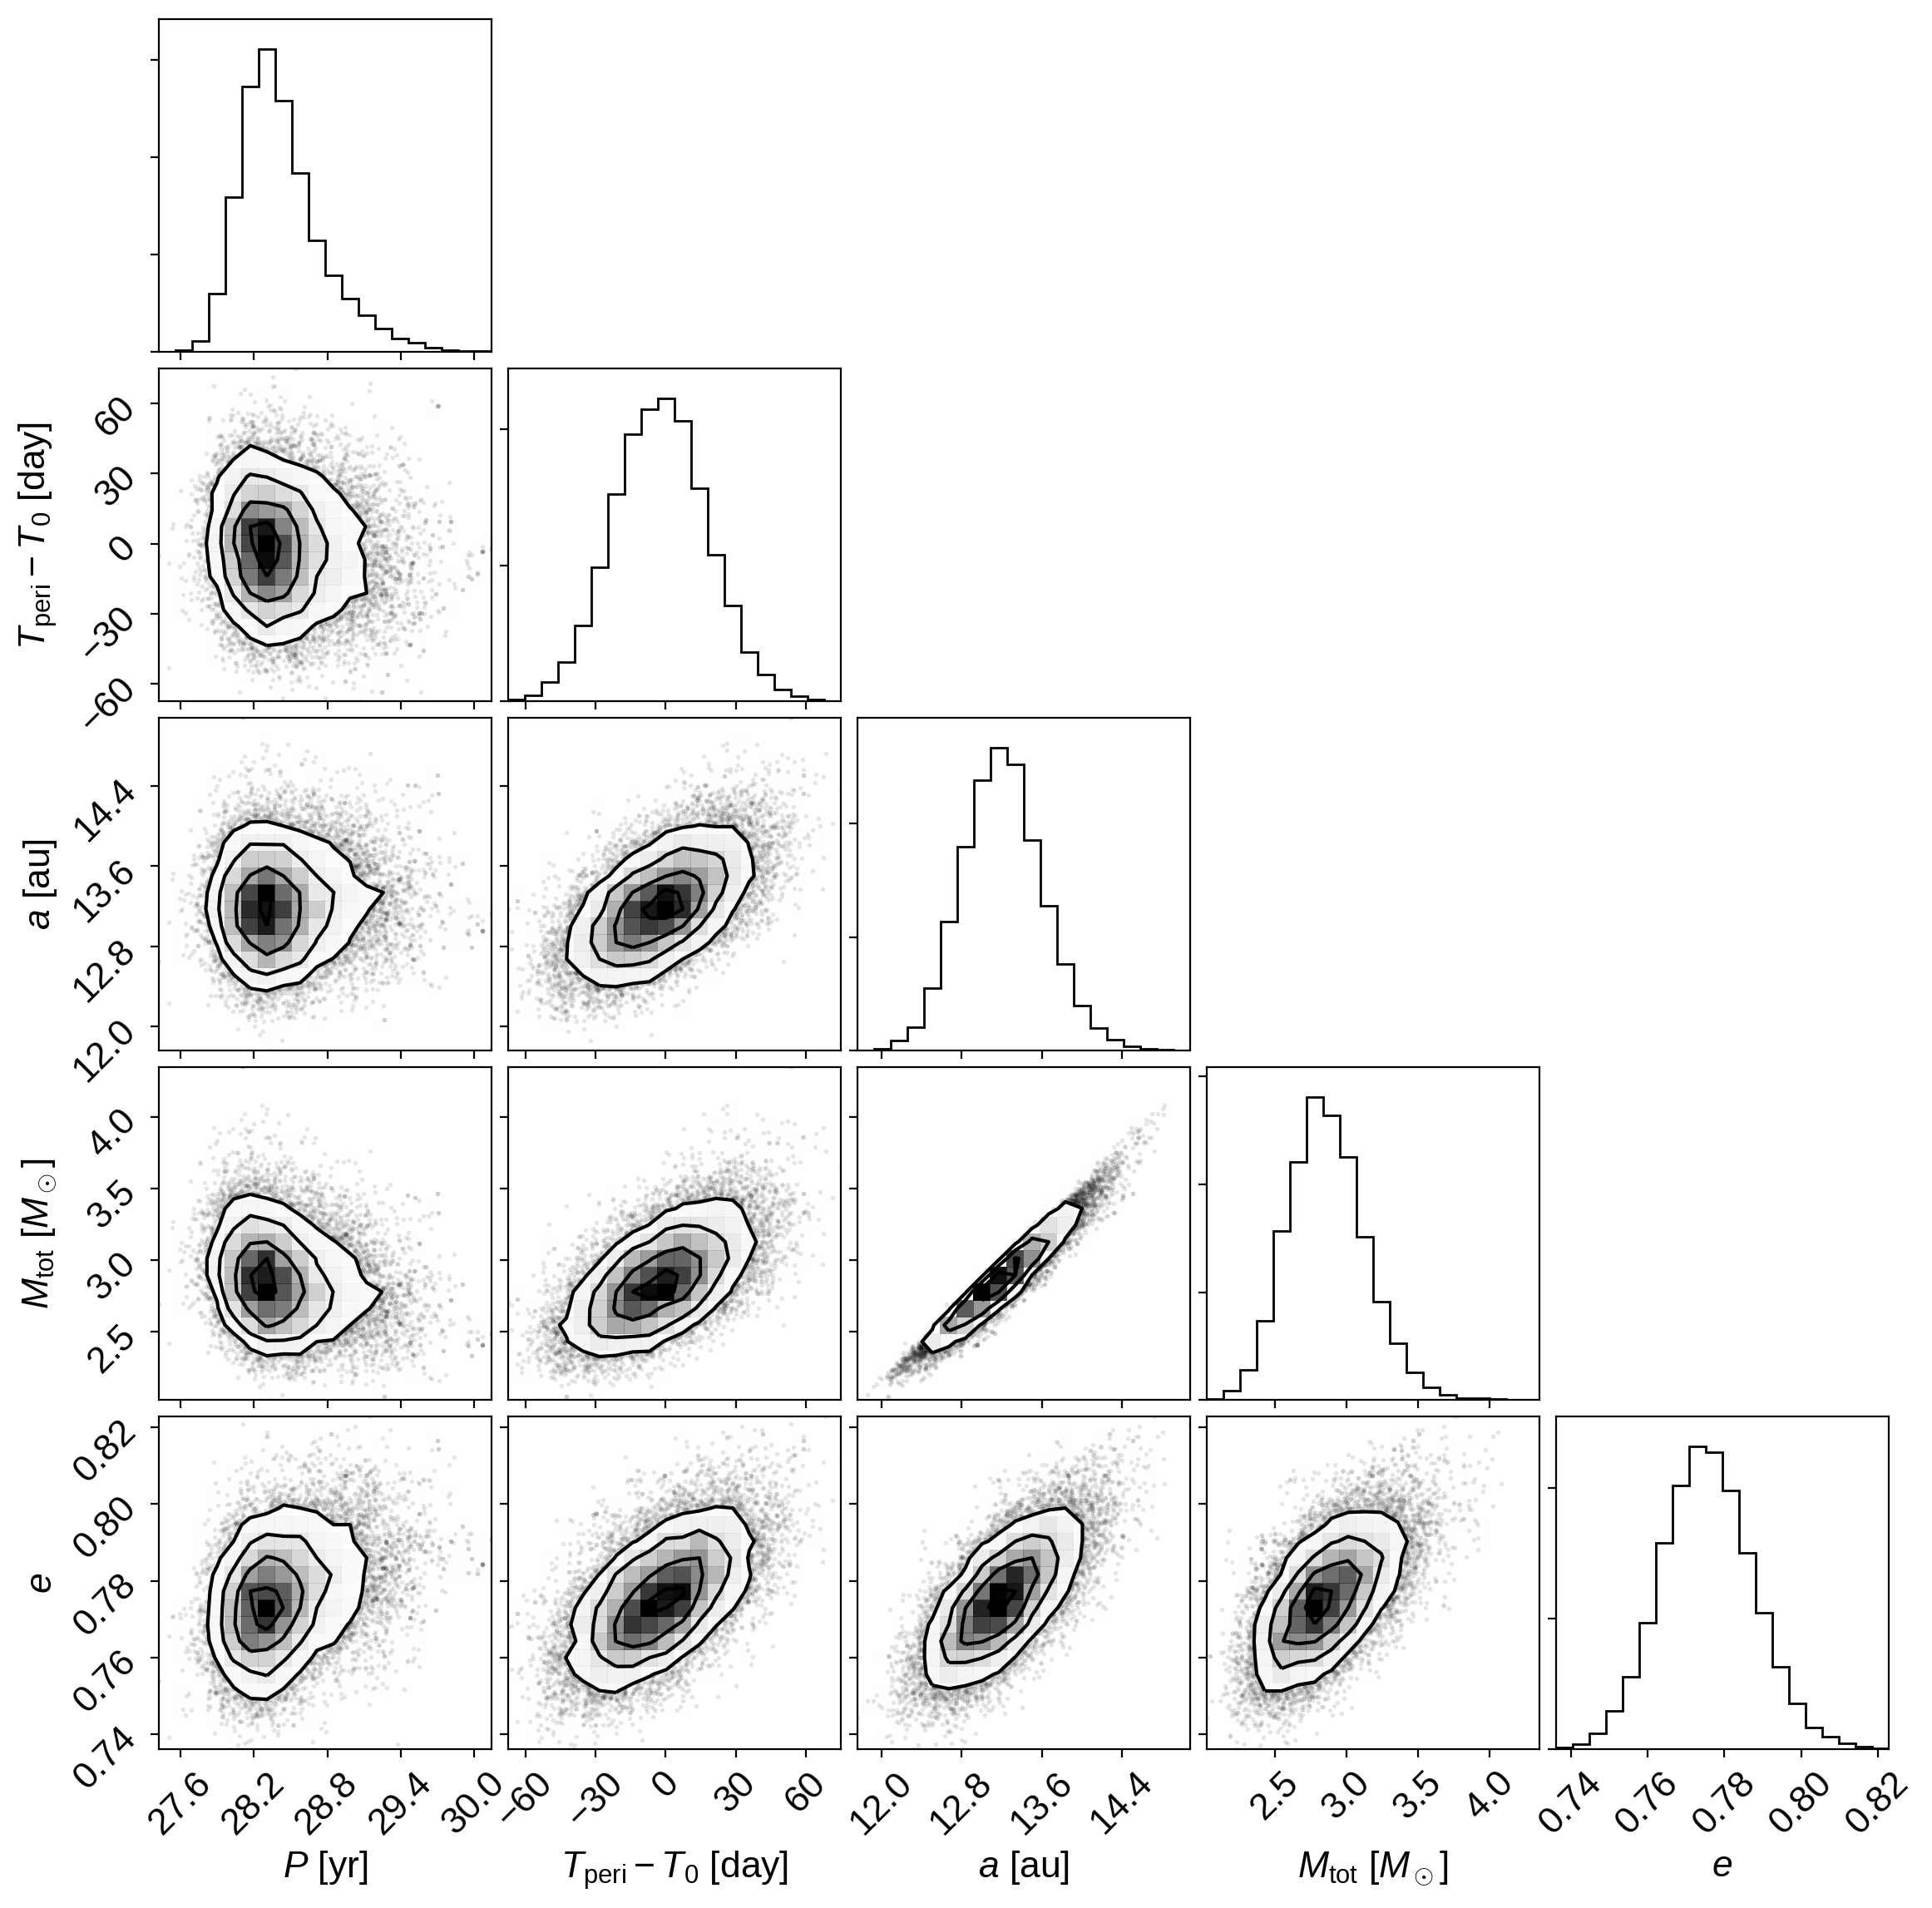

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
corner.corner(samples);

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet v0.2.3},
   month = nov,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
